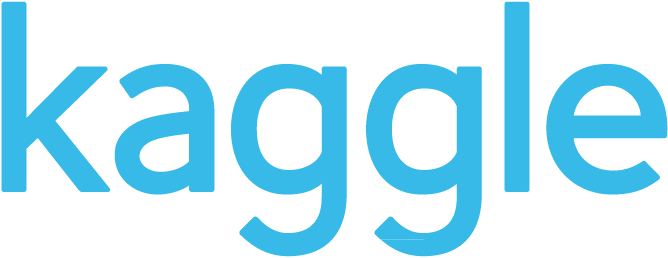

# **Group Assignment S-1: Patient's smoking status**

# Mikel Albisu \\ Andreu Artigues \\ Lea Brunner \\ Juan Sebastian Chombo \\ Yazeed Yabroudi

# <font color='red'> **README**:</font>

---



**Always** remember to comment the code you are doing, as it would help us later know what is happening. Also **try explaining WHY are you doing what you are doing**, and the features behind it (specially when talking about model selection and evaluation, but applies for all parts).


---


Keep in mind **variables names**, lets have everything named the same accross the notebook so that we all know what we are talking about.

---



Dont be afraid to look up for information, the solutions are out there. If you take code from anywhere (which is fine) just say where it came from and makes sure you understand what is happening. I attach direct links to kaggle so we can check on it.

https://www.kaggle.com/datasets/gauravduttakiit/smoker-status-prediction-using-biosignals/code?datasetId=2367101&sortBy=voteCount

Some notebook where to got inspired:
https://www.kaggle.com/code/rukenmissonnier/predict-using-tfdf#Gradient-Boosted-Trees-vs.-Random-Forests

https://gist.github.com/satkr7/219ef0497f8cb7f717820508dd97cc10#file-mulitple_models_with_gridsearchcv-ipynb


**Professor**, these are the packages that were to our disposal through this project.

In [ ]:
#!pip install kaggle ipympl matplotlib numpy pandas scikit-learn pandas-profiling seaborn pydotplus dtreeviz treeinterpreter plotly xgboost graphviz requests folium imgaug

We import all the necessary packages for a data science projects

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 0.90
plt.rcParams['axes.formatter.limits'] = [-4, 4]
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
import pylab

import numpy as np
import pandas as pd
from pandas import read_csv
import seaborn as sns
from scipy.stats import uniform, randint, stats
#------------------------------#
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score,roc_curve, auc,classification_report
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
from xgboost import plot_importance
#------------------------------# 
import joblib #Stores model
#------------------------------#
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df=read_csv('train.csv')
test_df=read_csv('test.csv')

Before proceeding, we would like to make sure that the test_df is not a subset of the train_df

In [75]:
merged_df = pd.merge(train_df, test_df, how='inner')

# Check if test_df is a subset of X
if merged_df.equals(test_df):
    print("Test_df is a subset of train_df")
else:
    print("Test_df is not a subset of train_df")

Test_df is not a subset of train_df


# **EXPLORATORY DATA ANALYSIS**

Next, we will explore the available database for the assignment. The objective is to gain insights and identify patterns, relationships, and anomalies in the data. The structure of the exploratory work will be divided into the following subsections:

1. Structure Investigation
2. Quality Investigation
3. Content Investigation
    1. Univariate analysis and its relationship with the smoking feature
    2. Bivariate analysis
4. Conclusions of the Exploratory Data Analysis

Regarding the mechanics of the analysis performed, we expect that based on different insights we have obtained from the dataset's features, we create different DataFrames collecting information from the original database in different ways. This way, we can see in the Model Deployment section whether any of the insights and assumptions we make in this section make practical sense in the model's development.

## 1. Structure Investigation

Before looking at the content of the database, let's see what the general structure of it is:

In [ ]:
train_df.shape

(159256, 24)

We see that we have a database with 24 different features and 159,000 samples. The next step will be to understand what types of features are in the original dataset:

In [ ]:
pd.value_counts(train_df.dtypes)

int64      19
float64     5
Name: count, dtype: int64

We see that all variables are numeric. Later, when we analyze the features one by one, we will verify if each of them is correctly associated with its data type. As a first look at how the data is distributed across the variables, we will check how many different unique values appear in each variable:

<Axes: title={'center': 'Unique values per feature'}>

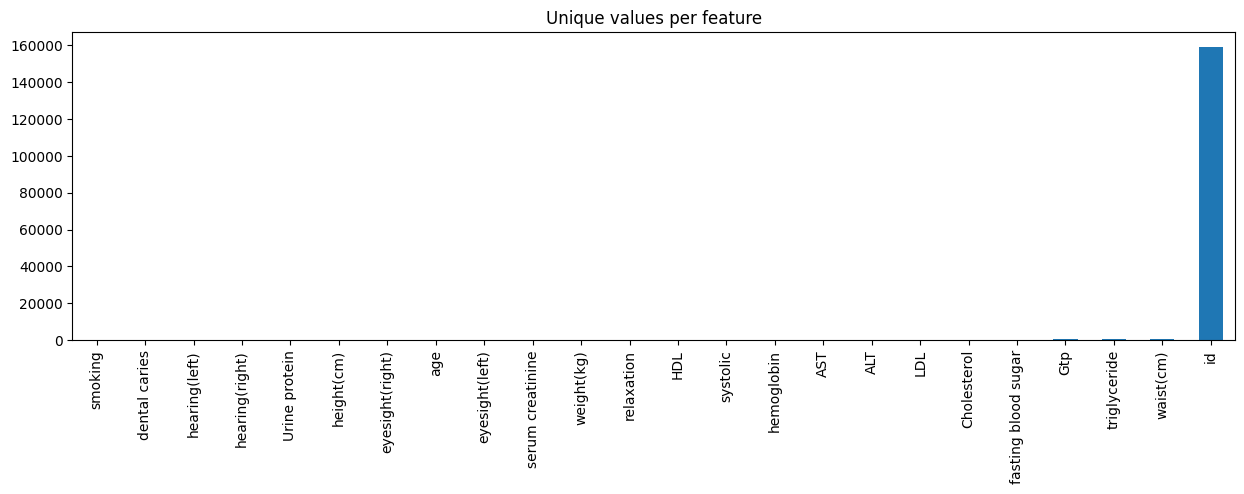

In [ ]:
unique_values = train_df.nunique().sort_values()
unique_values.plot.bar(figsize=(15,4), title= 'Unique values per feature')

We see in the bar chart that there is a feature called 'id' that probably collects the unique values of each data sample. For practical purposes of better visualization of the variable, we are going to discard the variable from the chart and apply the logarithm to the total unique values to improve visibility:

<Axes: title={'center': 'Unique values per feature'}>

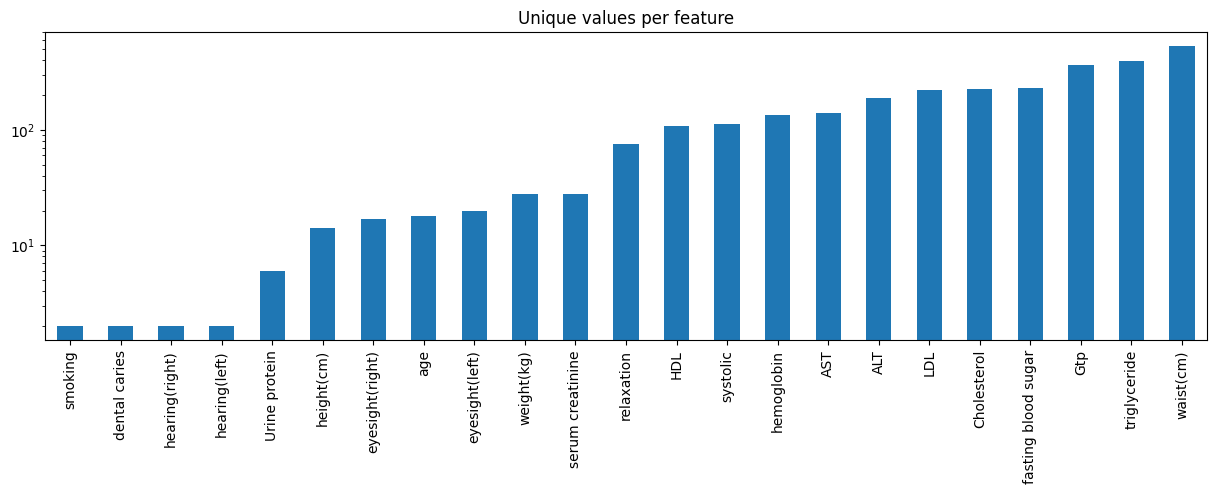

In [ ]:
unique_values = train_df.drop(columns='id').nunique().sort_values()
unique_values.plot.bar(logy=True, figsize=(15,4), title= 'Unique values per feature')

At first glance, it can be observed that there is a lot of variability between the features in terms of the number of unique values for each one. As an initial approximation, this indicates the need to understand each variable independently before starting to develop the model because a good understanding will help us determine if it is necessary to apply scaling measures or reduce the complexity of any of the variables.

As a final point in this section, let's obtain the data type of each variable and how it relates to the unique values we just observed:

In [ ]:
unique_values = train_df.drop(columns='id').nunique()
data_types = train_df.drop(columns='id').dtypes

data_unique_types = pd.DataFrame({
    'Feature': unique_values.index,
    'Unique_Values': unique_values.values,
    'Data_Type': data_types.values
})

data_unique_types['Data_Type'] = data_unique_types['Data_Type'].map(lambda x: 'Integer' if x == 'int64' else 'Float')
data_unique_types


Feature  Unique_Values Data_Type
0                   age             18   Integer
1            height(cm)             14   Integer
2            weight(kg)             28   Integer
3             waist(cm)            531     Float
4        eyesight(left)             20     Float
5       eyesight(right)             17     Float
6         hearing(left)              2   Integer
7        hearing(right)              2   Integer
8              systolic            112   Integer
9            relaxation             75   Integer
10  fasting blood sugar            229   Integer
11          Cholesterol            227   Integer
12         triglyceride            392   Integer
13                  HDL            108   Integer
14                  LDL            222   Integer
15           hemoglobin            134     Float
16        Urine protein              6   Integer
17     serum creatinine             28     Float
18                  AST            140   Integer
19                  ALT            188   Integer
20                  Gtp            362   Integer
21        dental caries              2   Integer
22              smoking              2   Integer

## 2. Quality Investigation

The objective of this section is to determine the quality of the data we have before analyzing exactly what the data represents. To do this, first, we will analyze if there are any duplicate data entries, then we will examine if there is any missing data in any variable, and finally, at the end of this section, we will represent in a graph how the data is distributed to see if there are any general-level issues.

As we discussed, next, we will check if there are any duplicate elements in our sample data:

In [ ]:
n_duplicates = train_df.duplicated().sum()
print(f"You seem to have {n_duplicates} duplicates in your database.")

You seem to have 0 duplicates in your database.


Now, we will check the same after removing the 'id' column in case it is causing no duplicate elements to be detected:

In [ ]:
n_duplicates = train_df.drop(labels='id', axis=1).duplicated().sum()
print(f"You seem to have {n_duplicates} duplicates in your database.")

You seem to have 0 duplicates in your database.


The next step will be to check for null values in our dataset:

In [ ]:
null_perc = round(100*(train_df.isna().sum()/len(train_df)),2)

null_perc

id                     0.0
age                    0.0
height(cm)             0.0
weight(kg)             0.0
waist(cm)              0.0
eyesight(left)         0.0
eyesight(right)        0.0
hearing(left)          0.0
hearing(right)         0.0
systolic               0.0
relaxation             0.0
fasting blood sugar    0.0
Cholesterol            0.0
triglyceride           0.0
HDL                    0.0
LDL                    0.0
hemoglobin             0.0
Urine protein          0.0
serum creatinine       0.0
AST                    0.0
ALT                    0.0
Gtp                    0.0
dental caries          0.0
smoking                0.0
dtype: float64

As expected from a Kaggle dataset, the database comes clean, so there is no need to perform additional cleaning steps. Nevertheless, we will check in the individual analysis of each variable in case there are any null values introduced with terminology not recognized by the `.isna()` function. Finally, we will graphically represent the data to identify any hidden patterns that may demonstrate that a variable is not representing data correctly:

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

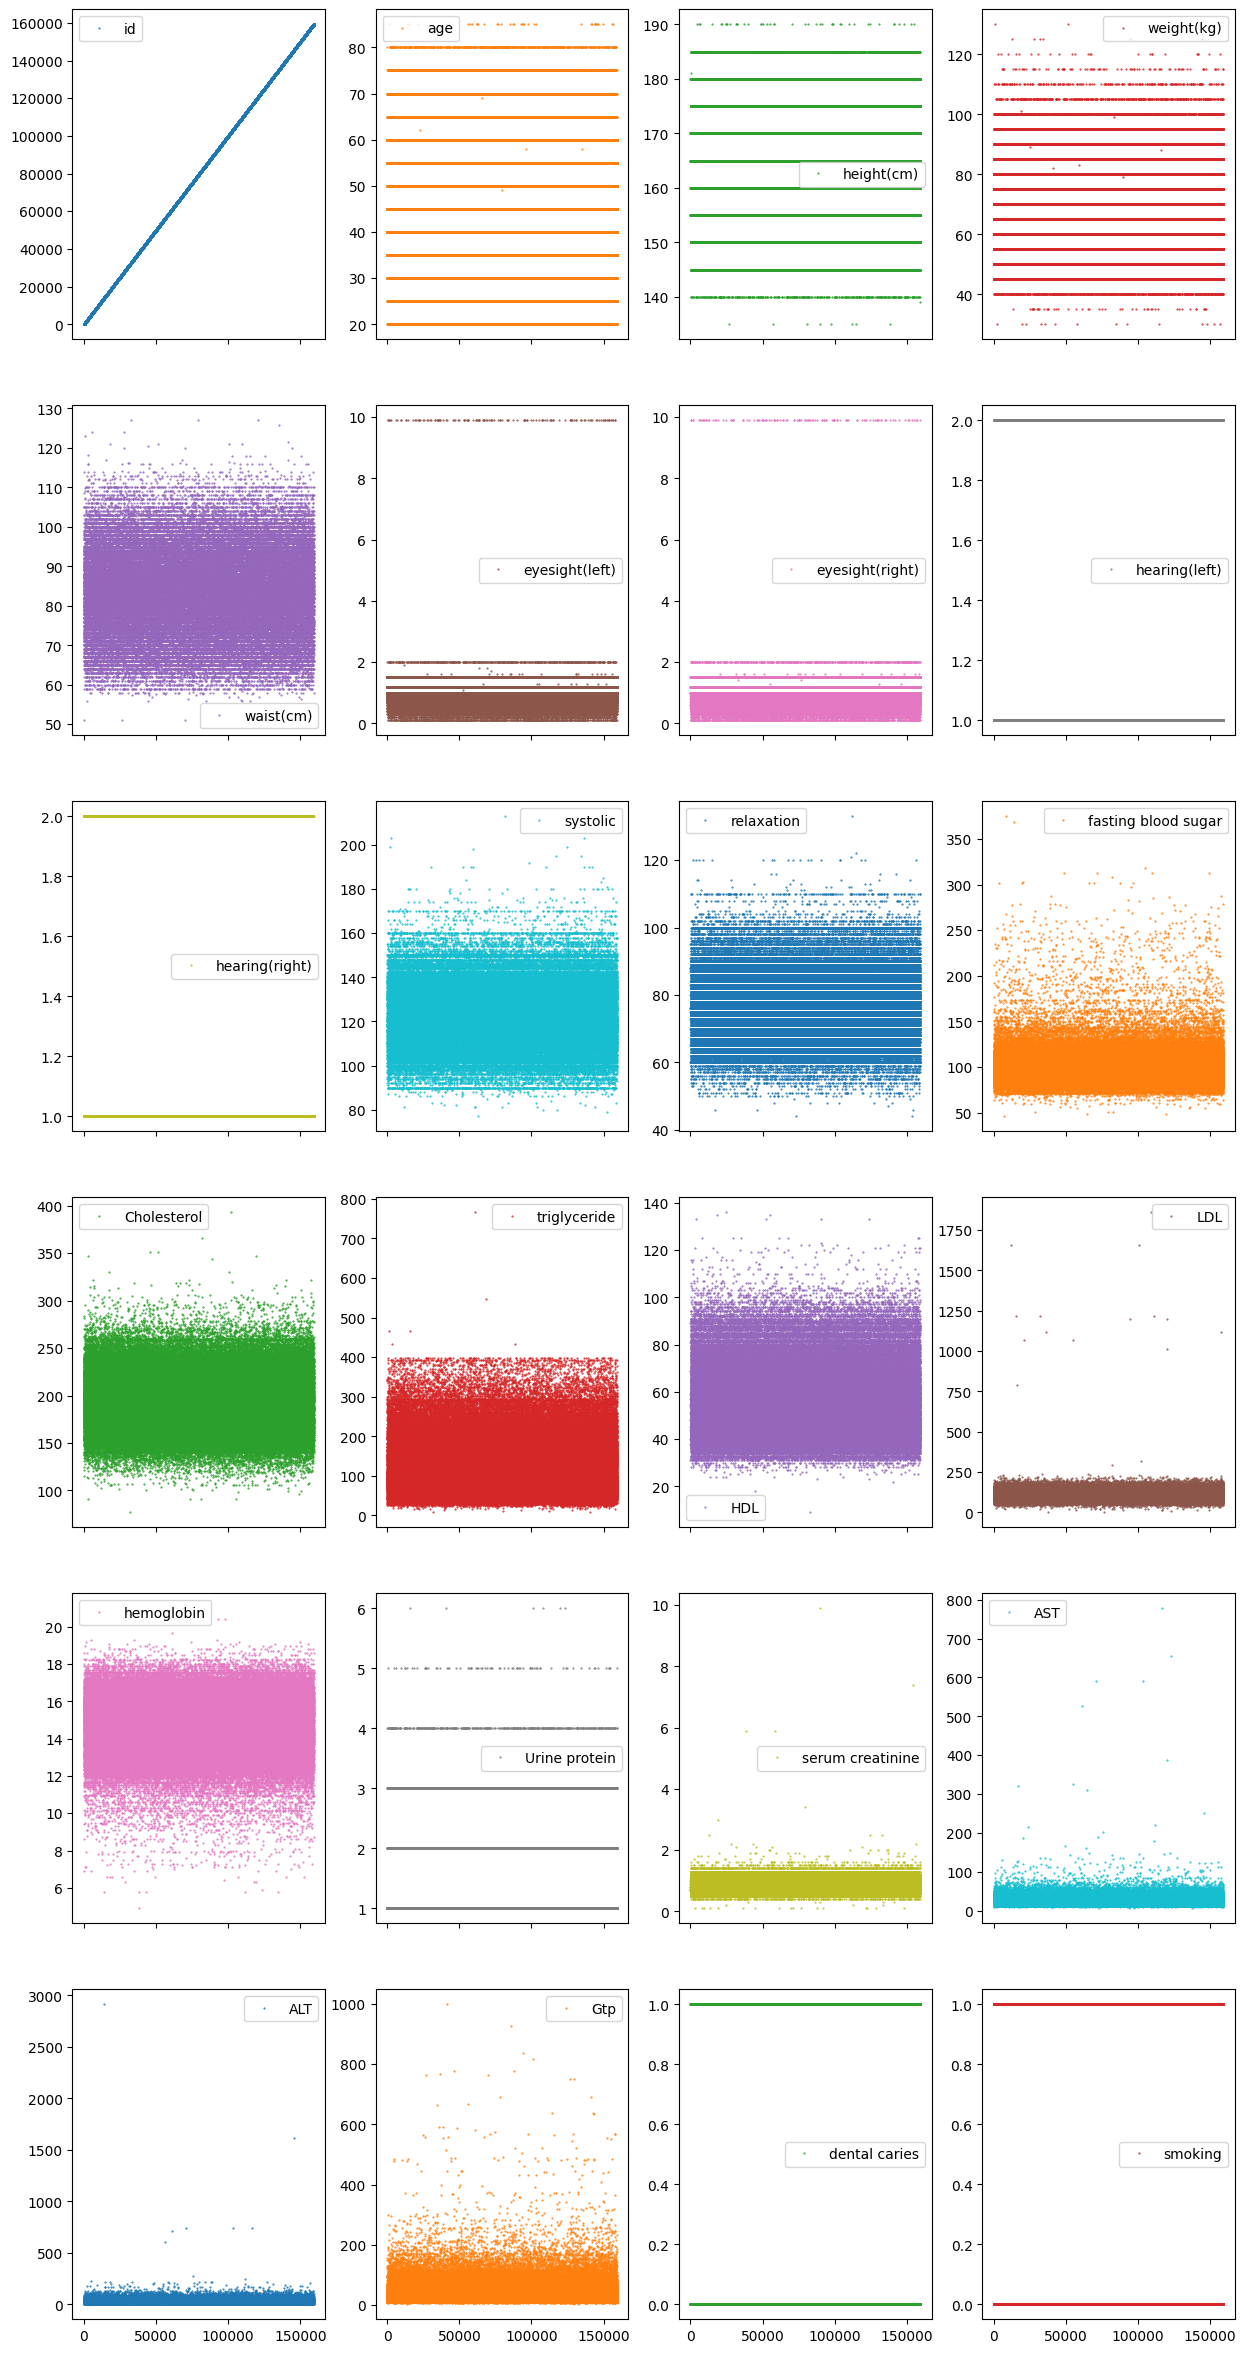

In [ ]:
train_df.plot(lw=0, marker='.', subplots=True, layout=(-1,4), figsize=(15,30), markersize=1)

## 3. Content Investigation

So far, we have conducted an analysis of the structure and quality of the dataset without delving into what it contains. Therefore, we will now proceed to do just that. Initially, we will analyze the features individually and understand their relationship with the target variable 'smoking'. Later on, we will analyze the relationships between different variables to uncover any hidden insights that may apply to the model. The objective is to end up with a complete understanding of the dataset so that, based on these insights, we can transform the dataset to gather the data that seems most coherent to us when training the model on the dataset.

### 3.1. Univariate analysis and its relationship with the smoking feature

As we just described, in this section, we will analyze the features individually to gain a deep understanding of them and also assess their relevance in the model by examining their correlation with the target variable 'smoking'.

To do this, we will subdivide the analysis into the following steps:

1. Medical description
2. Reasonable values
3. Correct Data Type?
4. Values collected in the dataset
5. Relationships with smoking
6. Observations to consider in feature engineering

Since in this analysis, we will assess the features based on their relevance in the model, we understand that we do not need the 'id' variable as it should not be indicative of whether a person smokes or not. Therefore, before starting the analysis, we will remove this variable:

In [ ]:
train_df = train_df.drop('id', axis=1)

#### Target Variable: Smoking

Since the target variable is different from the rest of the variables, let's directly analyze what this column contains using the following plot:

In [ ]:
smoking_sum_unique_values = train_df['smoking'].value_counts()
smoking_sum_unique_values

smoking
0    89603
1    69653
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x19102e16a50>,
 [Text(-0.215056912556635, 1.078772693555787, 'No smoking'),
  Text(0.21505691255663462, -1.078772693555787, 'They smoke')],
 [Text(-0.11730377048543725, 0.5884214692122474, '56.3%'),
  Text(0.11730377048543705, -0.5884214692122475, '43.7%')])

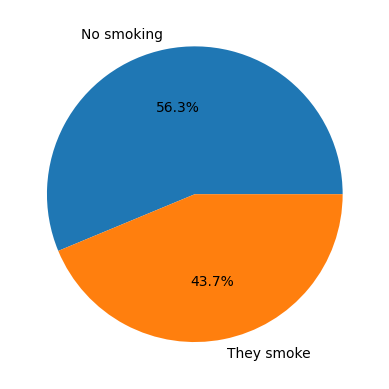

In [ ]:
fig, ax = plt.subplots()
ax.pie(smoking_sum_unique_values, labels=['No smoking','They smoke'], autopct='%1.1f%%')
pass

We can see that the distribution between smokers and non-smokers is fairly balanced, so we can confirm that there is no significant imbalance in the sample. As mentioned earlier, in the analysis of the features that we will carry out next, we will analyze the distribution of the target variable value among the different populations within each variable.

#### Feature 1: Age

##### 1. Medical Description

Sociological research demonstrates that there are significant differences internationally in the proportion of adults who smoke depending on their age/generation. This could be due to significant cultural differences, so initially, we can understand that age is a factor that may be important in predicting whether a person smokes or not. Among these studies, we want to highlight the differences in the smoking population in the United States as of 2021, as an example:

"Current cigarette smoking was highest among people aged 25–44 years and 45–64 years. Current cigarette smoking was lowest among people aged 18-24 years.

- About 5 of every 100 adults aged 18–24 years (5.3%)
- Nearly 13 of every 100 adults aged 25–44 years (12.6%)
- Nearly 15 of every 100 adults aged 45–64 years (14.9%)
- About 8 of every 100 adults aged 65 years and older (8.3%)"

Source: [CDC - Adult Cigarette Smoking in the United States](https://www.cdc.gov/tobacco/data_statistics/fact_sheets/adult_data/cig_smoking/index.htm)

##### 2. Reasonable values

Understood. Therefore, the reasonable values we should expect in the sample will be within the age range of 18 years to 100 years. Any value outside of this range, such as 200 years or 5 years, would be considered unreasonable.

##### 3. Correct Data Types?

In [ ]:
train_df['age'].dtypes

dtype('int64')

Understood, it seems reasonable for the feature to be recorded as an integer given its nature as age.

##### 4. Values collected in the dataset

In [ ]:
def analyze_feature(feature_to_analyze):
    mean = feature_to_analyze.mean()
    median = feature_to_analyze.median()
    mode = feature_to_analyze.mode()[0]
    data_range = feature_to_analyze.max() - feature_to_analyze.min()
    variance = feature_to_analyze.var()
    std_dev = feature_to_analyze.std()
    maximum = feature_to_analyze.max()
    minimum = feature_to_analyze.min()
    quartiles = feature_to_analyze.quantile([0.25, 0.5, 0.75])

    print(f"Feature: {feature_to_analyze.name}")
    print(f"Mean: {mean}")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Range: {data_range}")
    print(f"Variance: {variance}")
    print(f"Standard Deviation: {std_dev}")
    print(f"Maximum: {maximum}")
    print(f"Minimum: {minimum}")
    print("Quartiles:")
    print(quartiles)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(feature_to_analyze.round())
    plt.title('Histogram')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=feature_to_analyze)
    plt.title('Boxplot')

    plt.tight_layout()
    plt.show()

Feature: age
Mean: 44.30662581001658
Median: 40.0
Mode: 40
Range: 65
Variance: 140.2397340645164
Standard Deviation: 11.84228584625943
Maximum: 85
Minimum: 20
Quartiles:
0.25    40.0
0.50    40.0
0.75    55.0
Name: age, dtype: float64


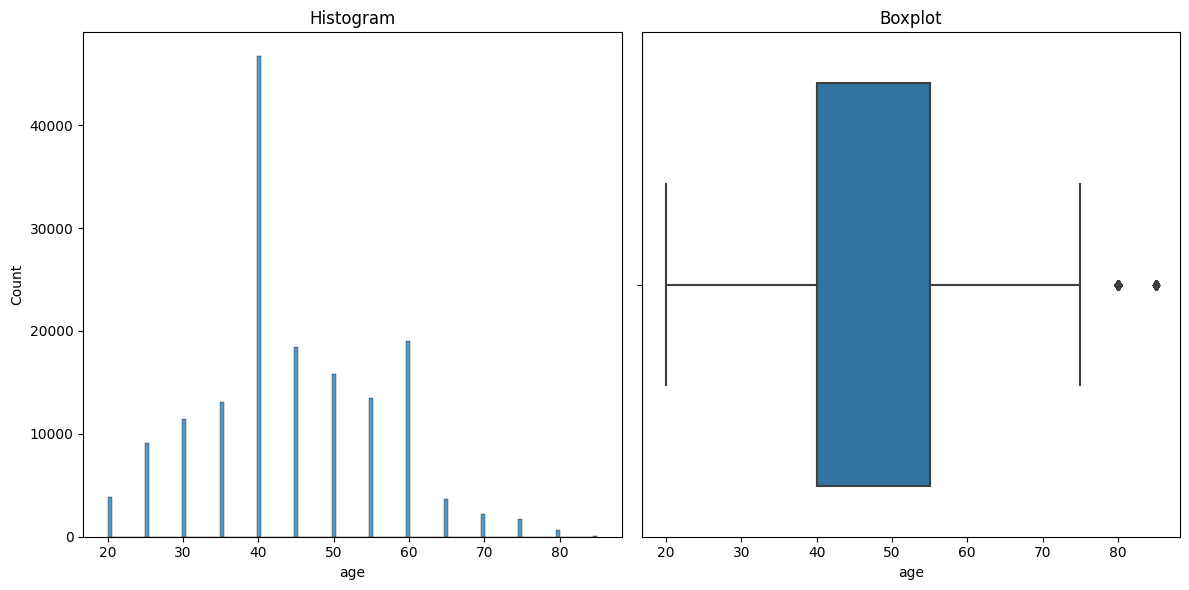

In [ ]:
analyze_feature(train_df['age'])

In [ ]:
counts_per_age = pd.DataFrame()
counts_per_age['counts'] = pd.DataFrame(train_df['age'].value_counts())
counts_per_age['percentage'] = counts_per_age['counts'] / counts_per_age['counts'].sum()
counts_per_age

counts  percentage
age                    
40    46691    0.293182
60    19043    0.119575
45    18480    0.116040
50    15768    0.099010
55    13446    0.084430
35    13081    0.082138
30    11465    0.071991
25     9140    0.057392
20     3829    0.024043
65     3637    0.022837
70     2229    0.013996
75     1760    0.011051
80      644    0.004044
85       38    0.000239
58        2    0.000013
62        1    0.000006
69        1    0.000006
49        1    0.000006

There is a significant number of data corresponding to people aged 40 (close to 30 percent of the total sample). This indicates that the sample is unbalanced and may affect the applicability of the model.

##### 5. Relationship with smoking

Next, we will analyze the relationship between the variable and the target variable 'smoking'. Our goal is to determine if the populations of smokers and non-smokers differ from each other. By knowing this, we can address whether the variable itself is necessary in the model or not. To do this, we will define three analyses that we will apply to all features:

1. First, we will graphically represent the populations of smokers and non-smokers in the variable. This way, we can visually determine if they are significantly different from each other.
2. Next, we will train a simple logistic regression model to understand the importance of the variable in predicting the smoking condition.
3. Lastly, we will perform a statistical analysis of the difference between the two populations. To do this, we first need to determine if the population follows a normal distribution once normalized. If the population follows a normal distribution, we will apply the t-test, and if not, a similar test for non-normal populations known as the Mann-Whitney U test. If the p-value is less than 0, we cannot assume that the two populations are equal, which could indicate that the feature and the smoking condition are related.

In [ ]:
def effect_of_smoking_visualiztion(feature):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    custom_palette = ['#4D3425', '#E4512B']

    sns.boxplot(x='smoking', y=feature, data=train_df, ax=axs[0], palette=custom_palette)
    axs[0].set_title(f'Boxplot of {feature} by Smoking Status')
    axs[0].set_xlabel('Smoking')
    axs[0].set_ylabel(feature)

    sns.kdeplot(data=train_df, x=feature, hue="smoking", ax=axs[1], palette=custom_palette, common_norm=False)
    axs[1].set_title(f'KDE Distribution of {feature} by Smoking Status')
    axs[1].set_xlabel(feature)
    axs[1].set_ylabel('Density')

    sns.despine()

    fig.tight_layout()
    plt.show()

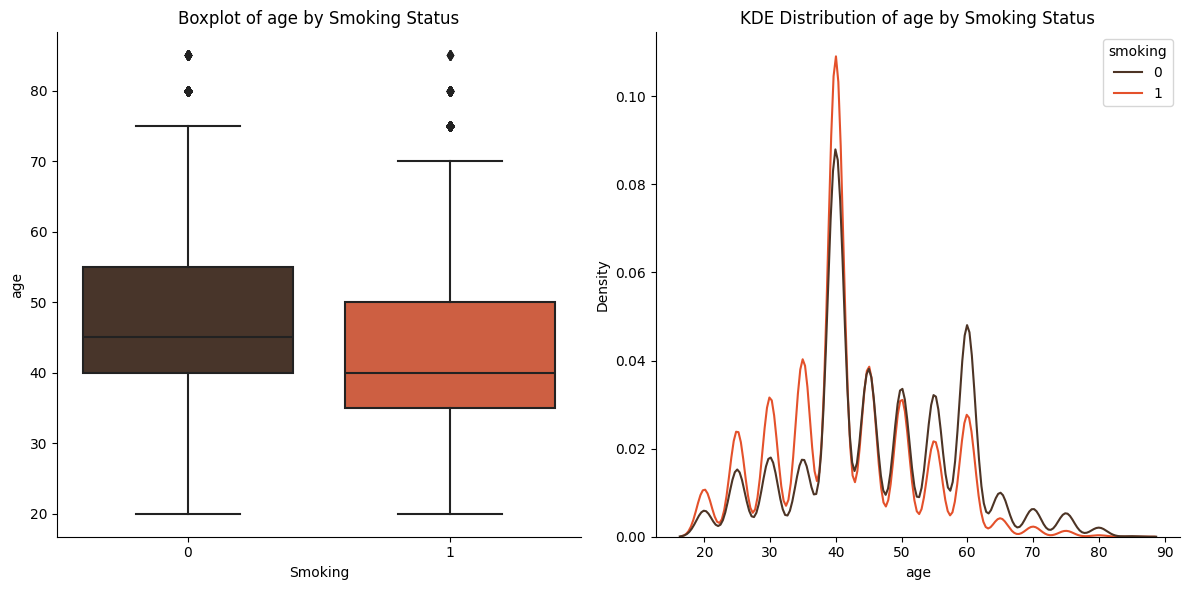

In [ ]:
effect_of_smoking_visualiztion('age')

In [ ]:
def feature_imp_log_regression(feature):
    X = train_df[[feature]]
    y = train_df['smoking']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression()
    model.fit(X_train_scaled, y_train)

    feature_importance = pd.Series(model.coef_[0], index=[feature])
    feature_importance.plot(kind='bar')
    plt.title('Feature Importance in Predicting Smoking Status')
    plt.show()

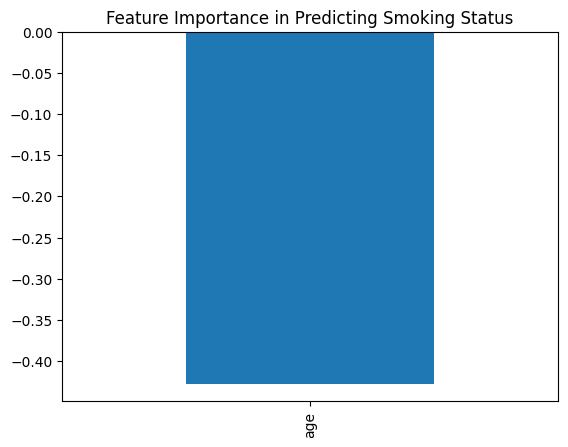

In [ ]:
feature_imp_log_regression('age')

In [ ]:
def test_feature_normality_and_difference(df, feature, target_variable):

    # Scale the feature data
    scaler = StandardScaler()
    feature_scaled = scaler.fit_transform(df[feature].values.reshape(-1, 1)).flatten()

    # Test for normality using K-S test
    d_stat, p_normality = stats.kstest(feature_scaled, 'norm')
    is_normal = p_normality > 0.05  # Assuming a significance level of 0.05

    # Select populations
    smokers = df[df[target_variable] == 1][feature]
    non_smokers = df[df[target_variable] == 0][feature]

    # Depending on normality, perform the appropriate test
    if is_normal:
        # Perform t-test
        stat, p_value = stats.ttest_ind(smokers, non_smokers, equal_var=False)
        test_used = 't-test'
    else:
        # Perform Mann-Whitney U test
        stat, p_value = stats.mannwhitneyu(smokers, non_smokers, alternative='two-sided')
        test_used = 'Mann-Whitney U'

    # Formulate conclusion
    significant_difference = p_value < 0.05  # Assuming a significance level of 0.05
    conclusion = "There is a significant difference." if significant_difference else "There is no significant difference."

    # Return the results
    return {
        'test_performed': test_used,
        'is_normal': 'Yes' if is_normal else 'No',
        'p_value': p_value,
        'conclusion': conclusion
    }


In [ ]:
results = test_feature_normality_and_difference(train_df, 'age', 'smoking')
print(results)

{'test_performed': 'Mann-Whitney U', 'is_normal': 'No', 'p_value': 0.0, 'conclusion': 'There is a significant difference.'}


With the results provided, we observe a very small p-value (0.0). This suggests that there is significant evidence to reject the null hypothesis. Therefore, we can conclude that there is a significant difference between smokers and non-smokers. In other words, the age of smokers tends to be different from the age of non-smokers.

This result aligns with our initial hypothesis and indicates that the variable should not be excluded when developing the model.

##### 6. Observations to consider in feature engineering & data preporcessing

As we have observed, the maximum age recorded in the sample is 85 years, while the minimum is 20. Both values fall within the reasonable maximum and minimum for the analysis we are conducting. Therefore, we do not identify any outliers.

Additionally, both based on our understanding of the variable and on what is demonstrated in the sample, it is a variable that varies between smokers and non-smokers, so we understand it to be significant to include in the model.

Despite all of the above, we do observe a much wider sampling of people aged 40 compared to other ages. This could pose a problem in model development, so we will take this into account in the data preprocessing phase.

#### Feature 2: Height (cm)

##### 1. Medical Description

Medical studies show that tobacco reduces bone growth during the growing age mainly due to the effect of nicotine. This effect may be more pronounced in minors during their growth period and should be more related to the age at which smoking started rather than the adult smoking condition. Since our analysis only applies to adults, we understand that, a priori, this factor alone should not be very significant in determining whether someone smokes as an adult.

Study demonstrating the above:
[Effect of smoking on bone quality in adolescents](https://pubmed.ncbi.nlm.nih.gov/19079602/)

##### 2. Reasonable values

Understood, we understand that the values should not deviate significantly from a minimum of 140 cm and a maximum of 210 cm.

##### 3. Correct Data Types?

In [ ]:
train_df['height(cm)'].dtypes

dtype('int64')

We understand it's reasonable for the feature to be recorded as an integer given its nature.

##### 4. Values collected in the dataset

Feature: height(cm)
Mean: 165.2669287185412
Median: 165.0
Mode: 170
Range: 55
Variance: 77.77422913051312
Standard Deviation: 8.818969845198085
Maximum: 190
Minimum: 135
Quartiles:
0.25    160.0
0.50    165.0
0.75    170.0
Name: height(cm), dtype: float64


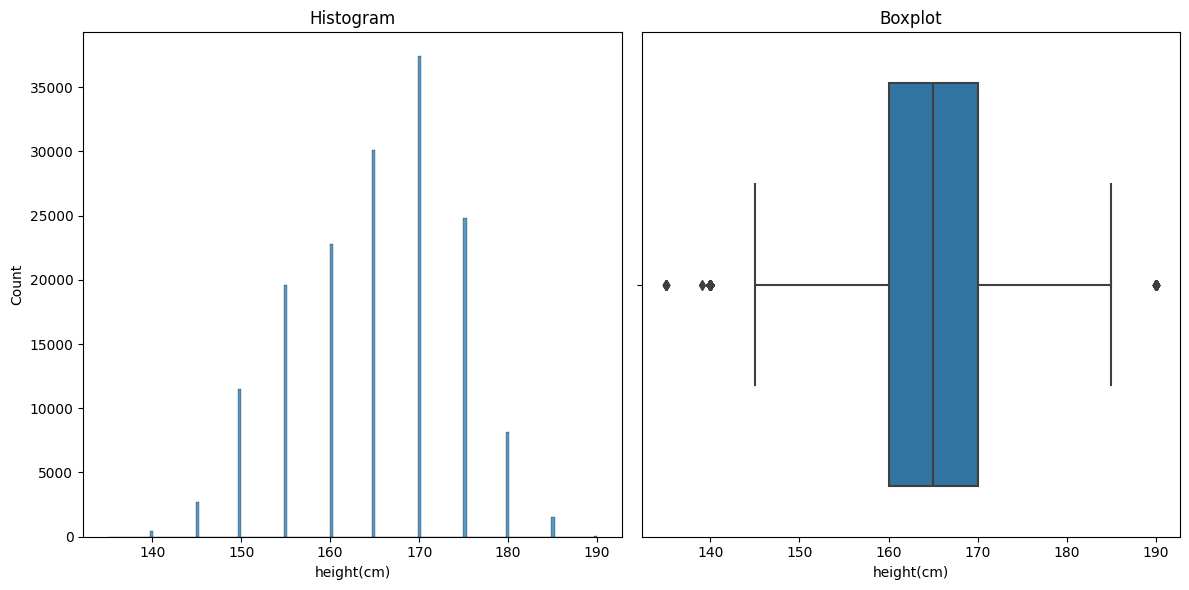

In [ ]:
analyze_feature(train_df['height(cm)'])

From what we can observe, both the mean and the median of the population are 165 cm. It seems that the distribution is fairly balanced and reasonable.

##### 5. Relationship with smoking

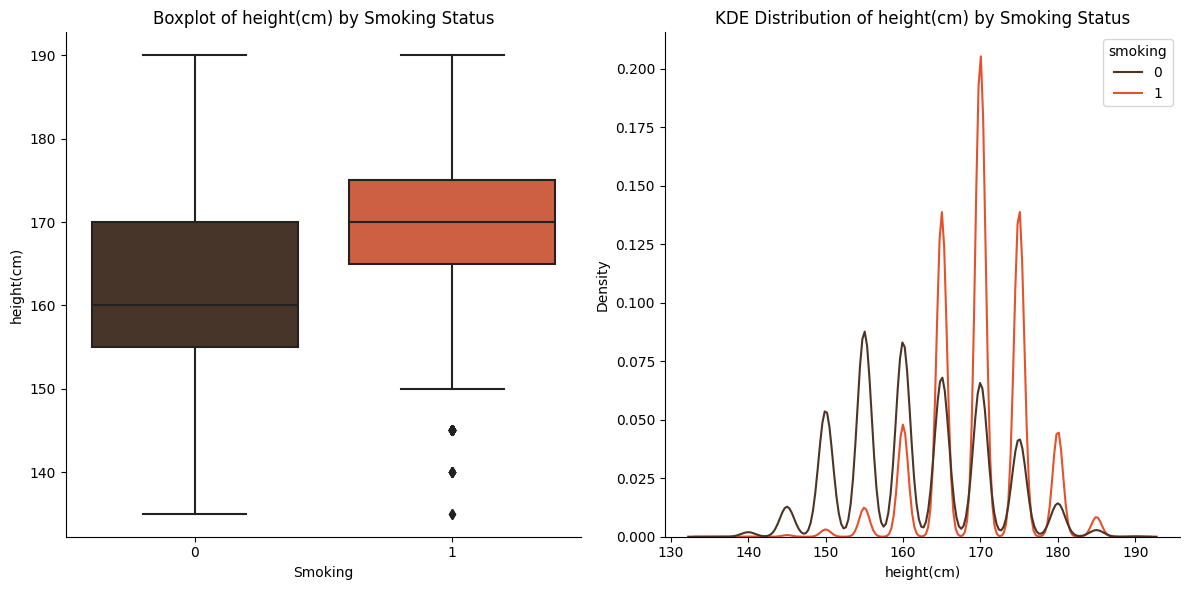

In [ ]:
effect_of_smoking_visualiztion('height(cm)')

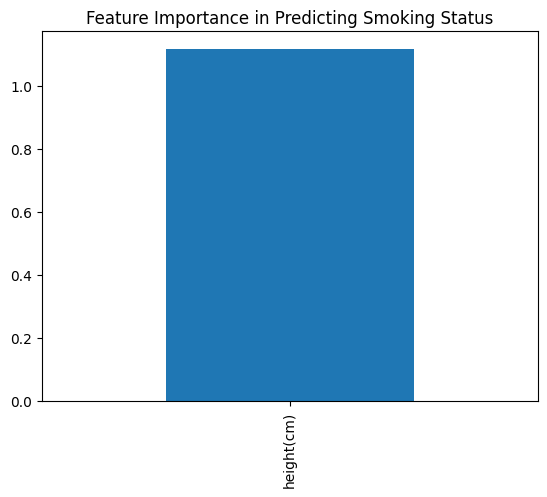

In [ ]:
feature_imp_log_regression('height(cm)')

In [ ]:
results = test_feature_normality_and_difference(train_df, 'height(cm)', 'smoking')
print(results)

{'test_performed': 'Mann-Whitney U', 'is_normal': 'No', 'p_value': 0.0, 'conclusion': 'There is a significant difference.'}


With the results provided, we observe a very small p-value (0.0). This suggests that there is significant evidence to reject the null hypothesis. Therefore, we can conclude that there is a significant difference between smokers and non-smokers.

This result contradicts our initial hypothesis, which should make us reconsider whether to include this variable in the model or not.

##### 6. Observations to consider in feature engineering & data preporcessing

Based on what we have observed in the population, there are no data points that can be considered outliers as all of them appear reasonable. We also observe that there are no values that should not be included in the analysis due to lack of relevance for the sample, based on the previous discussion.

However, we have noticed that the height of smokers and non-smokers in the sample varies significantly, which contradicts what has been studied about the variable. This factor should be taken into account in the feature engineering phase because it may confound the model and incorrectly associate someone's smoking status with their height under conditions where all other variables are equal. We believe this does not make sense.

#### Feature 3: Weight (kg)

##### 1. Medical Description

According to studies, weight alone should not be a reliable indicator of a person's smoking status. On one hand, nicotine has a direct effect on smokers' appetite, often leading smokers to have lower weight than their non-smoking counterparts. On the other hand, although tobacco may have this effect, smoking is often associated with individuals leading sedentary lifestyles, which could suggest that, a priori, individuals with higher obesity are more likely to smoke.

Studies referenced: [Smoking's effect on body weight](https://www.sciencedirect.com/science/article/pii/S0002916523235479#:~:text=Smoking's%20effect%20on%20body%20weight,body%20weight%20found%20in%20smokers.)

##### 2. Reasonable values

The weight of a person is logically closely related to their height under normal conditions. Therefore, healthy individuals should typically fall within the range of 40 to 120 kg. In our understanding, it is more likely for a person to exceed these limits due to being overweight beyond the reasonable maximum rather than being significantly below the minimum.

##### 3. Correct Data Types?

In [ ]:
train_df['weight(kg)'].dtypes

dtype('int64')

We understand it's reasonable for the feature to be recorded as an integer given its nature.

##### 4. Values collected in the dataset

Feature: weight(kg)
Mean: 67.14366177726428
Median: 65.0
Mode: 70
Range: 100
Variance: 158.41238367509314
Standard Deviation: 12.586198142214874
Maximum: 130
Minimum: 30
Quartiles:
0.25    60.0
0.50    65.0
0.75    75.0
Name: weight(kg), dtype: float64


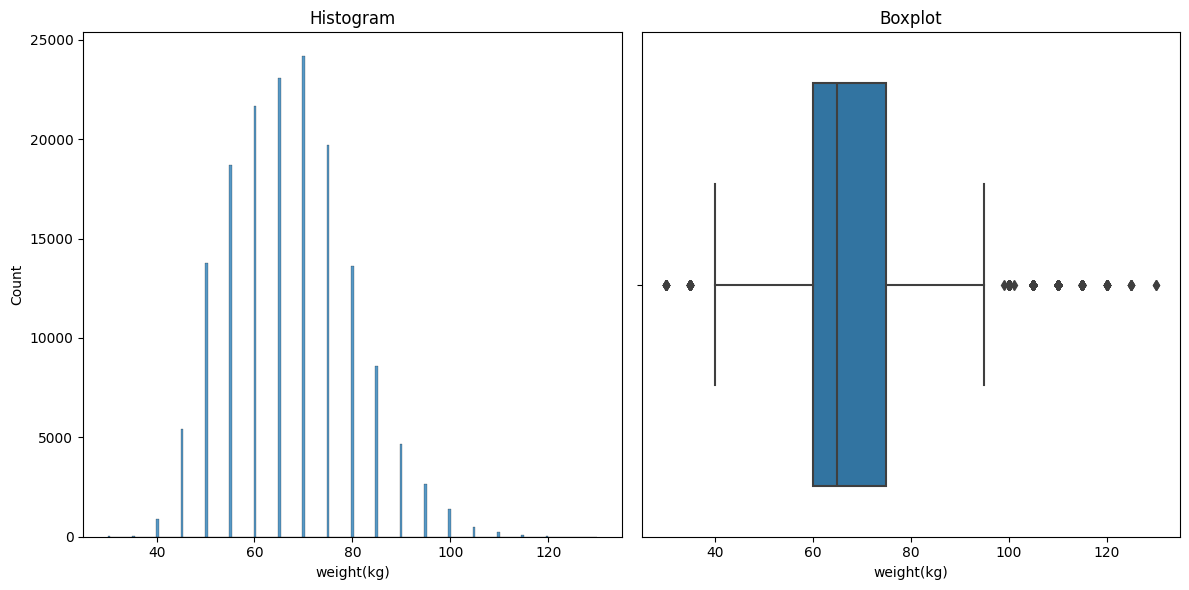

In [ ]:
analyze_feature(train_df['weight(kg)'])

From what we can observe, there are values that fall outside the interval marked by the 1.5 IQR both above and below. However, considering the observed maximum and minimum, we believe that no further review of these values is necessary.

##### 5. Relationship with smoking

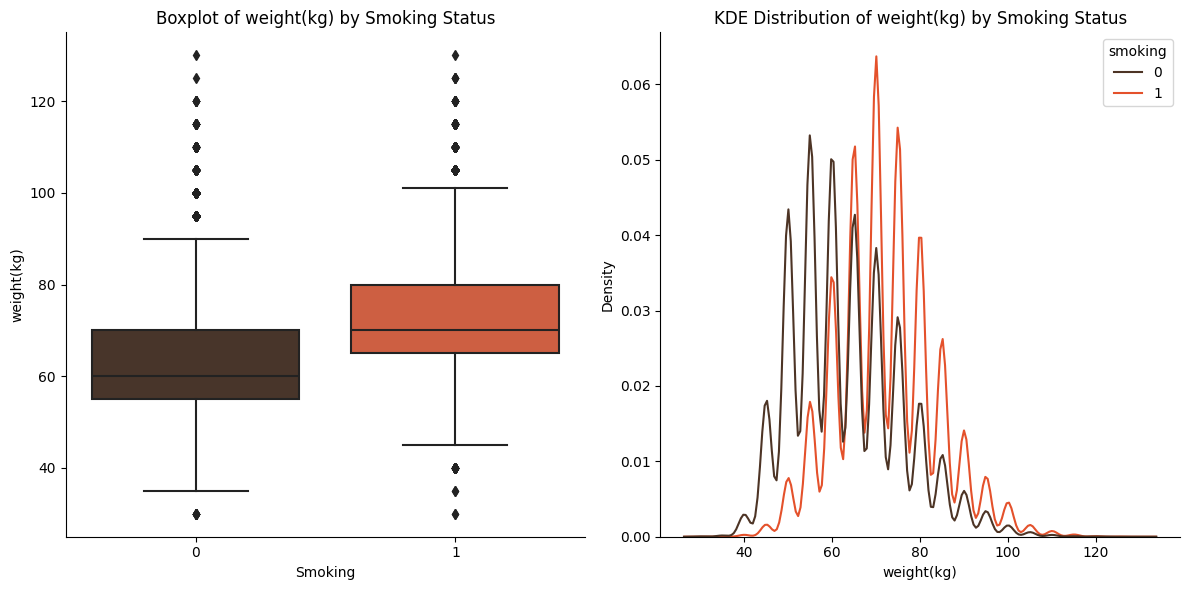

In [ ]:
effect_of_smoking_visualiztion('weight(kg)')

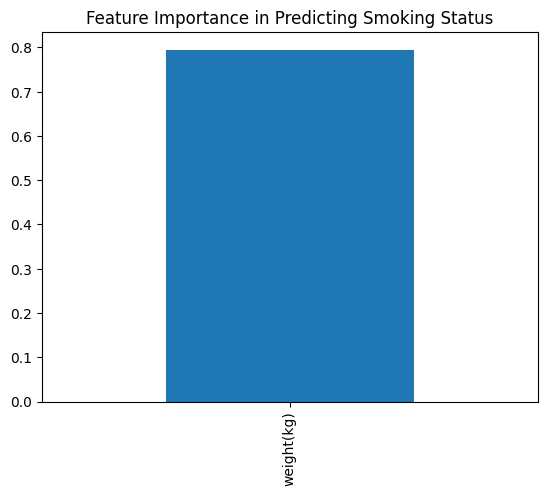

In [ ]:
feature_imp_log_regression('weight(kg)')

In [ ]:
results = test_feature_normality_and_difference(train_df, 'weight(kg)', 'smoking')
print(results)

{'test_performed': 'Mann-Whitney U', 'is_normal': 'No', 'p_value': 0.0, 'conclusion': 'There is a significant difference.'}


With the results provided, we observe a very small p-value (0.0). This suggests that there is significant evidence to reject the null hypothesis. Therefore, we can conclude that there is a significant difference between smokers and non-smokers.

Based on the analysis, we can affirm that the weight of smokers is significantly higher than that of non-smokers, which aligns with our initial hypothesis.

##### 6. Observations to consider in feature engineering & data preporcessing

In the case of weight, we have observed values that are widely situated both below and above the 1.5 IQR, which means that these are data points that deviate from the more common situations regarding weight.

Furthermore, from a medical standpoint, we understand that this variable alone should not be indicative of whether a person smokes or not due to the contrasting effects between the appetite suppression caused by nicotine and the strong association between smoking and sedentary lifestyle. Therefore, we believe that these factors should be taken into account in the feature engineering process to improve the predictability of the model.

#### Feature 4: Waist (cm)

##### 1. Medical Description

It collects the measurement of the waist in centimeters.

This variable should be highly related to weight and height. Together with these variables, it should indicate the obesity or anorexia of the individuals in the sample, which can be related to smoking due to its association with a sedentary lifestyle. This information is obtained from the same study analyzed for the weight variable:

[Smoking's effect on body weight](https://www.sciencedirect.com/science/article/pii/S0002916523235479#:~:text=Smoking's%20effect%20on%20body%20weight,body%20weight%20found%20in%20smokers)

##### 2. Reasonable values

To collect the most common values, we have found two studies that explain the common values and their risk of obesity:

For men:
- Below 94cm (37in) - low risk
- 94–102cm (37-40in) - high risk
- More than 102cm (40in) - very high

For women:
- Below 80cm (31.5in) - low risk
- 80–88cm (31.5-34.6in) - high risk
- More than 88cm (34.6in) - very high

More information is available at:
- [British Heart Foundation](https://www.bhf.org.uk/informationsupport/heart-matters-magazine/medical/measuring-your-waist#:~:text=Why%20does%20your%20waist%20measurement,excess%20fat%20inside%20your%20organs)
- [Harvard School of Public Health](https://www.hsph.harvard.edu/obesity-prevention-source/obesity-definition/abdominal-obesity/)

##### 3. Correct Data Types?

In [ ]:
train_df['waist(cm)'].dtypes

dtype('float64')

We understand it's reasonable for the feature to be recorded as a float given its nature.

##### 4. Values collected in the dataset

Feature: waist(cm)
Mean: 83.00198987793239
Median: 83.0
Mode: 80.0
Range: 76.0
Variance: 80.24463997618504
Standard Deviation: 8.957937261232914
Maximum: 127.0
Minimum: 51.0
Quartiles:
0.25    77.0
0.50    83.0
0.75    89.0
Name: waist(cm), dtype: float64


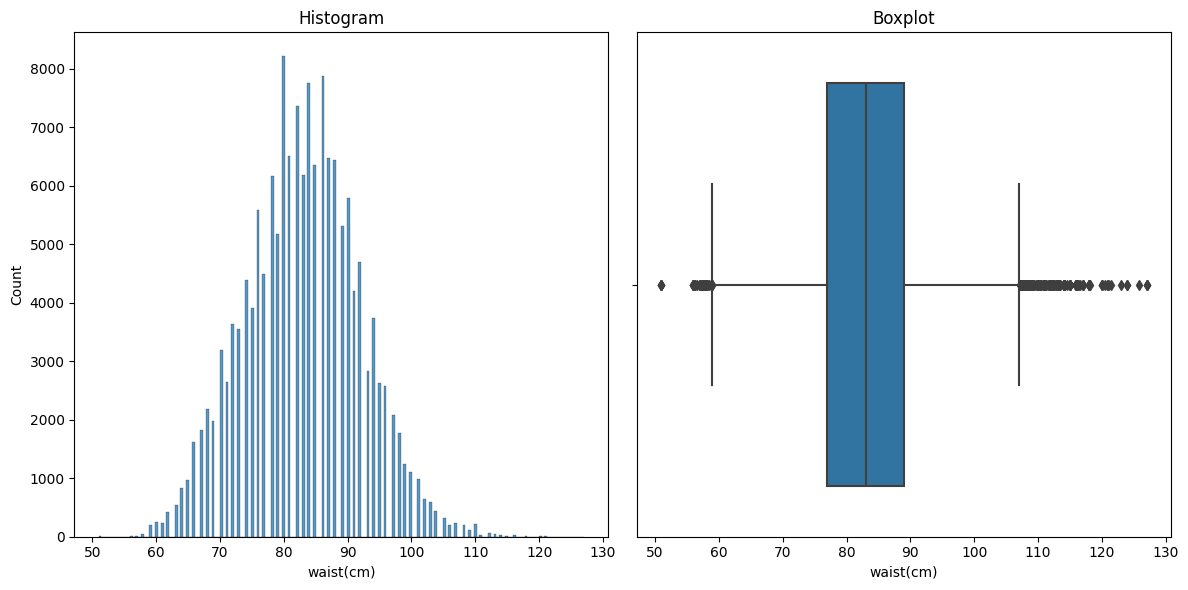

In [ ]:
analyze_feature(train_df['waist(cm)'])

We can observe that the distribution of hip circumference follows what appears to be a normal distribution in the sample. As we have seen in the weight variable, there are certain values that fall both above and below the 1.5 IQR, but they do not appear to be measurements that deviate from possible real-world scenarios.

##### 5. Relationship with smoking

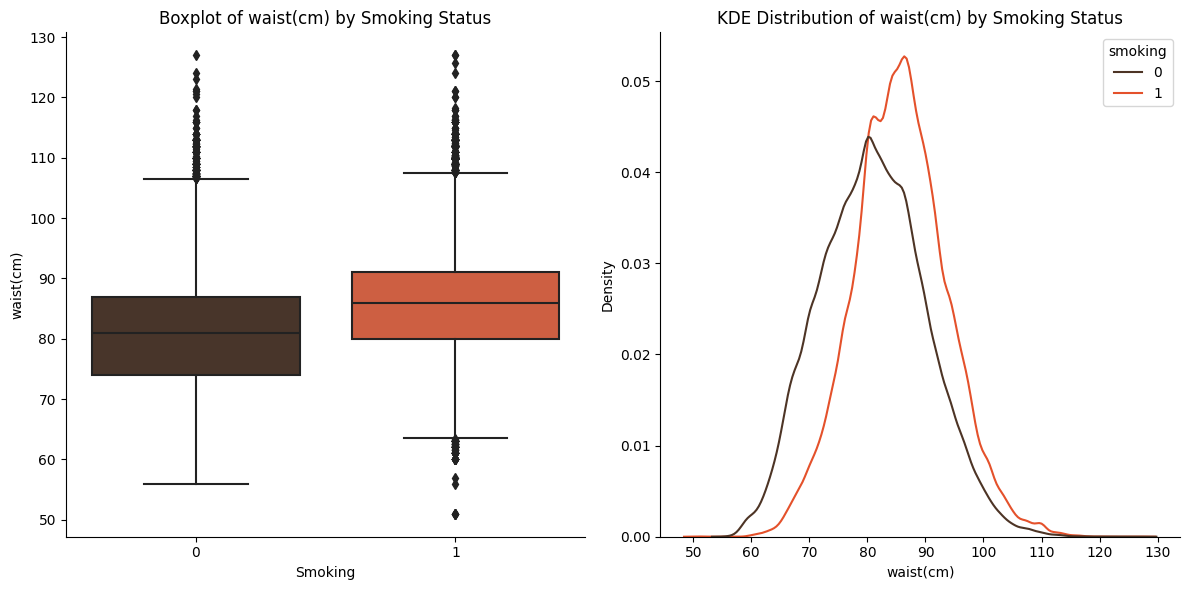

In [ ]:
effect_of_smoking_visualiztion('waist(cm)')

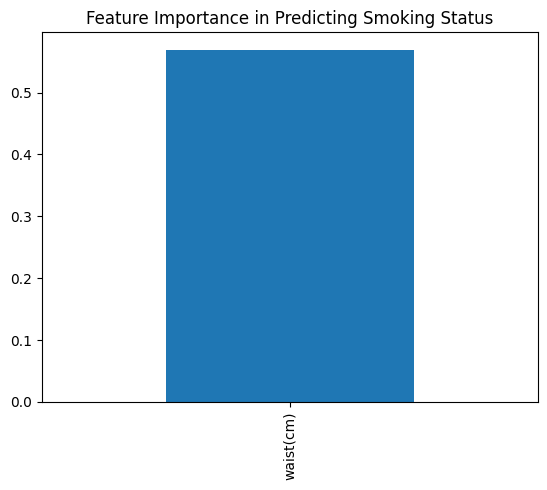

In [ ]:
feature_imp_log_regression('waist(cm)')

In [ ]:
results = test_feature_normality_and_difference(train_df, 'waist(cm)', 'smoking')
print(results)

{'test_performed': 'Mann-Whitney U', 'is_normal': 'No', 'p_value': 0.0, 'conclusion': 'There is a significant difference.'}


With the results provided, we observe a very small p-value (0.0). This suggests that there is significant evidence to reject the null hypothesis. Therefore, we can conclude that there is a significant difference between smokers and non-smokers.

Based on the analysis, we can affirm that in the sample, the waist circumference of smokers is significantly higher than that of non-smokers, which aligns with our initial hypothesis.

##### 6. Observations to consider in feature engineering & data preporcessing

In the case of waist circumference, we have identified the same issues as in the weight feature. There are values that deviate from typical measurements, and we will explore in the multivariate analysis the best way to combine this variable with weight and height to find the most meaningful metric in this model.

#### Feature 5: Eyesight

In this case, we will perform the analysis of the two eyesight features jointly. We assume that the effects of tobacco on eyesight will be identical for both eyes, and therefore, we will combine the two features in the feature engineering section.

##### 1. Medical Description

Although less well-known than the effects on obesity, smoking also affects vision. Numerous studies indicate that smokers may develop serious eye conditions such as cataracts or even blindness. Therefore, a priori, we understand that smokers will have worse vision than non-smokers on average and under equal conditions.

Studies referenced: [CDC - Vision Loss and Blindness](https://www.cdc.gov/tobacco/campaign/tips/diseases/vision-loss-blindness.html)

##### 2. Reasonable values

There are many different ways to measure visual acuity, so the usual values for this metric will largely depend on how they have been collected.

##### 3. Correct Data Types?

In [ ]:
print(train_df['eyesight(left)'].dtypes)
print(train_df['eyesight(right)'].dtypes)

float64
float64


We understand it's reasonable for these features to be recorded as floats given their nature.

##### 4. Values collected in the dataset

Feature: eyesight(left)
Mean: 1.005798211684332
Median: 1.0
Mode: 1.0
Range: 9.8
Variance: 0.16169455233008675
Standard Deviation: 0.40211261150340305
Maximum: 9.9
Minimum: 0.1
Quartiles:
0.25    0.8
0.50    1.0
0.75    1.2
Name: eyesight(left), dtype: float64


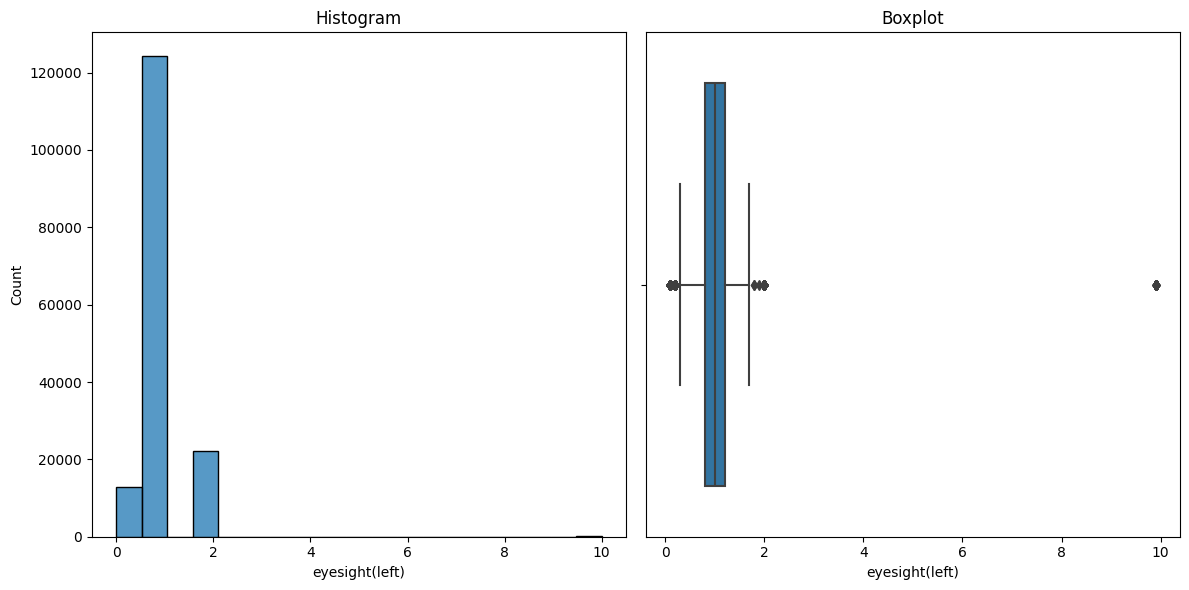

Feature: eyesight(right)
Mean: 1.0009889737278344
Median: 1.0
Mode: 1.0
Range: 9.8
Variance: 0.15389817736752423
Standard Deviation: 0.39229858190863276
Maximum: 9.9
Minimum: 0.1
Quartiles:
0.25    0.8
0.50    1.0
0.75    1.2
Name: eyesight(right), dtype: float64


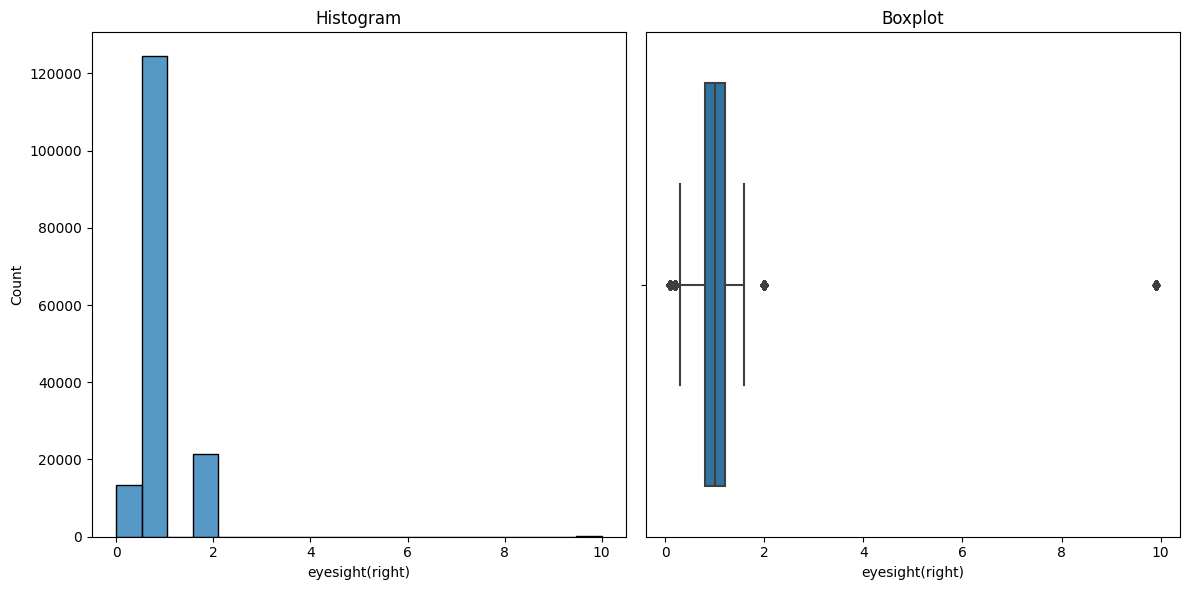

In [ ]:
for i in ['eyesight(left)', 'eyesight(right)']:
    analyze_feature(train_df[i])

In [ ]:
for i in ['eyesight(left)', 'eyesight(right)']:
    print(i, train_df[i].unique())

eyesight(left) [0.5 0.6 0.4 1.5 1.2 0.7 0.8 1.  2.  0.9 0.3 0.1 0.2 9.9 1.9 1.6 1.1 1.8
 1.3 1.7]
eyesight(right) [0.6 0.7 0.5 1.2 1.  0.9 1.5 0.8 0.3 0.2 0.1 2.  0.4 9.9 1.6 1.4 1.3]


Based on what is observed, we can confirm that the vast majority of the sample does not have serious vision problems, which is reasonable. However, there are anomalous values of 9.9 that do not make sense in this case. Therefore, we identify them as outliers.

##### 5. Relationship with smoking

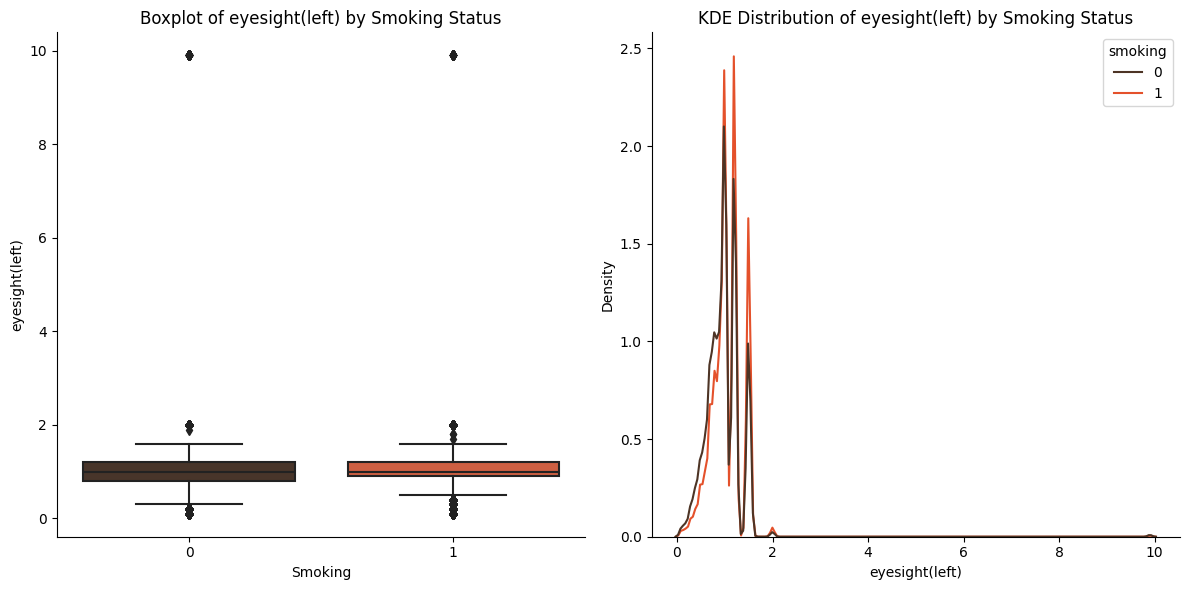

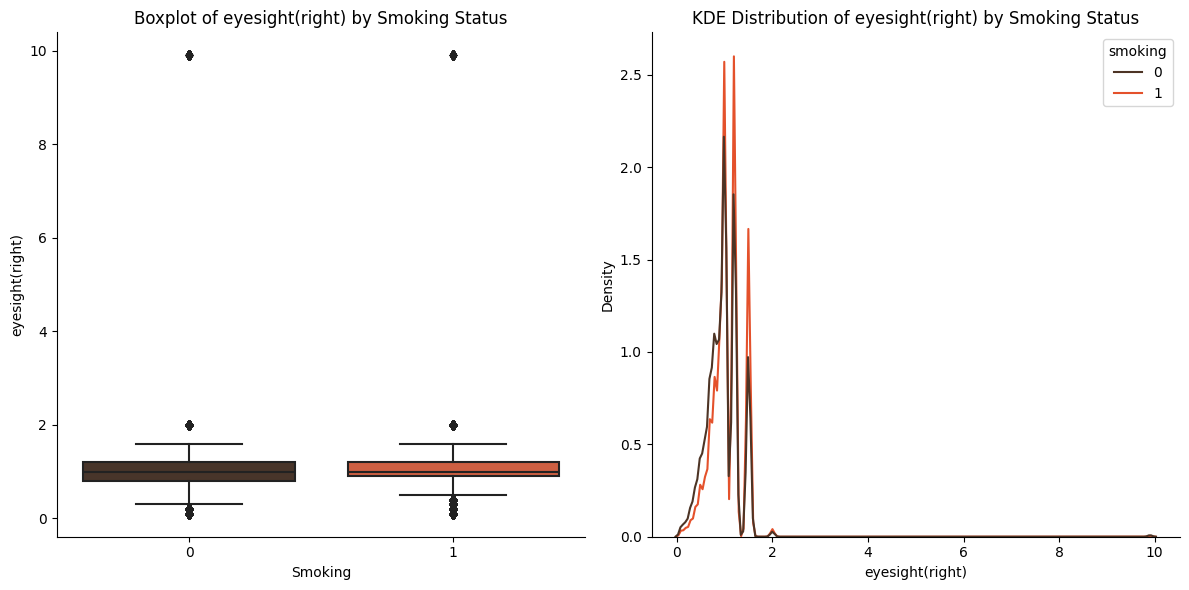

In [ ]:
for i in ['eyesight(left)', 'eyesight(right)']:
    effect_of_smoking_visualiztion(i)

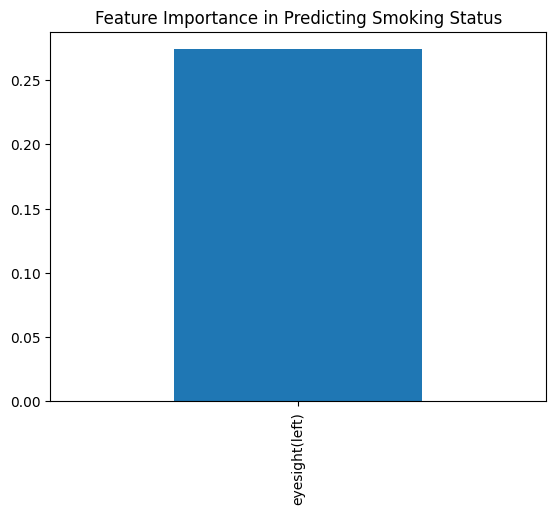

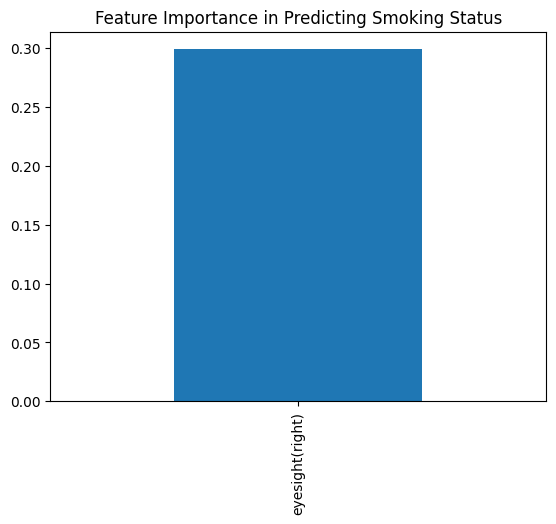

In [ ]:
for i in ['eyesight(left)', 'eyesight(right)']:
    feature_imp_log_regression(i)

In [ ]:
results = test_feature_normality_and_difference(train_df, 'eyesight(left)', 'smoking')
print(results)
results = test_feature_normality_and_difference(train_df, 'eyesight(right)', 'smoking')
print(results)

{'test_performed': 'Mann-Whitney U', 'is_normal': 'No', 'p_value': 0.0, 'conclusion': 'There is a significant difference.'}
{'test_performed': 'Mann-Whitney U', 'is_normal': 'No', 'p_value': 0.0, 'conclusion': 'There is a significant difference.'}


With the results provided, we observe a very small p-value (0.0). This suggests that there is significant evidence to reject the null hypothesis. Therefore, we can conclude that there is a significant difference between smokers and non-smokers.

Based on the graphs represented earlier, we can affirm that in the sample, the visual acuity of smokers is significantly worse than that of non-smokers.

##### 6. Observations to consider in feature engineering & data preporcessing

The results of the relationship between the variable and the smoking condition are reasonable and align with the studies cited in point one.

Furthermore, outliers have been identified that will need to be addressed in the data preprocessing process.

Lastly, in the feature engineering phase, different alternatives should be considered to capture insights from the two variables in the original dataset in a way that gathers the most useful information for the model.

#### Feature 6: Hearing

In this case, we will also perform the analysis of the two hearing features jointly. We assume that the effects of tobacco on the ears will be identical for both sides, and therefore, we will combine the two features in the feature engineering section.

##### 1. Medical Description

Scientific studies clearly indicate that there is a close relationship between hearing problems and smoking. According to some of these studies, smokers are 15% more likely to suffer from hearing loss than non-smokers. This worsening increases to 40% in the case of heavier smokers.

Therefore, we understand that this variable is indeed related to the subject at hand and thus consider it potentially interesting for the model.

Studies referenced: [Smoking and Hearing Loss](https://www.outsideclinic.co.uk/blog/smoking-and-hearing-loss#:~:text=Key%20findings%3A,no%20extra%20risk%20of%20hearing)

##### 2. Reasonable values

In this case, the variable only records whether a person has hearing problems or not, so there should not be more than two unique values.

##### 3. Correct Data Types?

In [ ]:
print(train_df['hearing(left)'].dtypes)
print(train_df['hearing(right)'].dtypes)

int64
int64


We understand it's reasonable for these features to be recorded as integers given their nature.

##### 4. Values collected in the dataset

Feature: hearing(left)
Mean: 1.023973979002361
Median: 1.0
Mode: 1
Range: 1
Variance: 0.023399374262545444
Standard Deviation: 0.15296854010725683
Maximum: 2
Minimum: 1
Quartiles:
0.25    1.0
0.50    1.0
0.75    1.0
Name: hearing(left), dtype: float64


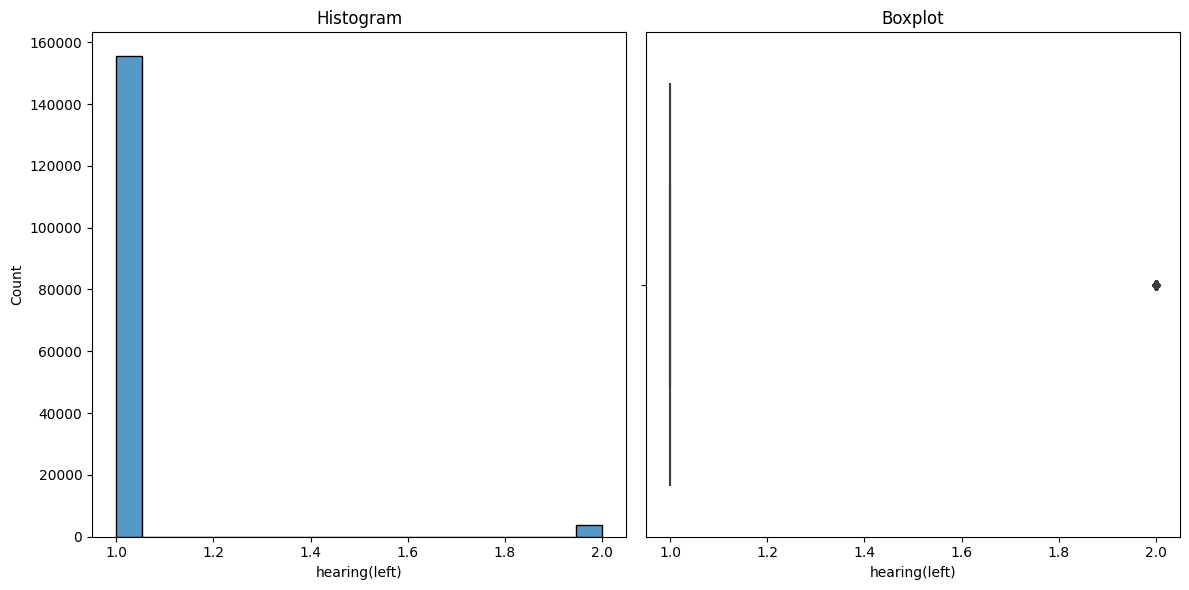

Feature: hearing(right)
Mean: 1.023421409554428
Median: 1.0
Mode: 1
Range: 1
Variance: 0.022872990753007076
Standard Deviation: 0.15123819211101103
Maximum: 2
Minimum: 1
Quartiles:
0.25    1.0
0.50    1.0
0.75    1.0
Name: hearing(right), dtype: float64


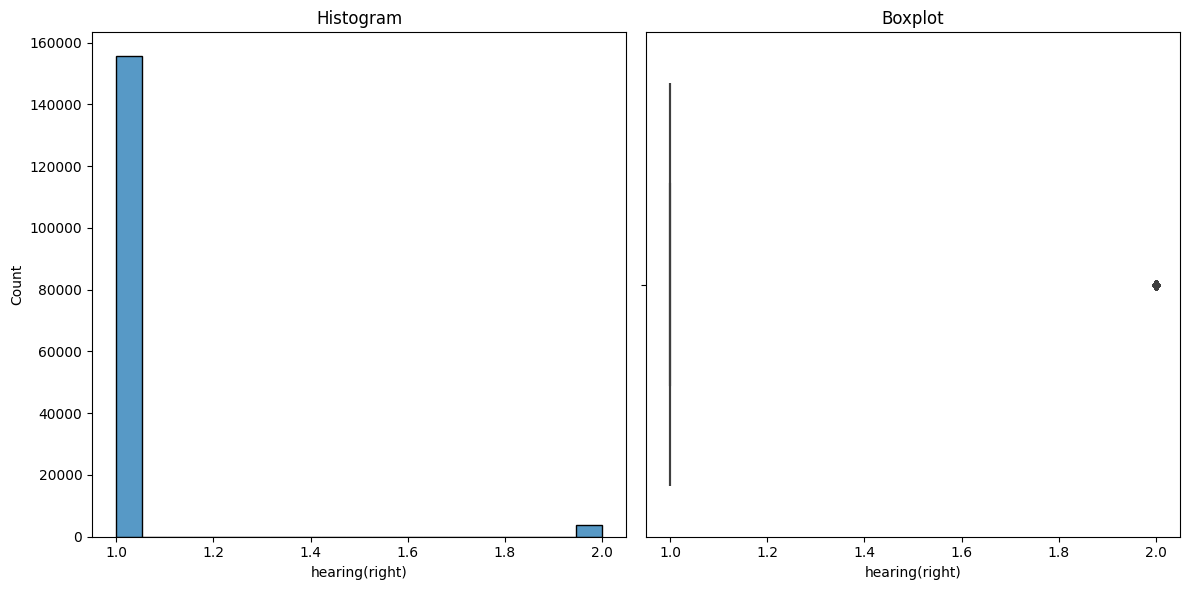

In [ ]:
 for i in ['hearing(left)', 'hearing(right)']:
    analyze_feature(train_df[i])

In this case, the variable only records a value of 2 in cases with hearing problems and a value of 1 if there are no such problems, so the values are reasonable.

##### 5. Relationship with smoking

In this section, we will attempt to determine whether there is a relationship between the hearing variable and smoking using a chi-square test since both variables are categorical.

In [ ]:
def perform_chi_square_test(df, var1, var2):

    # Create a contingency table
    contingency_table = pd.crosstab(df[var1], df[var2])

    # Perform the Chi-square test
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

    # Formulate conclusion
    significant_association = p_value < 0.05
    conclusion = "There is a significant association." if significant_association else "There is no significant association."

    # Return the results
    return {
        'chi2_statistic': chi2,
        'p_value': p_value,
        'conclusion': conclusion
    }


In [ ]:
results = perform_chi_square_test(train_df, 'hearing(left)', 'smoking')
print(results)

{'chi2_statistic': 232.11914223131788, 'p_value': 2.0568471200329436e-52, 'conclusion': 'There is a significant association.'}


In [ ]:
results = perform_chi_square_test(train_df, 'hearing(right)', 'smoking')
print(results)

{'chi2_statistic': 215.8562999432632, 'p_value': 7.248840567862082e-49, 'conclusion': 'There is a significant association.'}


To understand the relationship between hearing problems and smoking status in the sample, we will divide the population into smokers and non-smokers and analyze the percentage of individuals with hearing problems in each group.

In [ ]:
smokers_hearing_left = train_df[train_df['smoking'] == 1]['hearing(left)']
non_smokers_hearing_left = train_df[train_df['smoking'] == 0]['hearing(left)']

smokers_hearing_right = train_df[train_df['smoking'] == 1]['hearing(right)']
non_smokers_hearing_right = train_df[train_df['smoking'] == 0]['hearing(right)']

smokers_hearing = (smokers_hearing_left.sum() + smokers_hearing_right.sum())/(len(smokers_hearing_left) + len(smokers_hearing_right))
non_smokers_hearing = (non_smokers_hearing_left.sum() + non_smokers_hearing_right.sum())/(len(non_smokers_hearing_left) + len(non_smokers_hearing_right))

print(f'The average of the values for smokers is {smokers_hearing}')
print(f'The average of the values for non-smokers is {non_smokers_hearing}')

The average of the values for smokers is 1.017221081647596
The average of the values for non-smokers is 1.0287322969097017


##### 6. Observations to consider in feature engineering & data preporcessing

The results of the sample show that the hearing of non-smokers is worse in the sample than that of smokers. Since there are few cases where there are hearing problems, we believe that the sample data does not reflect the same trend as the entire population, and therefore, this is a variable that should not be included in the model in the feature engineering phase.

#### Feature 7 & 8: Systolic and relaxation blood pressure

##### 1. Medical Description

Understood. We will group the analysis of these variables as they capture the two most common blood pressure measures.

According to various studies, smokers have higher blood pressure due to continuous narrowing of blood vessels.

Studies: [American Heart Association - Smoking, High Blood Pressure, and Your Health](https://www.heart.org/en/health-topics/high-blood-pressure/changes-you-can-make-to-manage-high-blood-pressure/smoking-high-blood-pressure-and-your-health)

##### 2. Reasonable values

Entendido. La hipertensión se diagnostica cuando la presión arterial sistólica es igual o superior a 140 mmHg y la presión arterial diastólica es igual o superior a 90 mmHg. Sin embargo, si la presión arterial supera los 180 mmHg (o la presión diastólica supera los 120 mmHg), esto podría indicar un riesgo de emergencia, como un ataque cardíaco, y se debe buscar atención médica de inmediato.

##### 3. Correct Data Types?

In [ ]:
print(train_df['systolic'].dtypes)
print(train_df['relaxation'].dtypes)

int64
int64


We understand it's reasonable for these features to be recorded as integers given their nature.

##### 4. Values collected in the dataset

Feature: systolic
Mean: 122.503648214196
Median: 121.0
Mode: 130
Range: 136
Variance: 162.0354643834886
Standard Deviation: 12.72931515767791
Maximum: 213
Minimum: 77
Quartiles:
0.25    114.0
0.50    121.0
0.75    130.0
Name: systolic, dtype: float64


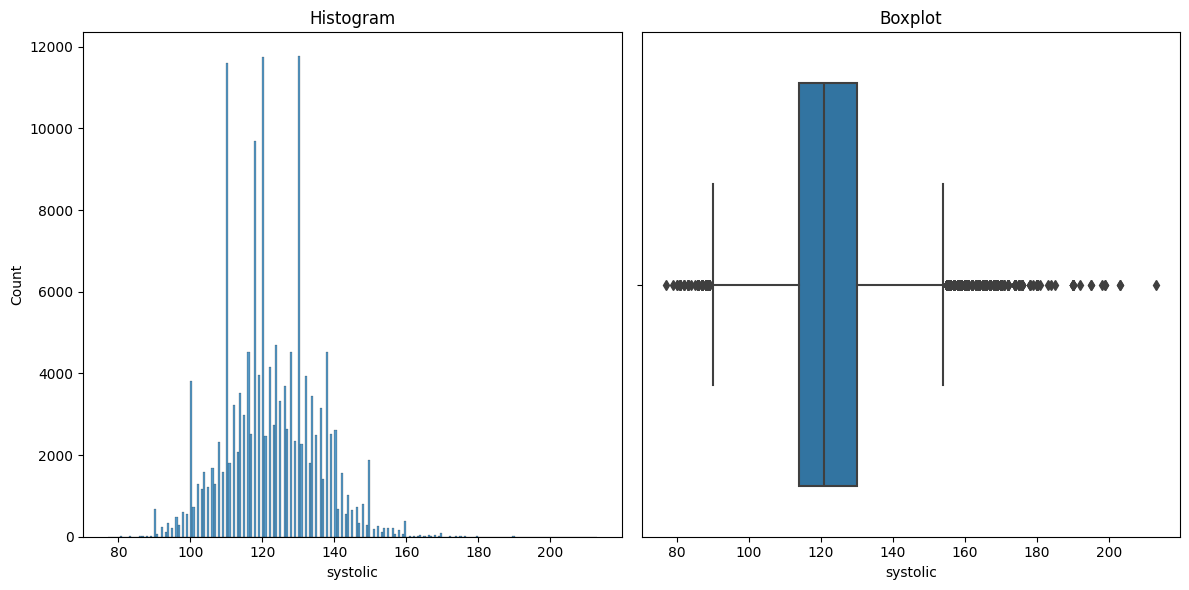

Feature: relaxation
Mean: 76.87407067865576
Median: 78.0
Mode: 80
Range: 89
Variance: 80.90357908675713
Standard Deviation: 8.99464168751358
Maximum: 133
Minimum: 44
Quartiles:
0.25    70.0
0.50    78.0
0.75    82.0
Name: relaxation, dtype: float64


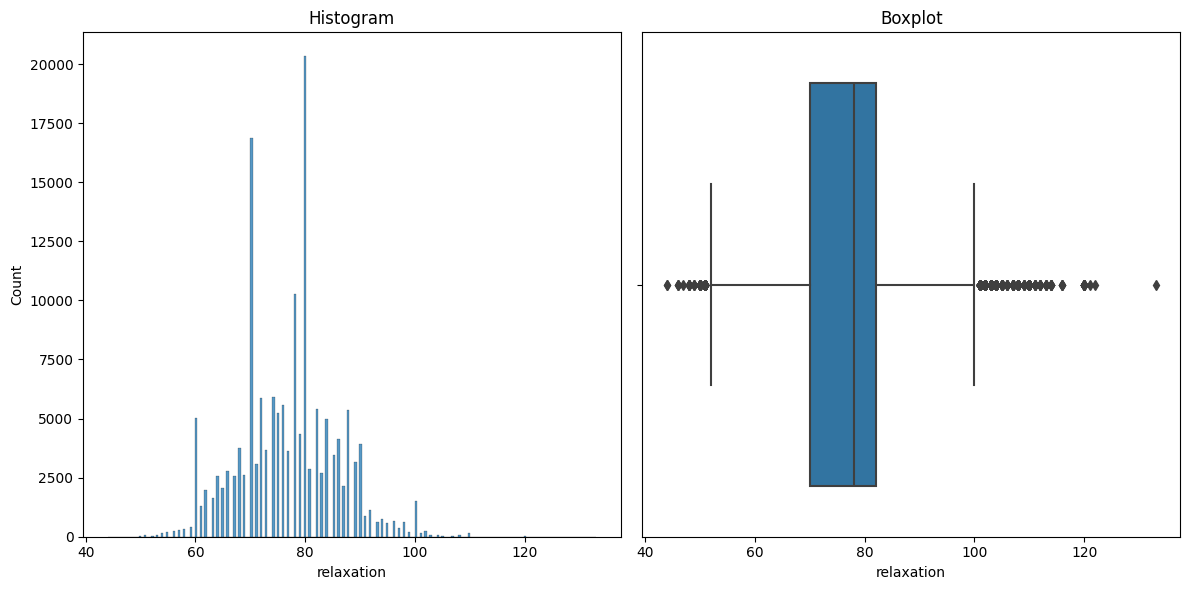

In [ ]:
for i in ['systolic', 'relaxation']:
    analyze_feature(train_df[i])

We see that the dataset includes quite a few cases of hypertension, which are reasonable to include. However, it also includes other values representing cardiac arrest, which we understand we will have to limit in the data preprocessing section.

##### 5. Relationship with smoking

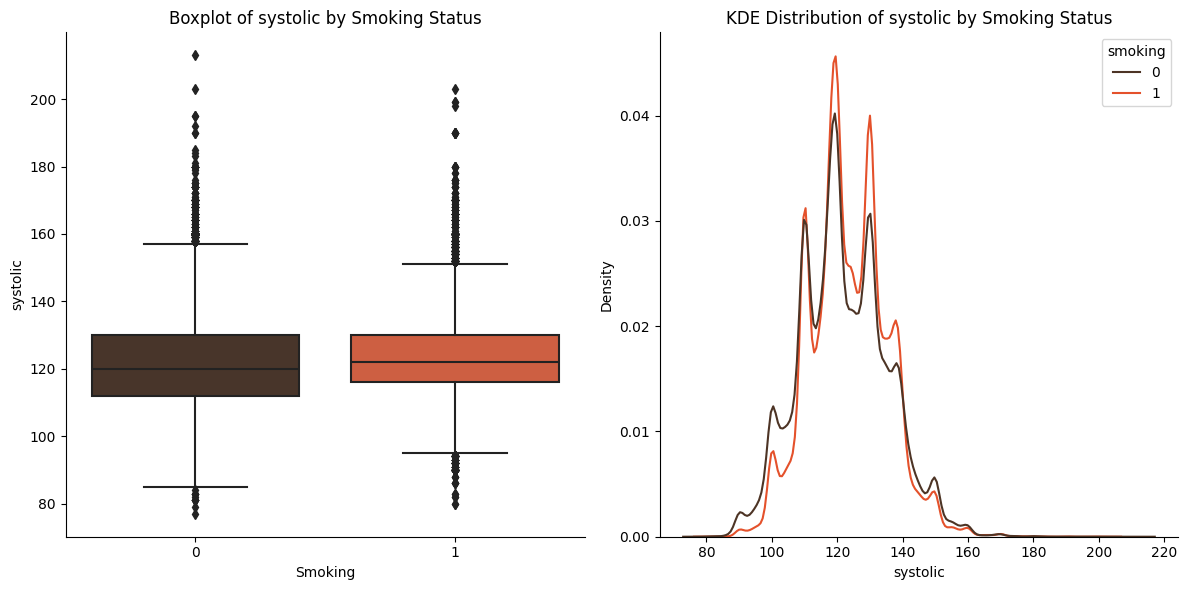

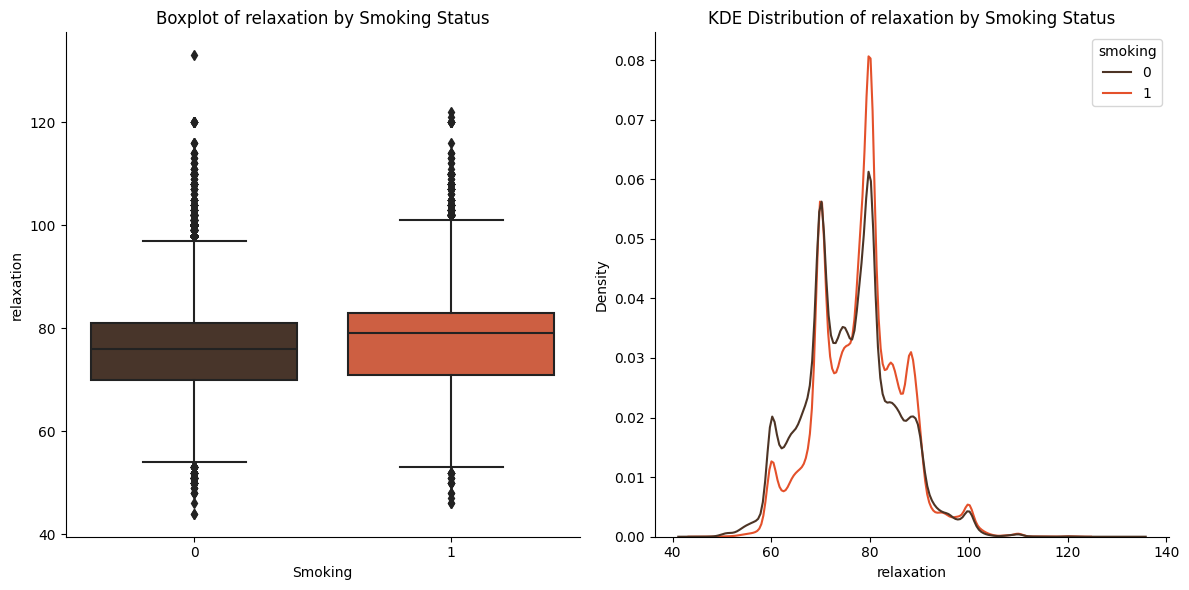

In [ ]:
for i in ['systolic', 'relaxation']:
    effect_of_smoking_visualiztion(i)

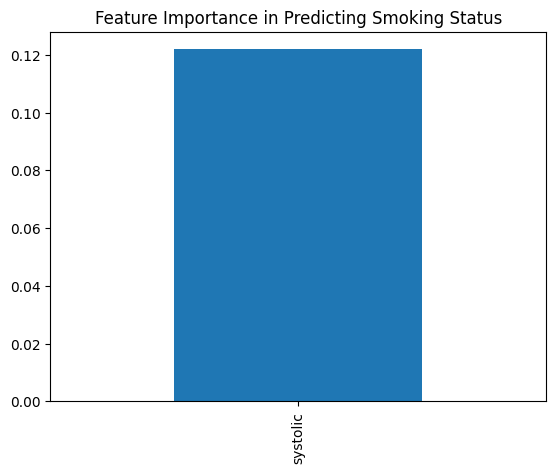

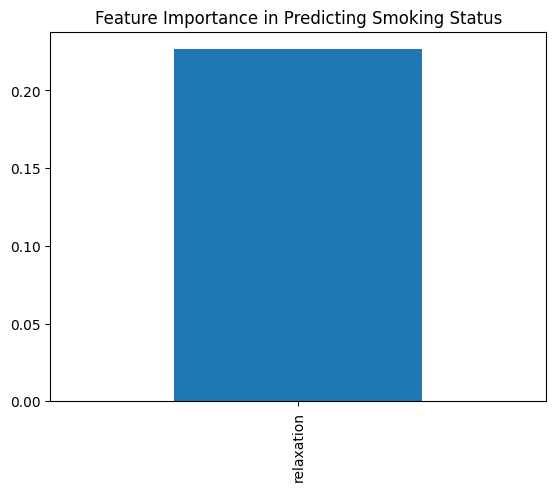

In [ ]:
for i in ['systolic', 'relaxation']:
    feature_imp_log_regression(i)

In [ ]:
results = test_feature_normality_and_difference(train_df, 'systolic', 'smoking')
print(results)
results = test_feature_normality_and_difference(train_df, 'relaxation', 'smoking')
print(results)

{'test_performed': 'Mann-Whitney U', 'is_normal': 'No', 'p_value': 3.4477046650915e-138, 'conclusion': 'There is a significant difference.'}
{'test_performed': 'Mann-Whitney U', 'is_normal': 'No', 'p_value': 0.0, 'conclusion': 'There is a significant difference.'}


With the results provided, we observe a very small p-value (0.0). This suggests that there is significant evidence to reject the null hypothesis. Therefore, we can conclude that there is a significant difference between smokers and non-smokers.

Based on the graphs presented earlier, we can affirm that in the sample, the blood pressure of smokers is significantly higher than that of non-smokers.

##### 6. Observations to consider in feature engineering & data preporcessing

In both variables, significantly high values are observed, which, while potentially real, may confuse the model and make it focus on overly specific cases. We would be referring to data that is capturing cardiac arrests, which we believe should not be used to analyze whether a person smokes or not.

#### Feature 9: Fasting blood sugar

##### 1. Medical Description

Entendido. El efecto del tabaco en el nivel de azúcar en sangre tiene dos razones principales:

1. Desde el punto de vista sociológico, el hábito de fumar tiende a ser más común en personas que llevan un estilo de vida sedentario, lo que también está asociado con un mayor riesgo de enfermedades como la diabetes. Por lo tanto, estos dos factores pueden estar presentes en muchos casos de personas con una vida sedentaria.

2. Desde el punto de vista médico, está demostrado que la nicotina afecta la capacidad de las células humanas para tolerar la insulina, lo que provoca un aumento en los niveles de azúcar en sangre.

Basándonos en este análisis, tiene sentido incluir la variable en el modelo. Veamos qué indican los datos.

Análisis realizado: [CDC - Smoking and Diabetes](https://www.cdc.gov/diabetes/library/features/smoking-and-diabetes.html)

##### 2. Reasonable values

Entendido. Cuando nos referimos a niveles elevados de azúcar en sangre, estamos hablando de problemas de diabetes. Normalmente, se considera que el umbral está en 126, aunque en casos de picos de azúcar, los niveles pueden llegar a valores mucho más altos, como 450, pero solo en situaciones donde no se esté siguiendo el tratamiento adecuado. En nuestra opinión, consideramos que los casos razonables deben situarse por debajo de 200, incluso en situaciones de diabetes.

##### 3. Correct Data Types?

In [ ]:
print(train_df['fasting blood sugar'].dtypes)

int64


Understood. We consider it reasonable that this feature is recorded as an integer due to its nature.

##### 4. Values collected in the dataset

Feature: fasting blood sugar
Mean: 98.35255186617772
Median: 96.0
Mode: 94
Range: 329
Variance: 235.00093323866207
Standard Deviation: 15.329740155614578
Maximum: 375
Minimum: 46
Quartiles:
0.25     90.0
0.50     96.0
0.75    103.0
Name: fasting blood sugar, dtype: float64


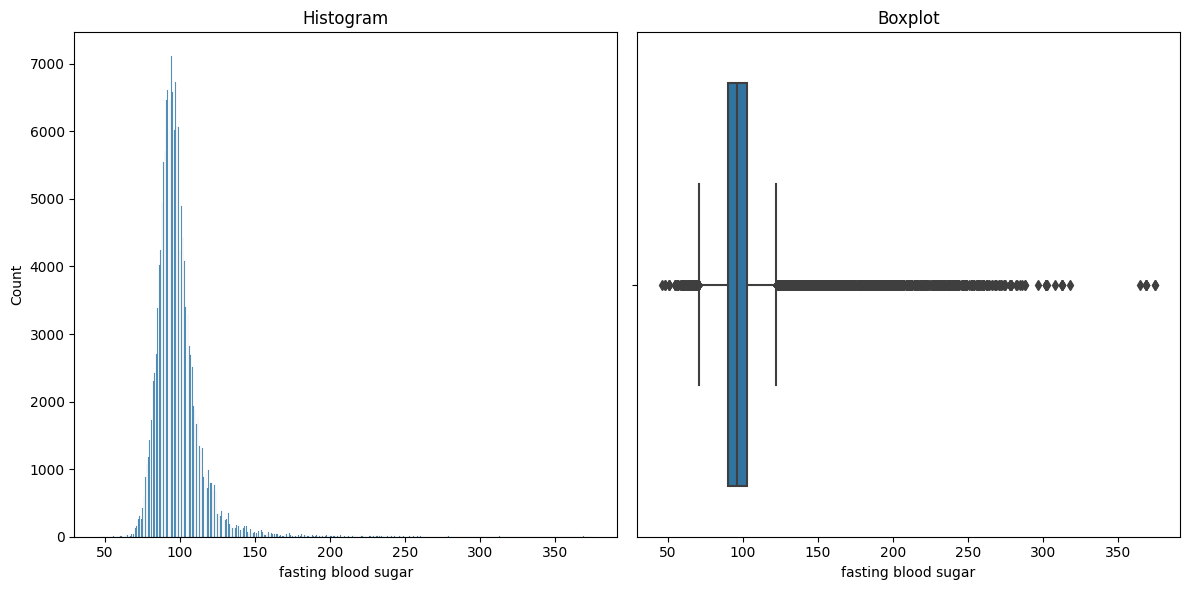

In [ ]:
analyze_feature(train_df['fasting blood sugar'])

##### 5. Relationship with smoking

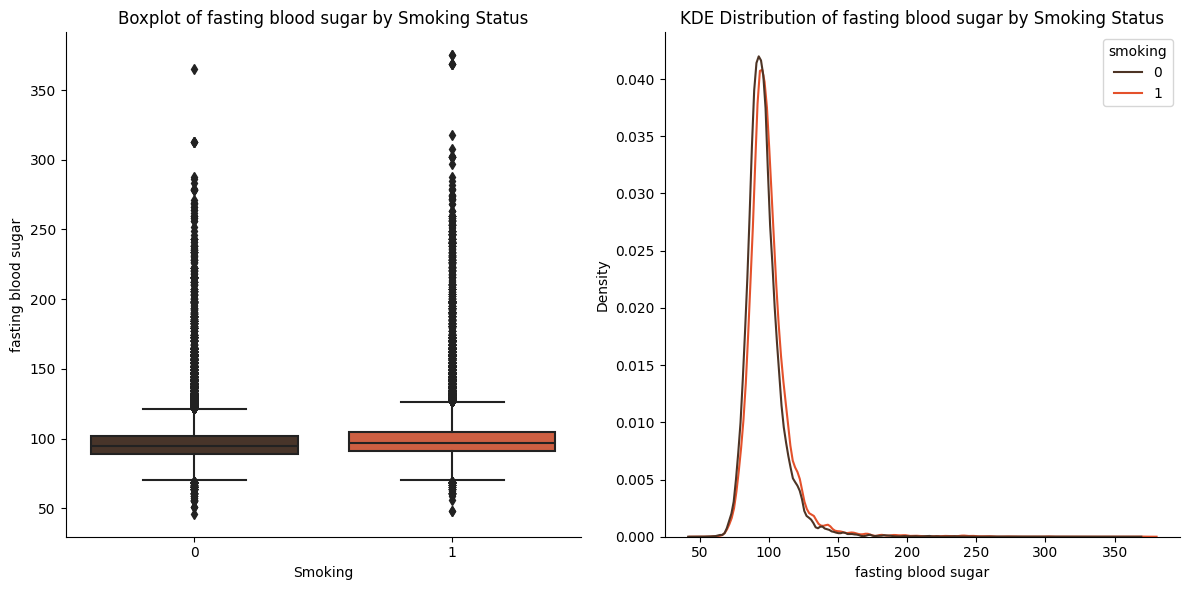

In [ ]:
effect_of_smoking_visualiztion('fasting blood sugar')

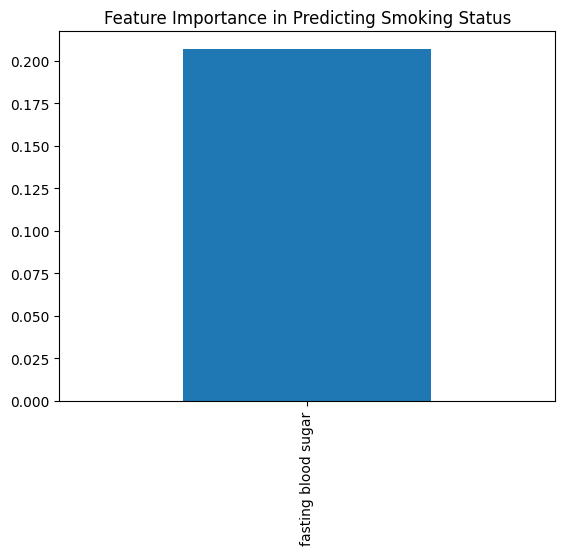

In [ ]:
feature_imp_log_regression('fasting blood sugar')

In [ ]:
results = test_feature_normality_and_difference(train_df, 'fasting blood sugar', 'smoking')
print(results)

{'test_performed': 'Mann-Whitney U', 'is_normal': 'No', 'p_value': 0.0, 'conclusion': 'There is a significant difference.'}


With the provided results, we observe a very small p-value (0.0). This suggests significant evidence to reject the null hypothesis. Therefore, we can conclude that there is a significant difference between smokers and non-smokers.

Based on the graphs presented earlier, we can affirm that in the sample, the amount of blood sugar in smokers is significantly higher than that in non-smokers.

##### 6. Observations to consider in feature engineering & data preporcessing

Based on the previous discussion, we want to highlight that there are extreme threshold values that can limit the learning of the model. Therefore, we consider it appropriate to cap those values to another high value (200) so that they represent appropriate levels but do not deviate too much from the rest of the population.

#### Feature 10, 11, 12 & 13: Cholesterol, triglyceride, HDL & LDL

##### 1. Medical Description

We have decided to group the analysis of these variables because they represent 4 different metrics to measure the quantity and type of fats in the blood. Before explaining what each feature captures, it is worth noting that it is expected for these variables to be related to each other in their data, which will be analyzed in the multivariable analysis section.

Cholesterol: This metric summarizes the three following metrics. It is calculated by adding the following three variables (triglyceride divided by 5).

Triglyceride: This is a type of fat that is not usually a concern, as it is not the worst type of fat. This value is more related to the quality of the diet a person is following than to cholesterol.

HDL: This is a more protective type of cholesterol. Higher HDL indicates a lower risk of heart disease. It is commonly known as "good" cholesterol.

LDL: Known as "bad" cholesterol. The lower, the better.

In terms of the medical relevance of these metrics, many studies link smoking to an increase in LDL and a decrease in HDL due to its effect on blood plaques. As we have mentioned in other variables related to obesity and sedentary lifestyle, triglycerides are also related in this case due to the number of smokers among obese or sedentary individuals.

Studies referenced: https://www.medicalnewstoday.com/articles/does-smoking-cause-high-cholesterol

##### 2. Reasonable values

Cholesterol: The values for a healthy individual should not exceed 200, although values up to 240 are also common. Higher values are possible, but there comes a point where these values are extreme cases that will not be useful for the model.

Triglyceride: Normal levels are below 150, but cases of 200 or even 500 or higher can occur.

HDL: Normal levels range between 40-70. If it is above 60, it is considered good, indicating a lower risk of obesity (smoking).

LDL: For a healthy individual, this value should be below 130, as health problems can start above this threshold. Extreme cases can occur, but, as mentioned earlier, values of 200 should not be included in the model to avoid confusion.

##### 3. Correct Data Types?

In [ ]:
print(train_df['Cholesterol'].dtypes)
print(train_df['triglyceride'].dtypes)
print(train_df['HDL'].dtypes)
print(train_df['LDL'].dtypes)

int64
int64
int64
int64


It is important to note that cholesterol metrics (Cholesterol, Triglyceride, HDL, and LDL) are numerical values that are typically recorded as integers. This is due to the nature of the measurements and the units in which they are expressed, which do not require decimals to accurately represent the concentration of these substances in the blood. Therefore, it is reasonable for these features to be recorded as integers in the dataset.

##### 4. Values collected in the dataset

Feature: Cholesterol
Mean: 195.79616466569547
Median: 196.0
Mode: 197
Range: 316
Variance: 806.3872851551106
Standard Deviation: 28.396959082886156
Maximum: 393
Minimum: 77
Quartiles:
0.25    175.0
0.50    196.0
0.75    217.0
Name: Cholesterol, dtype: float64


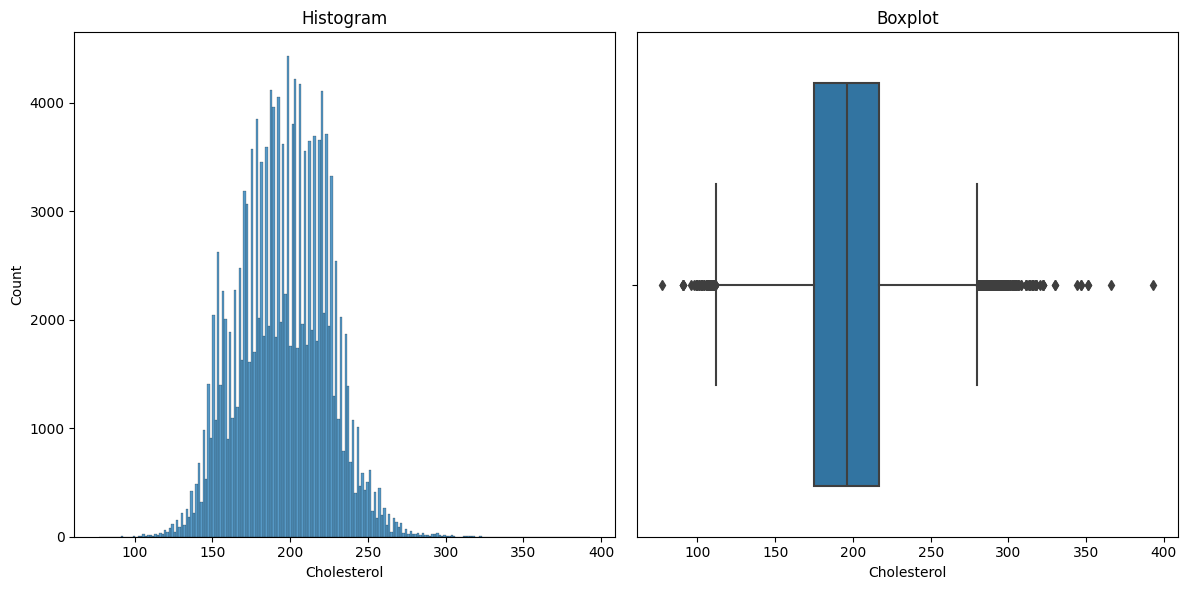

Feature: triglyceride
Mean: 127.61604586326418
Median: 115.0
Mode: 82
Range: 758
Variance: 4380.982282229765
Standard Deviation: 66.18898913134846
Maximum: 766
Minimum: 8
Quartiles:
0.25     77.0
0.50    115.0
0.75    165.0
Name: triglyceride, dtype: float64


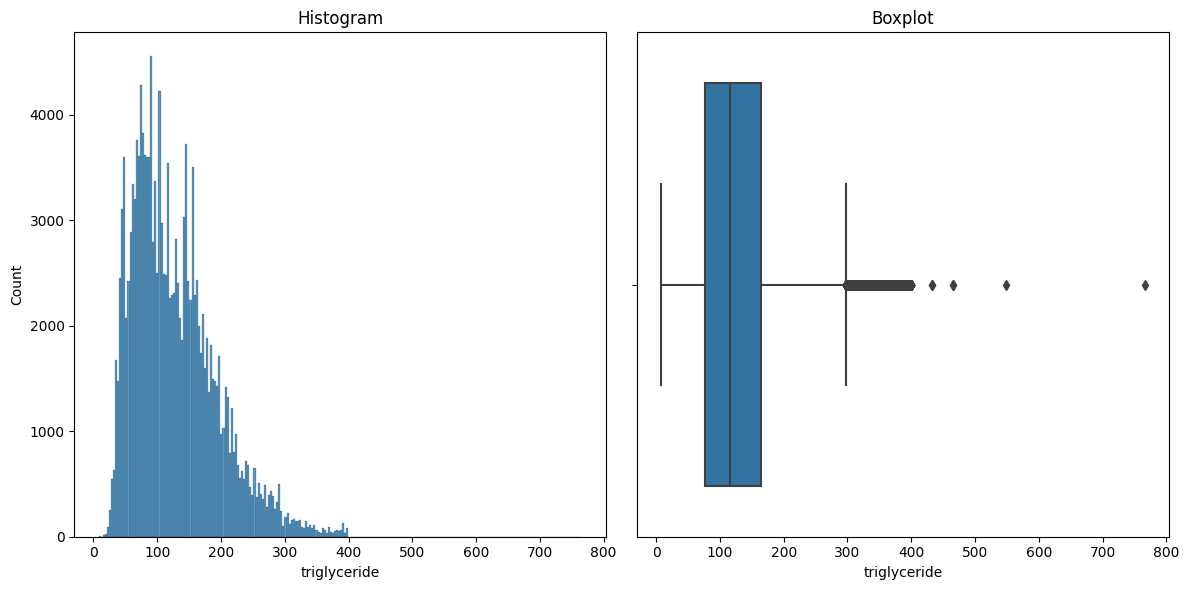

Feature: HDL
Mean: 55.852683729341436
Median: 54.0
Mode: 47
Range: 127
Variance: 194.99723596103698
Standard Deviation: 13.964141074947538
Maximum: 136
Minimum: 9
Quartiles:
0.25    45.0
0.50    54.0
0.75    64.0
Name: HDL, dtype: float64


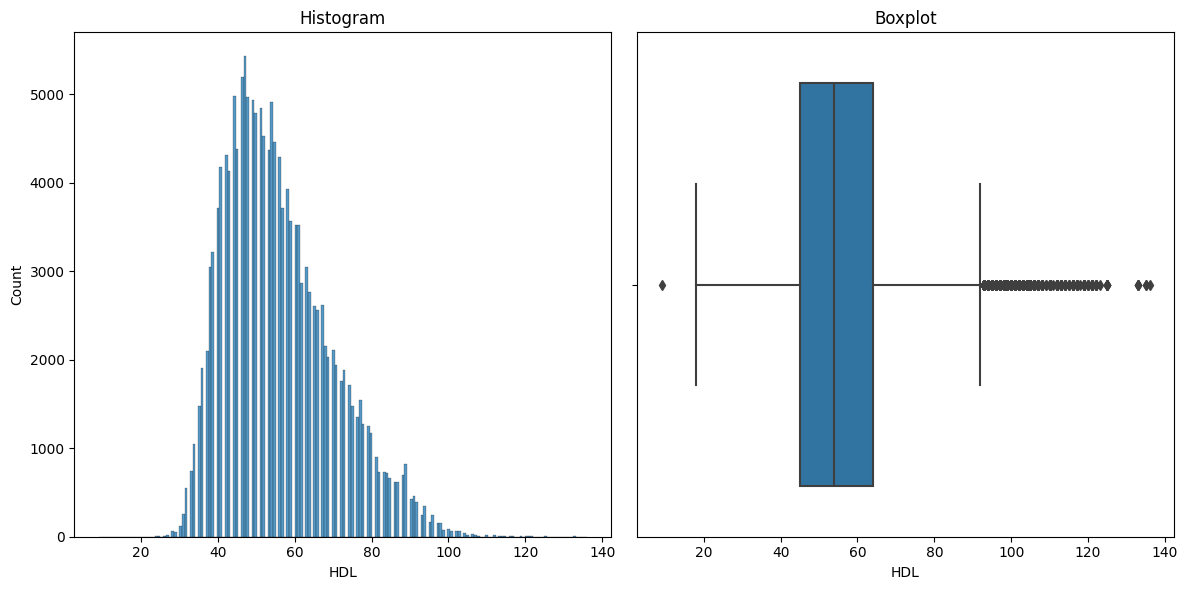

Feature: LDL
Mean: 114.60768197116592
Median: 114.0
Mode: 112
Range: 1859
Variance: 792.9254174868599
Standard Deviation: 28.158931398170278
Maximum: 1860
Minimum: 1
Quartiles:
0.25     95.0
0.50    114.0
0.75    133.0
Name: LDL, dtype: float64


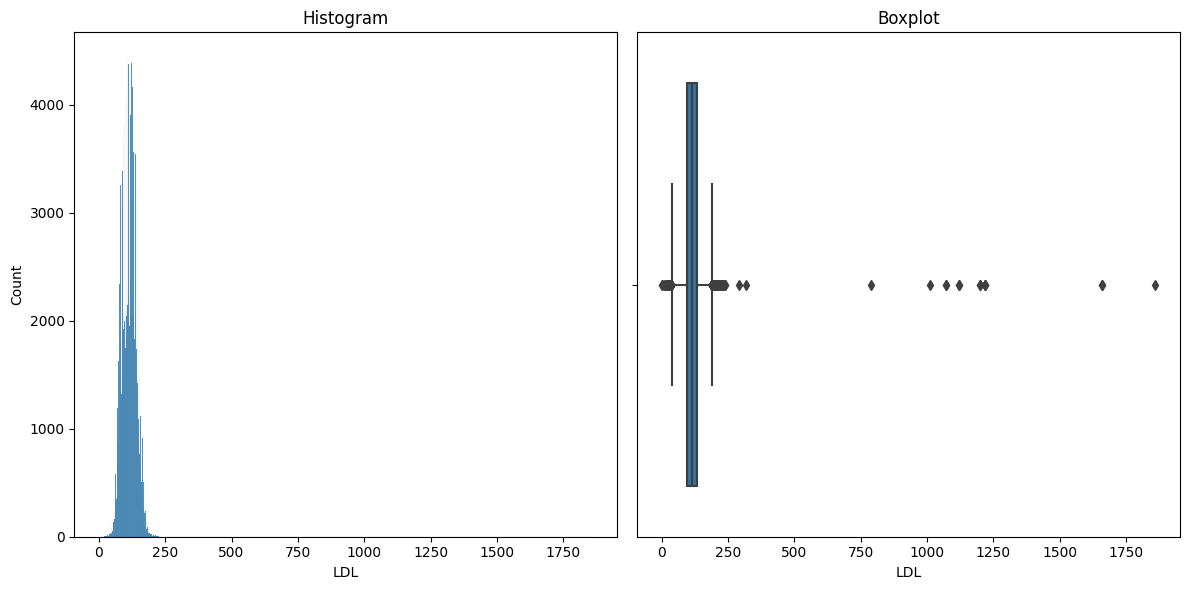

In [ ]:
for feature in ['Cholesterol', 'triglyceride', 'HDL', 'LDL']:
    analyze_feature(train_df[feature])

Limiting the extreme values of cholesterol metrics (Cholesterol, Triglyceride, HDL, and LDL) is a prudent decision to prevent them from disproportionately influencing the model and affecting its predictive capability. By setting reasonable limits for these values, we can ensure that the model focuses on more representative and relevant patterns for predicting smoking status. This will help improve the robustness and generalization of the model.

##### 5. Relationship with smoking

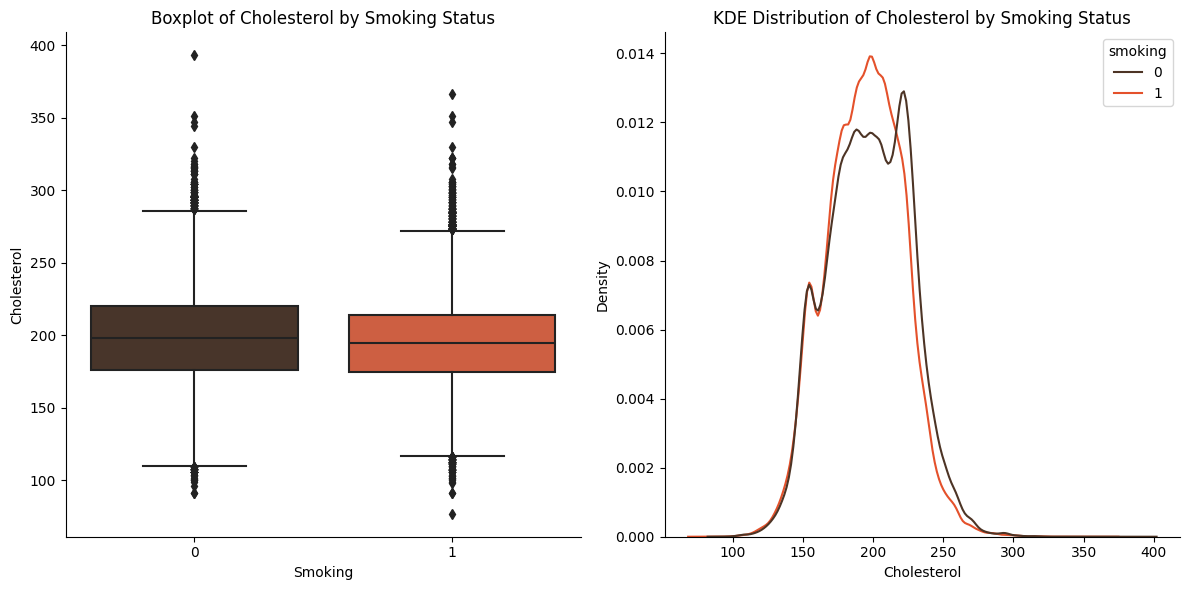

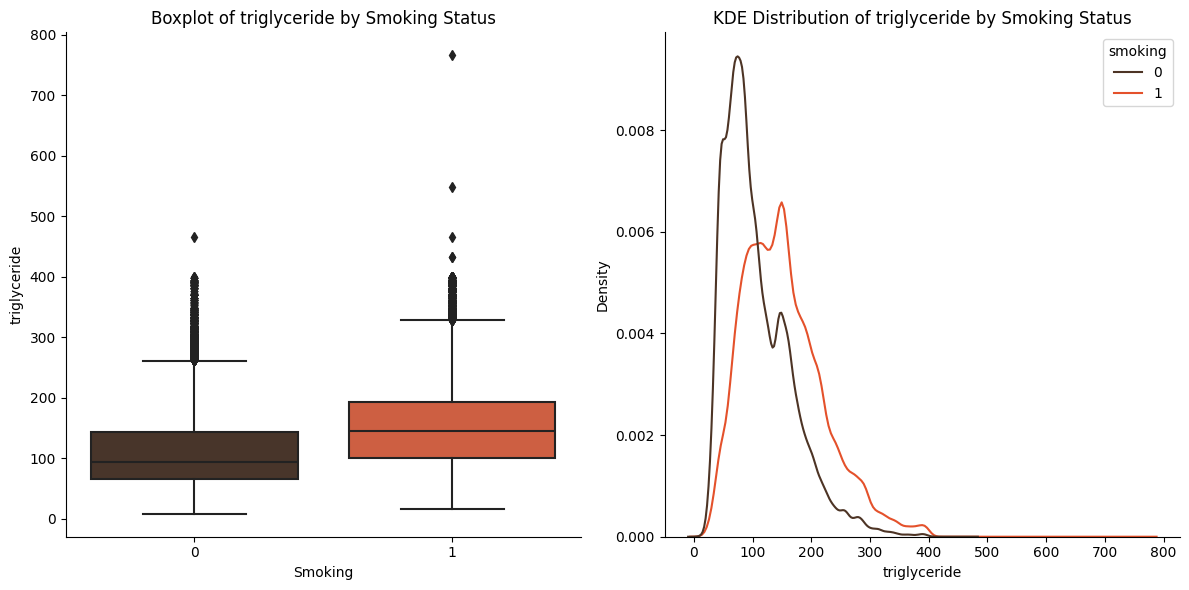

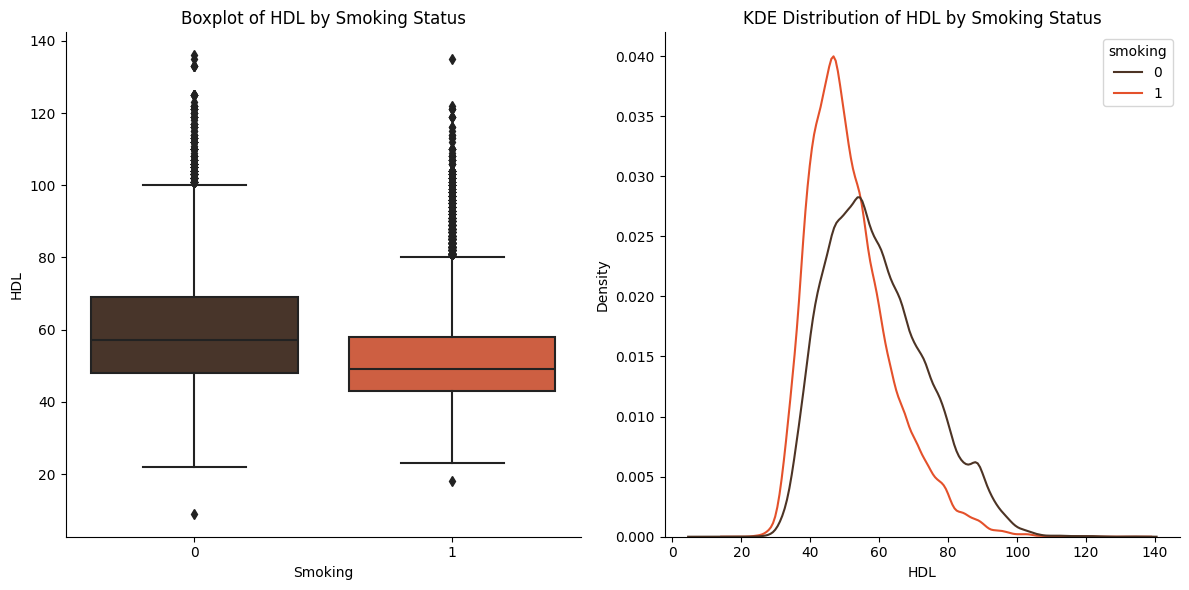

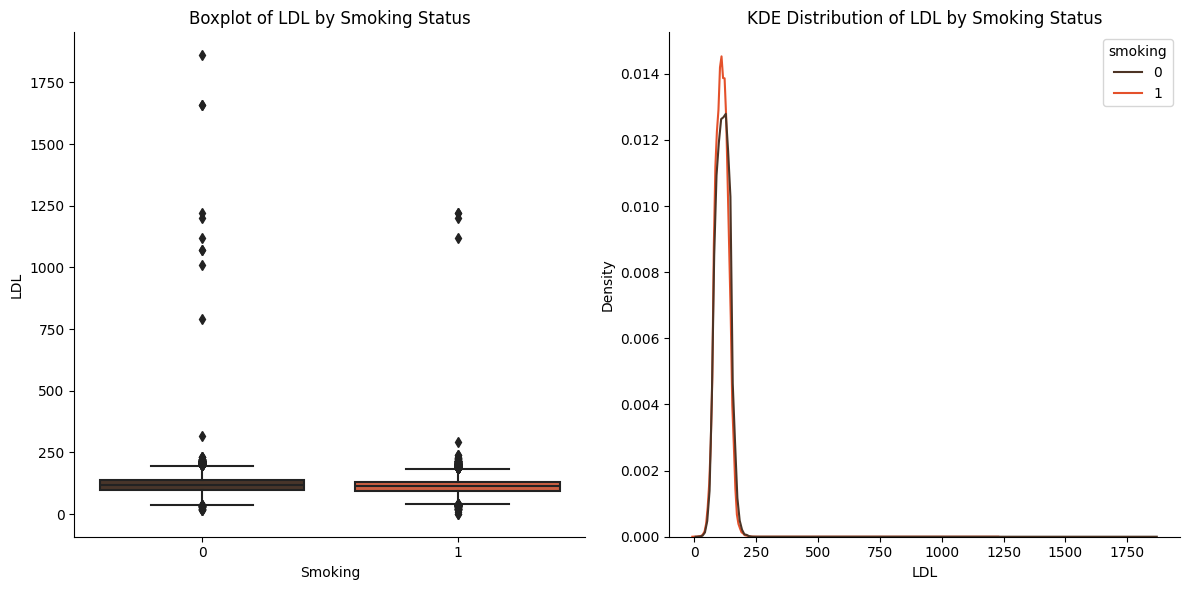

In [ ]:
for i in ['Cholesterol', 'triglyceride', 'HDL', 'LDL']:
    effect_of_smoking_visualiztion(i)

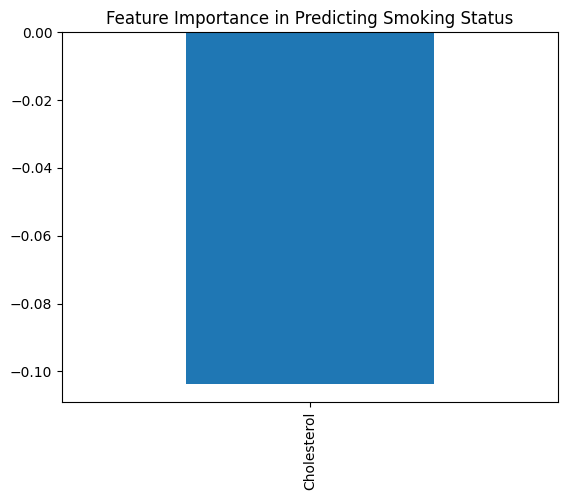

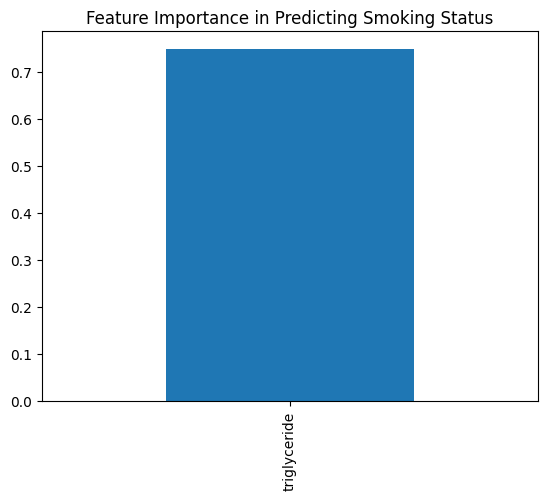

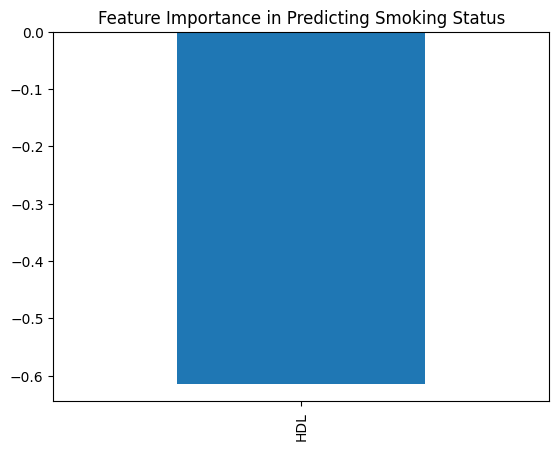

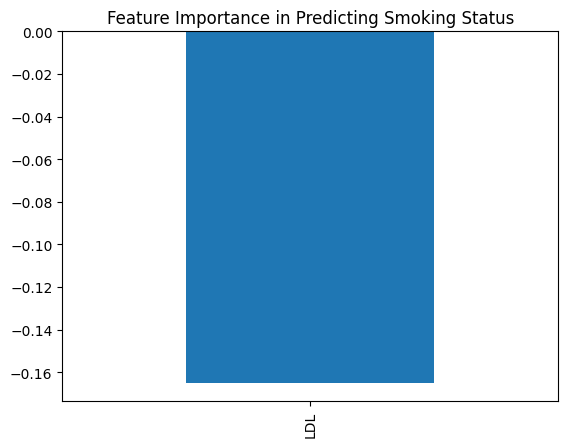

In [ ]:
for i in ['Cholesterol', 'triglyceride', 'HDL', 'LDL']:
    feature_imp_log_regression(i)

In [ ]:
for i in ['Cholesterol', 'triglyceride', 'HDL', 'LDL']:
    results = test_feature_normality_and_difference(train_df, i, 'smoking')
    print(results)

{'test_performed': 'Mann-Whitney U', 'is_normal': 'No', 'p_value': 1.2350890118419642e-93, 'conclusion': 'There is a significant difference.'}
{'test_performed': 'Mann-Whitney U', 'is_normal': 'No', 'p_value': 0.0, 'conclusion': 'There is a significant difference.'}
{'test_performed': 'Mann-Whitney U', 'is_normal': 'No', 'p_value': 0.0, 'conclusion': 'There is a significant difference.'}
{'test_performed': 'Mann-Whitney U', 'is_normal': 'No', 'p_value': 1.4107382661083765e-192, 'conclusion': 'There is a significant difference.'}


With the provided results, we observe a very small p-value (0.0). This suggests that there is significant evidence to reject the null hypothesis. Therefore, we can conclude that there is a significant difference between smokers and non-smokers.

Based on the comprehensive analysis, we can affirm that all cholesterol measures vary significantly between smokers and non-smokers.

##### 6. Observations to consider in feature engineering & data preporcessing

As mentioned, the 4 variables have extreme values that may confuse the model and it would be advisable to limit them when transforming the dataset.

On the other hand, when analyzing the effect of the variables among themselves in the multivariate analysis, it would be worth considering whether it makes sense to include the general cholesterol variable since it is a value obtained from the sum of the other variables.

#### Feature 14: Hemoglobin

##### 1. Medical Description

Hemoglobin: It is a protein present in red blood cells that carries oxygen. Because the lungs of smokers are often affected, gas exchange is less efficient, resulting in lower levels of oxygen in the blood. In response to this situation, the body tends to produce more hemoglobin to try to compensate for the oxygen deficiency. Additionally, nicotine can increase hemoglobin levels, making the blood more viscous. Taking all these factors into account, we believe this variable may be relevant in a model aimed at classifying individuals as smokers or non-smokers.

Studies analyzed:

- https://pesquisa.bvsalud.org/portal/resource/pt/lil-442805
- https://www.sciencedirect.com/science/article/pii/S0300289615304014

##### 2. Reasonable values

It has been observed in studies that the average hemoglobin level in smokers is 15 and in non-smokers is 14.8. It is dependent on the number of cigarettes consumed. For women, the range is 12-15, and for men, it is 13-17. Anemia is indicated by levels below 9, and a value of 5 could indicate severe iron deficiency. Values above the curve would be considered extreme starting from 25.

##### 3. Correct Data Types?

In [ ]:
print(train_df['hemoglobin'].dtypes)

float64


The sample collects hemoglobin data as integers, already rounded values. This criterion has no effect at the aggregate level.

##### 4. Values collected in the dataset

Feature: hemoglobin
Mean: 14.796965263475157
Median: 15.0
Mode: 15.6
Range: 16.1
Variance: 2.0483708725737713
Standard Deviation: 1.4312130772787717
Maximum: 21.0
Minimum: 4.9
Quartiles:
0.25    13.8
0.50    15.0
0.75    15.8
Name: hemoglobin, dtype: float64


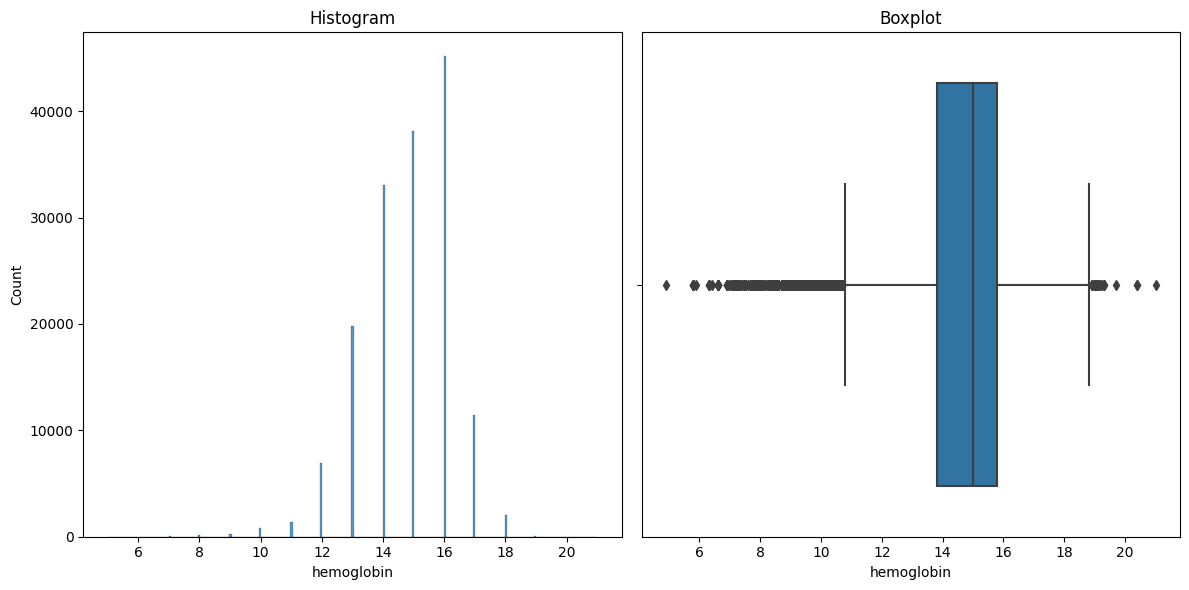

In [ ]:
analyze_feature(train_df['hemoglobin'])

In this case, the sample contains values indicating anemia but no cases above the extreme limit we estimated. We also observe that the mode closely resembles the values obtained in the medical study mentioned earlier.

##### 5. Relationship with smoking

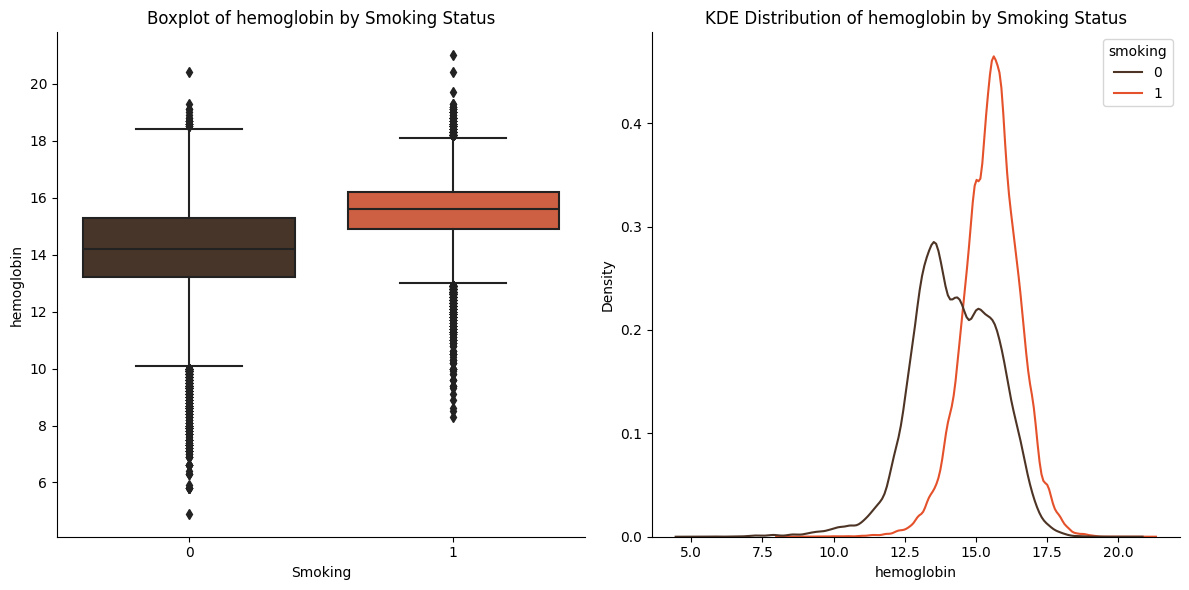

In [ ]:
effect_of_smoking_visualiztion('hemoglobin')

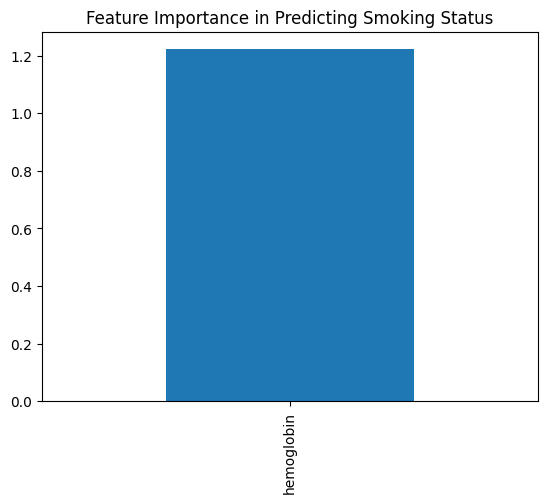

In [ ]:
feature_imp_log_regression('hemoglobin')

In [ ]:
results = test_feature_normality_and_difference(train_df, 'hemoglobin', 'smoking')
print(results)

{'test_performed': 'Mann-Whitney U', 'is_normal': 'No', 'p_value': 0.0, 'conclusion': 'There is a significant difference.'}


With the provided results, we observe a very small p-value (0.0). This suggests that there is significant evidence to reject the null hypothesis. Therefore, we can conclude that there is a significant difference between smokers and non-smokers.

Based on the analysis, we can affirm that the hemoglobin levels of smokers are significantly higher than those of non-smokers, which aligns with our initial hypothesis.

##### 6. Observations to consider in feature engineering & data preporcessing

The text you provided is well-written and clear. It states that no extraordinary situations have been identified in the following steps, and it affirms that the feature should be included in the model as it captures differences between smokers and non-smokers.

#### Feature 15 & 16: Urine protein & serum creatinine

##### 1. Medical Description

Grouping the analysis of these two variables, as they are related to kidney function.

Protein in the urine (also called proteinuria) is the presence of excess blood proteins in the urine. Protein is one of the substances determined in a laboratory test to analyze urine content (urinalysis). When a kidney deteriorates, it tends to lose blood proteins in the urine.

On the other hand, Serum Creatinine is a good metric of kidney function. Creatinine is a waste product in your blood that comes from your muscles. Healthy kidneys filter creatinine out of your blood through your urine.

It is proven that tobacco negatively affects kidney function and these two specific features, so we believe they can be relevant for the model.

Studies analyzed:

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3342637/#:~:text=Conclusions,eGFR%20showed%20proteinuria%20most%20frequently.

https://karger.com/ajn/article/46/4/257/33583/Tobacco-Use-A-Chronic-Kidney-Disease-Accelerant

https://www.mayoclinic.org/es/symptoms/protein-in-urine/basics/definition/sym-20050656#:~:text=Las%20prote%C3%ADnas%20en%20la%20orina,orina%20(an%C3%A1lisis%20de%20orina).

##### 2. Reasonable values

Urine protein: Normal values range from 0 to 8 mg/dL (values recorded multiplied by 10). Starting from 40, it includes cases of severe kidney failure, which would be the limit.

Serum creatinine: High levels are above 1.3 in men and 1.2 in women. The threshold to start dialysis is at 4, which is considered severe kidney failure.

##### 3. Correct Data Types?

In [ ]:
print(train_df['Urine protein'].dtypes)
print(train_df['serum creatinine'].dtypes)

int64
float64


The sample records Urine Protein data as integers, which are already rounded values. This criterion does not have an aggregate effect. Regarding Serum Creatinine, the values are recorded as floats, which makes sense given the nature of the metric.

##### 4. Values collected in the dataset

Feature: Urine protein
Mean: 1.0742326819711658
Median: 1.0
Mode: 1
Range: 5
Variance: 0.1210035555163696
Standard Deviation: 0.3478556532764267
Maximum: 6
Minimum: 1
Quartiles:
0.25    1.0
0.50    1.0
0.75    1.0
Name: Urine protein, dtype: float64


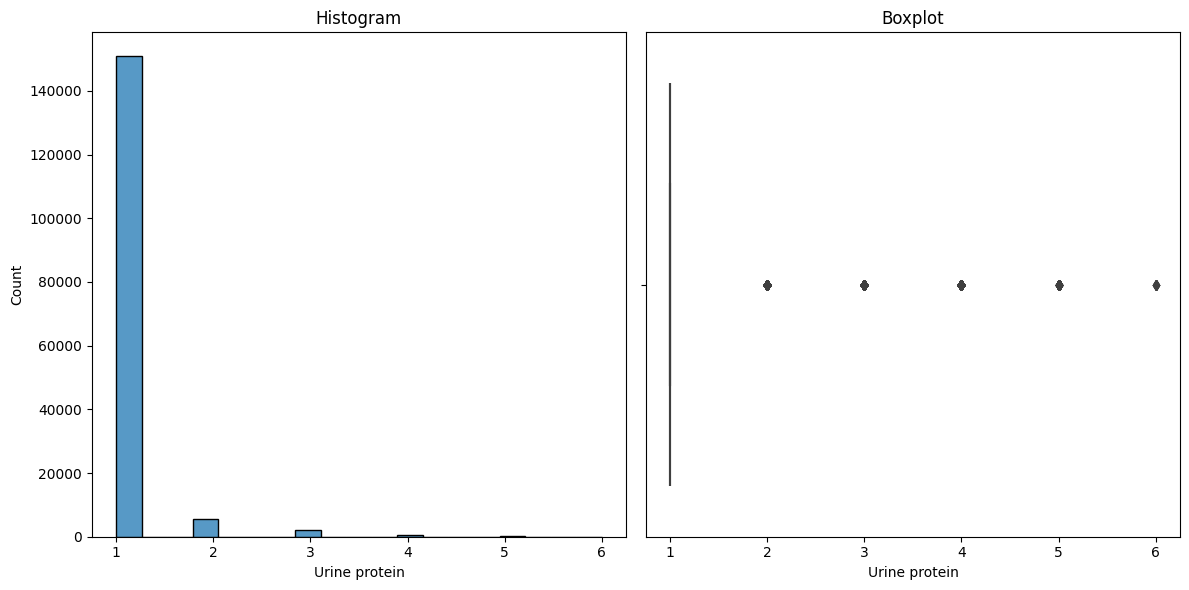

Feature: serum creatinine
Mean: 0.8927644798312152
Median: 0.9
Mode: 0.9
Range: 9.8
Variance: 0.03216497133594667
Standard Deviation: 0.179345954333926
Maximum: 9.9
Minimum: 0.1
Quartiles:
0.25    0.8
0.50    0.9
0.75    1.0
Name: serum creatinine, dtype: float64


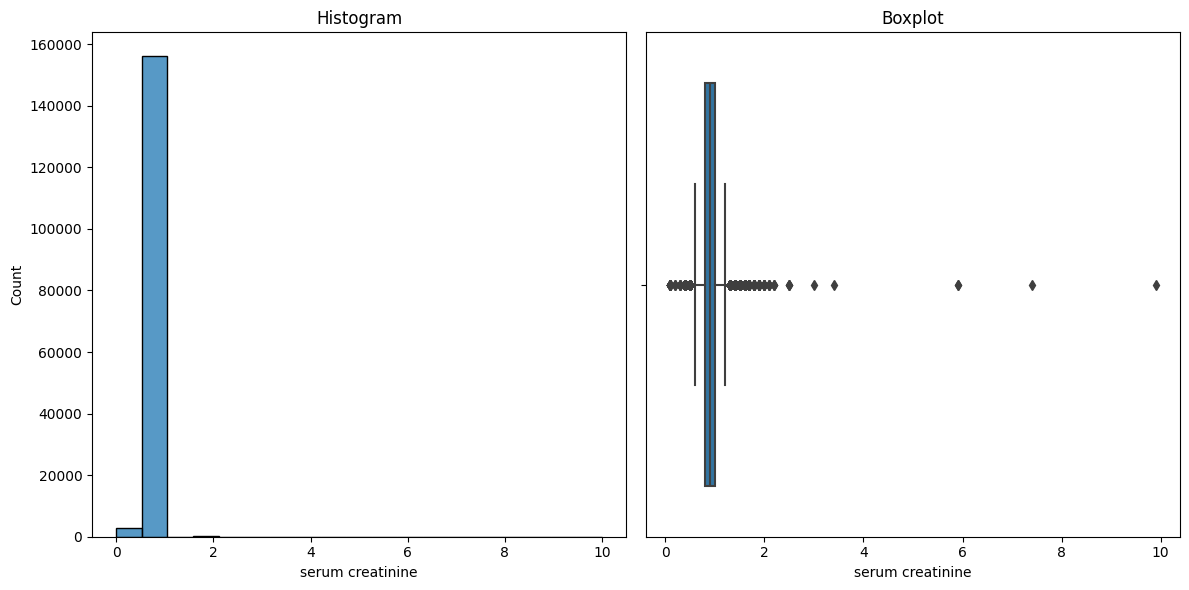

In [ ]:
for i in ['Urine protein', 'serum creatinine']:
    analyze_feature(train_df[i])

We can see that the majority of values follow the parameters we have established as "normal". However, there are also cases of people in a situation of severe renal failure, which are extreme cases. It would be advisable to limit these values so that they do not affect the model.

##### 5. Relationship with smoking

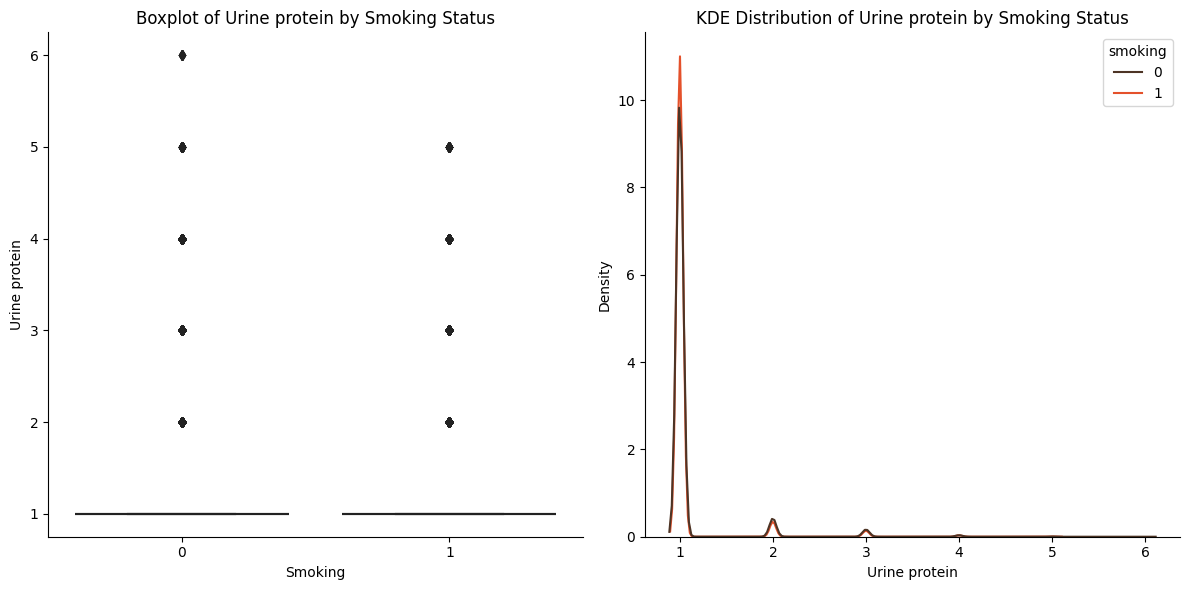

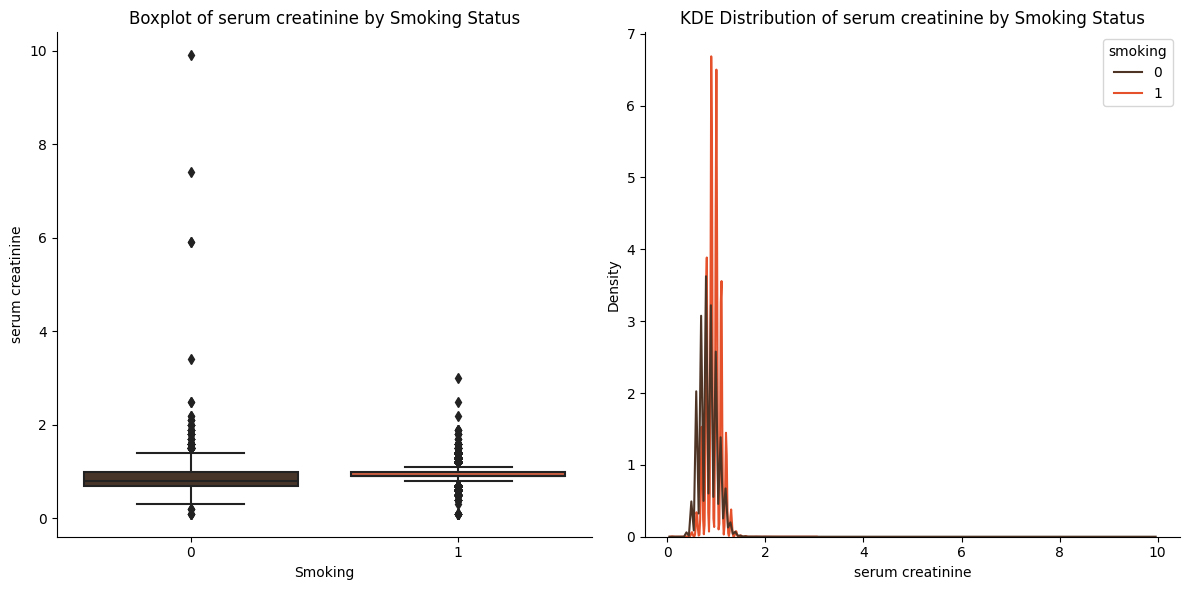

In [ ]:
for i in ['Urine protein', 'serum creatinine']:
    effect_of_smoking_visualiztion(i)

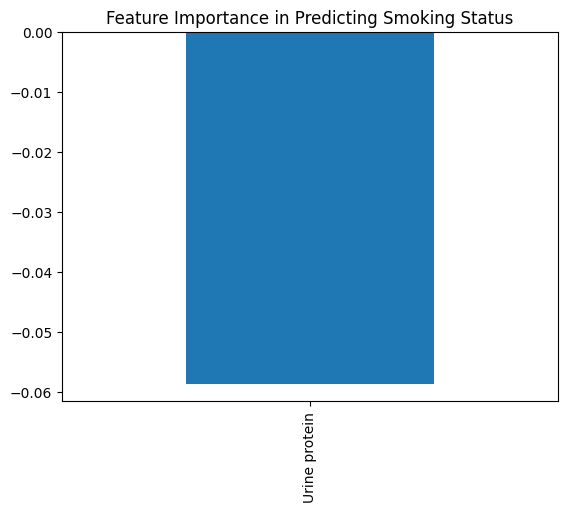

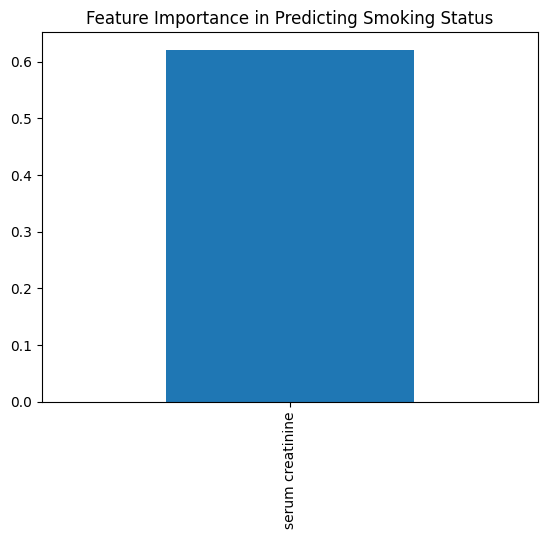

In [ ]:
for i in ['Urine protein', 'serum creatinine']:
    feature_imp_log_regression(i)

In [ ]:
for i in ['Urine protein', 'serum creatinine']:
    results = test_feature_normality_and_difference(train_df, i, 'smoking')
    print(results)

{'test_performed': 'Mann-Whitney U', 'is_normal': 'No', 'p_value': 8.994735961233727e-38, 'conclusion': 'There is a significant difference.'}
{'test_performed': 'Mann-Whitney U', 'is_normal': 'No', 'p_value': 0.0, 'conclusion': 'There is a significant difference.'}


With the provided results, we observe a very small p-value (0.0). This suggests that there is significant evidence to reject the null hypothesis. Therefore, we can conclude that there is a significant difference between smokers and non-smokers.

Based on the comprehensive analysis, we can affirm that both measures vary significantly between smokers and non-smokers.

##### 6. Observations to consider in feature engineering & data preporcessing

As mentioned, these variables are indeed interesting to include in the model. However, they contain values that could be considered as limits since they represent cases of severe kidney failure. Taking that into account, when we preprocess the dataset, we will apply a reasonable limit, setting a maximum of 4 in this case.

#### Feature 17, 18 & 19: AST, ALT & Gtp

##### 1. Medical Description

We have decided to group the analysis of these variables as all three are related to liver function.

AST (aspartate aminotransferase) is an enzyme that is found mostly in the liver, but it's also present in muscles and other organs in the body. When cells containing AST are damaged, they release AST into the bloodstream. An AST blood test measures the amount of AST in the blood and is commonly used to help diagnose liver damage or disease.

ALT (alanine transaminase) is an enzyme primarily found in the liver. An ALT test measures the amount of ALT in the blood. When liver cells are damaged, they release ALT into the bloodstream. Elevated levels of ALT may indicate liver injury or disease.

GGT or (Gtp) (gamma-glutamyl transferase) is an enzyme found throughout the body, with higher concentrations in the liver. Elevated GGT levels in the blood may indicate liver disease or damage to the bile ducts.

Several studies demonstrate the effect of tobacco on the liver. According to these studies, tobacco consumption is expected to affect all three indicators. Additionally, GGT is associated with high alcohol consumption, which can be related to a sedentary lifestyle, another significant indicator of tobacco use.

Sources analyzed:

- https://medlineplus.gov/lab-tests/ast-test/
- https://medlineplus.gov/lab-tests/alt-blood-test/
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8132692/

##### 2. Reasonable values

AST: Normal values range between 8 and 33, and it can significantly increase in cases of severe hepatitis. Based on our analysis, we consider these cases to occur above a value of 100.

ALT: Normal levels are between 8 and 40, and hepatitis can also affect this indicator. AST and ALT are closely related in terms of how they both increase. We will consider values above 100 as extreme.

GGT: Normal levels typically range up to 40-48. Since it is an indicator that tends to be elevated in individuals with high alcohol consumption, the most adverse effects related to tobacco occur in the highest cases. However, we will consider values exceeding 300 as extreme cases that may confuse the model.

##### 3. Correct Data Types?

In [ ]:
print(train_df['AST'].dtypes)
print(train_df['ALT'].dtypes)
print(train_df['Gtp'].dtypes)

int64
int64
int64


The collected data corresponds to integers. This data type is correct since the values are rounded.

##### 4. Values collected in the dataset

Feature: AST
Mean: 25.516853368161954
Median: 24.0
Mode: 20
Range: 772
Variance: 89.58399275099262
Standard Deviation: 9.464882078028898
Maximum: 778
Minimum: 6
Quartiles:
0.25    20.0
0.50    24.0
0.75    29.0
Name: AST, dtype: float64


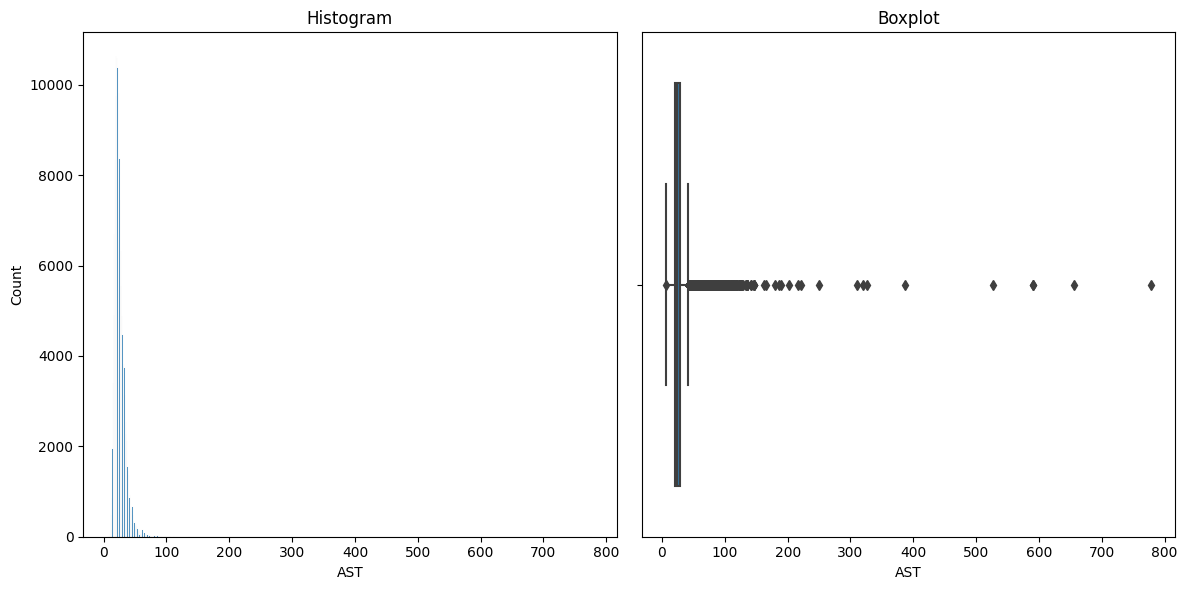

Feature: ALT
Mean: 26.550296378158436
Median: 22.0
Mode: 15
Range: 2913
Variance: 315.1714993313142
Standard Deviation: 17.75307013818495
Maximum: 2914
Minimum: 1
Quartiles:
0.25    16.0
0.50    22.0
0.75    32.0
Name: ALT, dtype: float64


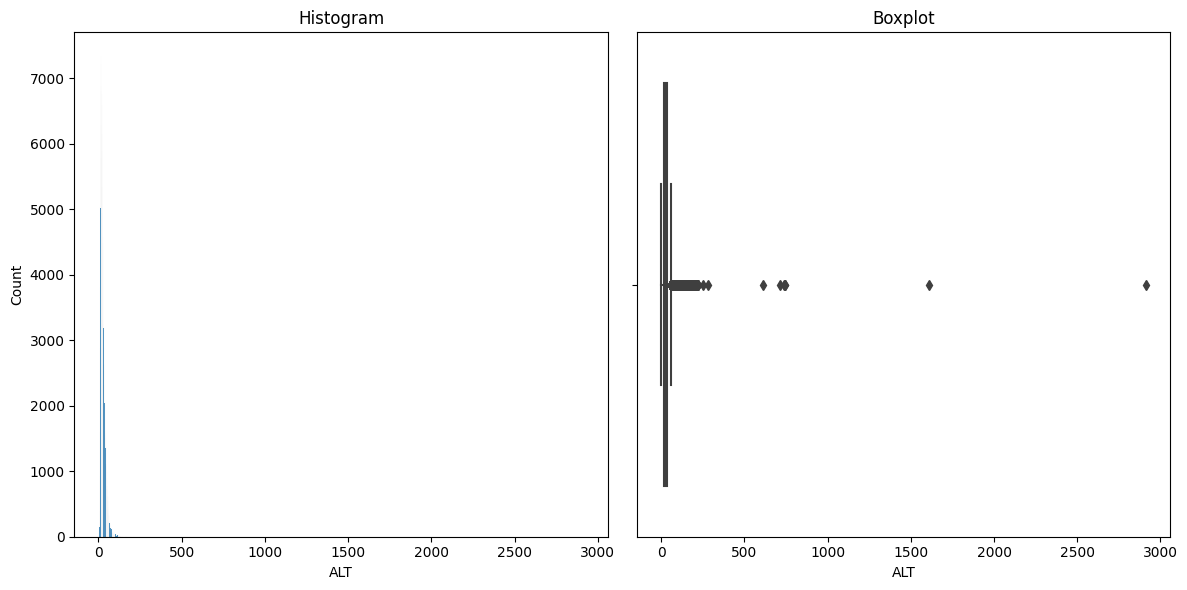

Feature: Gtp
Mean: 36.216004420555585
Median: 27.0
Mode: 14
Range: 997
Variance: 973.7297255842097
Standard Deviation: 31.20464269278227
Maximum: 999
Minimum: 2
Quartiles:
0.25    18.0
0.50    27.0
0.75    44.0
Name: Gtp, dtype: float64


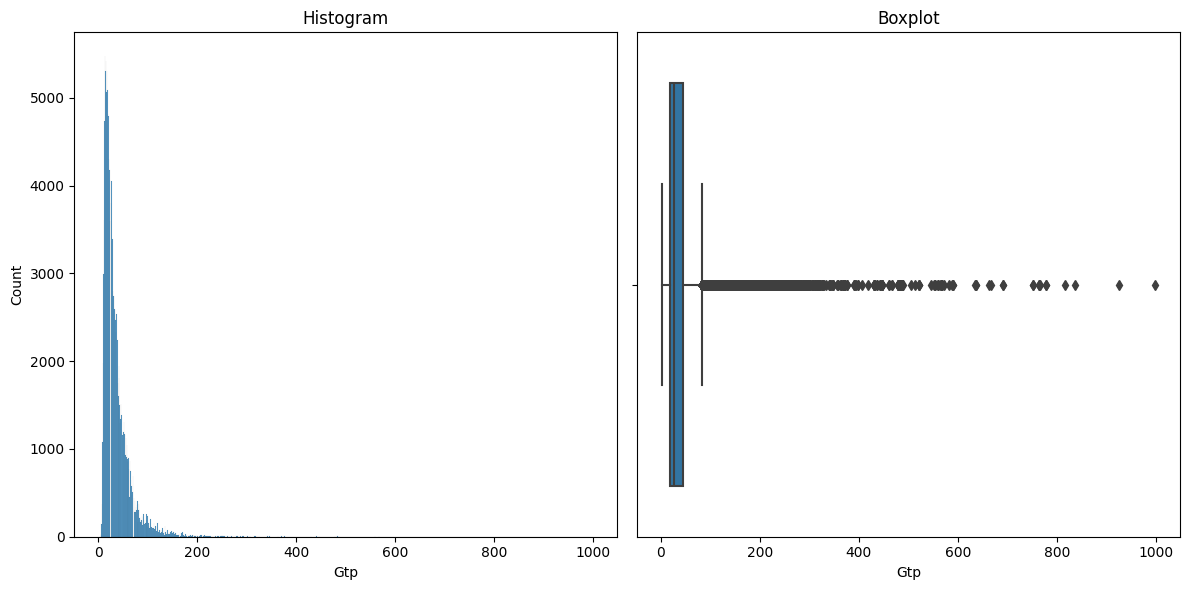

In [ ]:
for i in ['AST', 'ALT', 'Gtp']:
    analyze_feature(train_df[i])

We can see that all three indicators follow a distribution with almost all values within the usual ranges we mentioned earlier. However, there is a minority of extreme cases that exceed the extreme limits we have set and that we should adjust before developing the model.

##### 5. Relationship with smoking

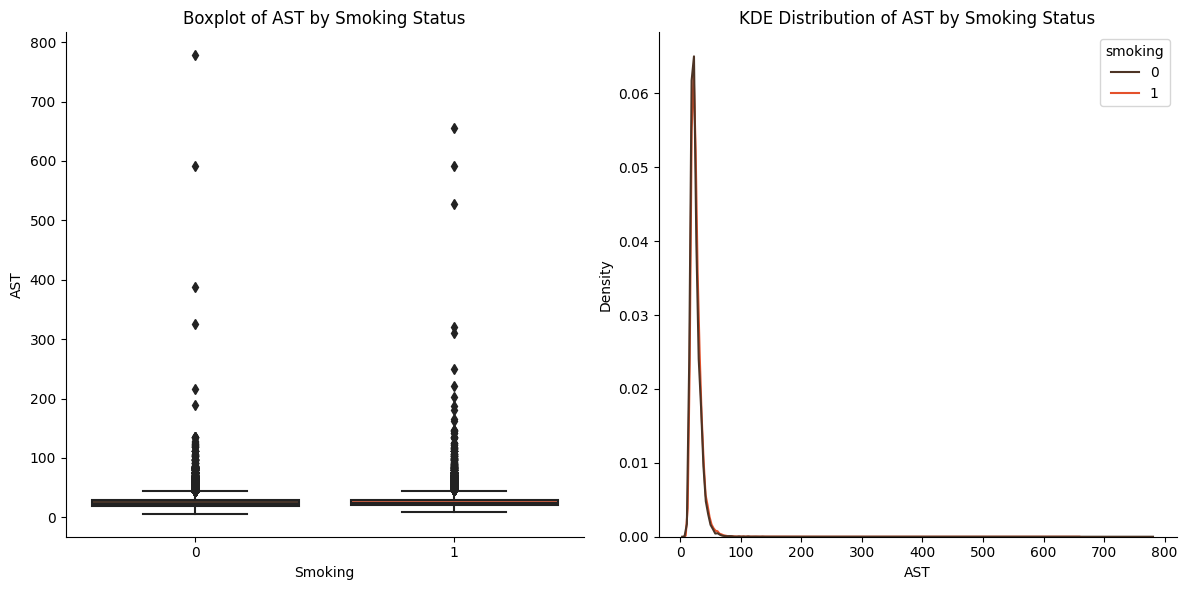

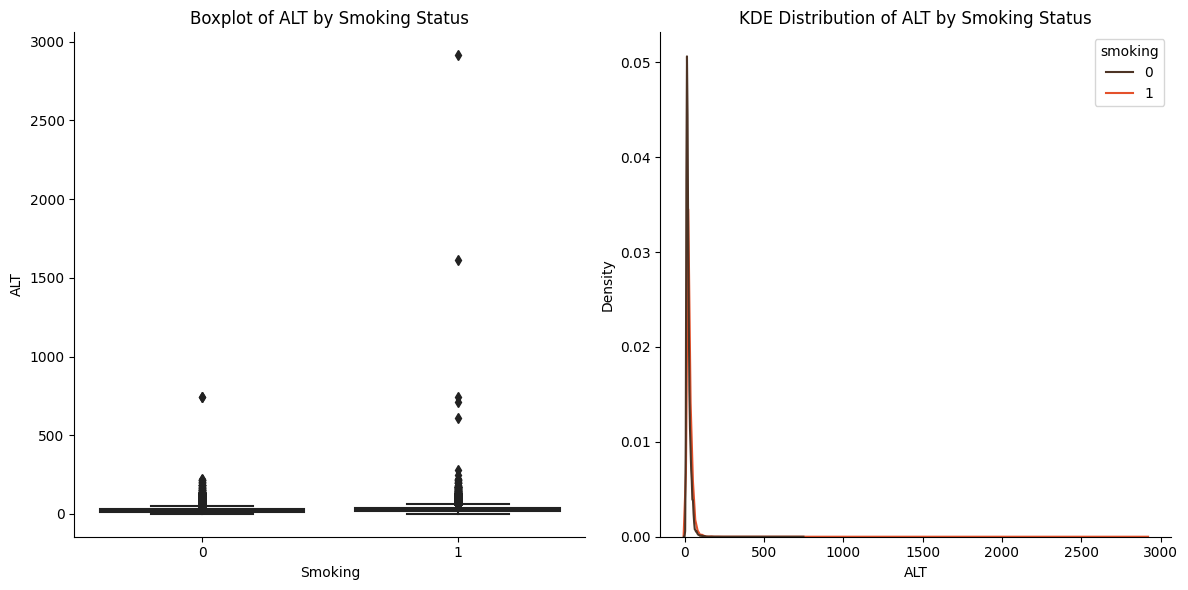

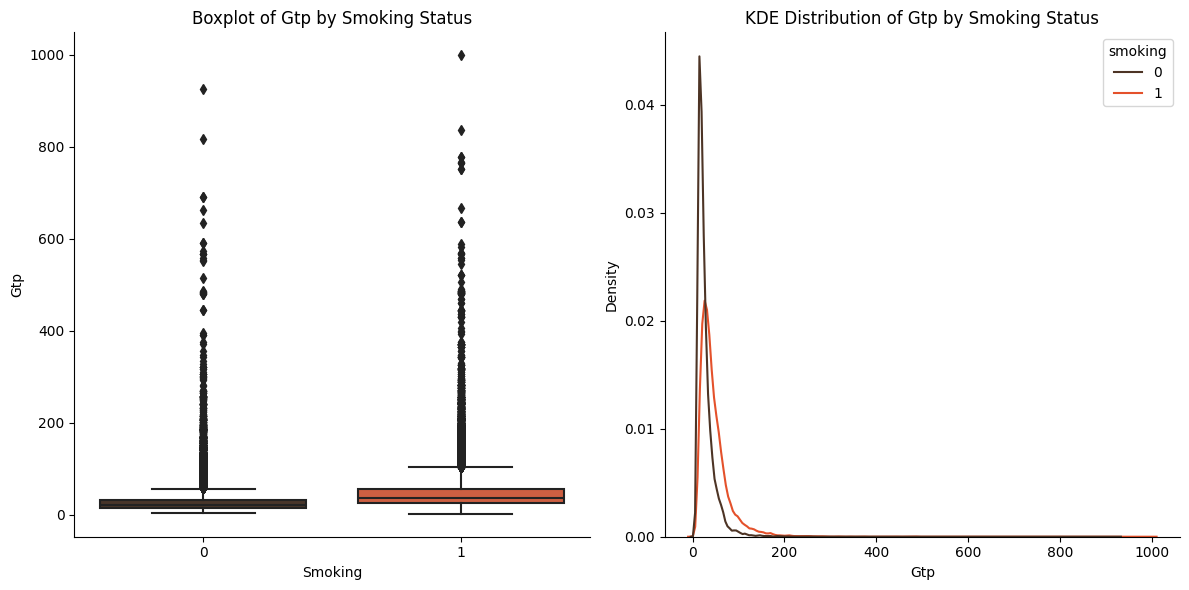

In [ ]:
for i in ['AST', 'ALT', 'Gtp']:
    effect_of_smoking_visualiztion(i)

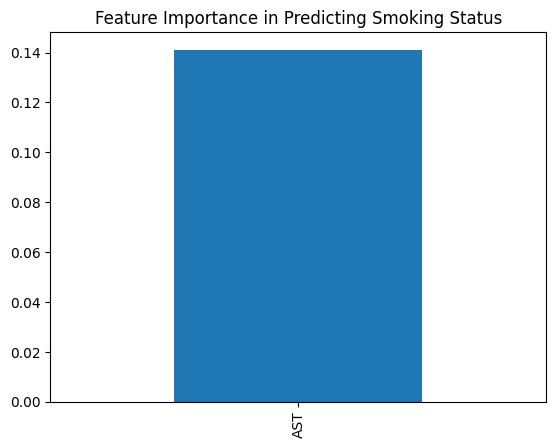

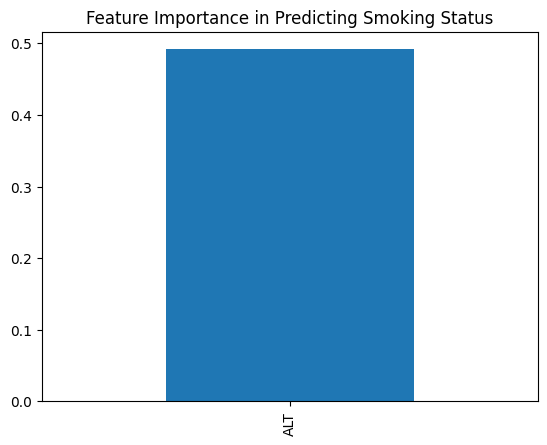

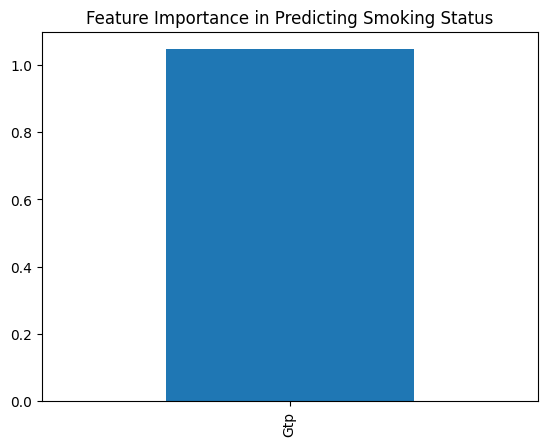

In [ ]:
for i in ['AST', 'ALT', 'Gtp']:
    feature_imp_log_regression(i)

In [ ]:
for i in ['AST', 'ALT', 'Gtp']:
    results = test_feature_normality_and_difference(train_df, i, 'smoking')
    print(results)

{'test_performed': 'Mann-Whitney U', 'is_normal': 'No', 'p_value': 4.4334852565525843e-185, 'conclusion': 'There is a significant difference.'}
{'test_performed': 'Mann-Whitney U', 'is_normal': 'No', 'p_value': 0.0, 'conclusion': 'There is a significant difference.'}
{'test_performed': 'Mann-Whitney U', 'is_normal': 'No', 'p_value': 0.0, 'conclusion': 'There is a significant difference.'}


With the provided results, we observe a very small p-value (0.0). This suggests that there is significant evidence to reject the null hypothesis. Therefore, we can conclude that there is a significant difference between smokers and non-smokers.

Based on the comprehensive analysis, we can affirm that all three measures vary significantly between smokers and non-smokers.

##### 6. Observations to consider in feature engineering & data preporcessing

As we have discussed, there are limit values that distort the rest of the data because they represent extreme cases. As we will do with many other variables, we will limit the values that exceed the boundaries we have indicated since they represent individuals with issues such as hepatitis or similar conditions that could distort the model designed.

#### Feature 20: Dental Caries

##### 1. Medical Description

Studies demonstrate a direct relationship between tobacco use and dental caries. Tobacco consumption reduces saliva flow, which facilitates the development of cavities.

Studies analyzed: [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6662788/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6662788/)

##### 2. Reasonable values

This value only indicates whether the sample presents dental caries or not, so it should only collect values of 0 or 1.

##### 3. Correct Data Types?

In [ ]:
print(train_df['dental caries'].dtypes)

int64


The collected data corresponds to integers. This data type is correct since it can only be either a 1 or a 0 based on the dental condition.

##### 4. Values collected in the dataset

Feature: dental caries
Mean: 0.1979956799115889
Median: 0.0
Mode: 0
Range: 1
Variance: 0.1587943877489433
Standard Deviation: 0.3984901350710495
Maximum: 1
Minimum: 0
Quartiles:
0.25    0.0
0.50    0.0
0.75    0.0
Name: dental caries, dtype: float64


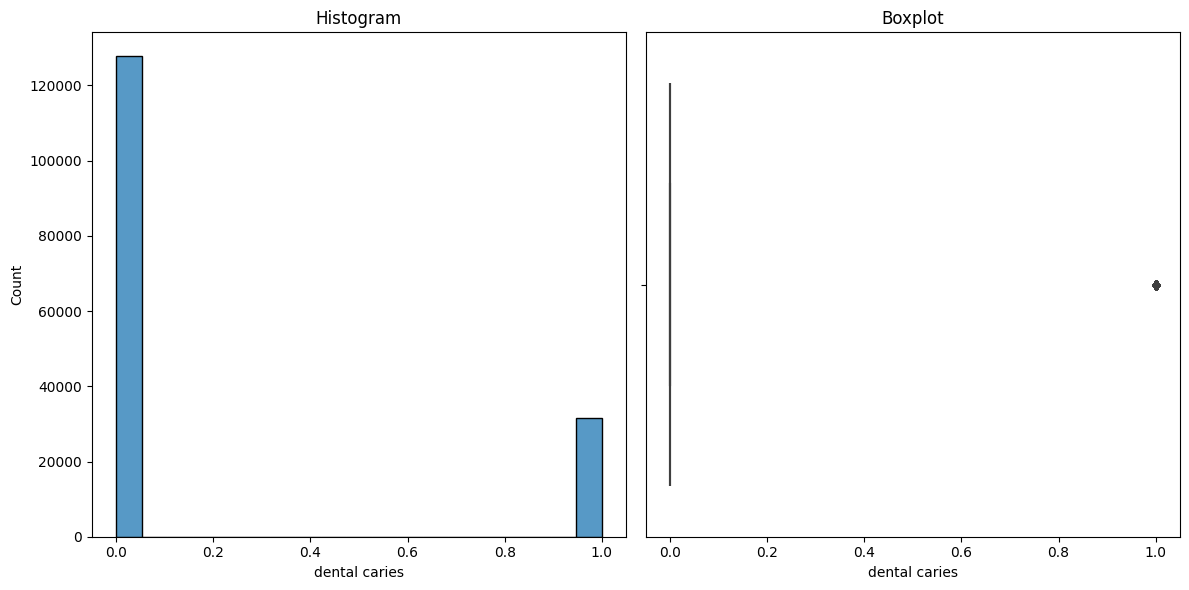

In [ ]:
analyze_feature(train_df['dental caries'])

##### 5. Relationship with smoking

In this section, we will try to determine whether there is a relationship between dental caries and smoking through a chi-square test, as it is a categorical variable.

In [ ]:
results = perform_chi_square_test(train_df, 'dental caries', 'smoking')
print(results)

{'chi2_statistic': 1810.4064771591138, 'p_value': 0.0, 'conclusion': 'There is a significant association.'}


To understand the relationship in the sample, we will separate the population into smokers and non-smokers and analyze the percentage of individuals with dental caries in each group.

In [ ]:
smokers_caries = train_df[train_df['smoking'] == 1]['dental caries']
non_smokers_caries = train_df[train_df['smoking'] == 0]['dental caries']

smokers_caries_percen = (smokers_caries.sum())/(len(smokers_caries))
non_smokers_caries_percen = (non_smokers_caries.sum())/(len(non_smokers_caries))

print(f'The average of the values for caries in smokers is {smokers_caries_percen}')
print(f'The average of the values for caries in non-smokers is {non_smokers_caries_percen}')

The average of the values for caries in smokers is 0.24619183667609434
The average of the values for caries in non-smokers is 0.16053033938595807


We can see that there is a relationship between the two variables, and our initial hypothesis is confirmed as there are more dental caries among smokers than among non-smokers.

##### 6. Observations to consider in feature engineering & data preporcessing

No additional steps have been identified that need to be considered before developing the model. Since dental caries are related to tobacco use, it makes sense to include this factor in the model.

### 3.2. Bivariate analysis

After analyzing all the variables individually, the objective of this section is to determine if the relationship between different variables may be affecting whether someone is a smoker or not (target variable). It's possible that when combining multiple variables, unexpected results may arise in predicting the target variable, or that two variables may be providing redundant information, thus adding unnecessary noise to the model.

As part of the analysis, we will start by creating a graph to visualize the relationships between the different variables in order to identify correlations or unexpected distributions.

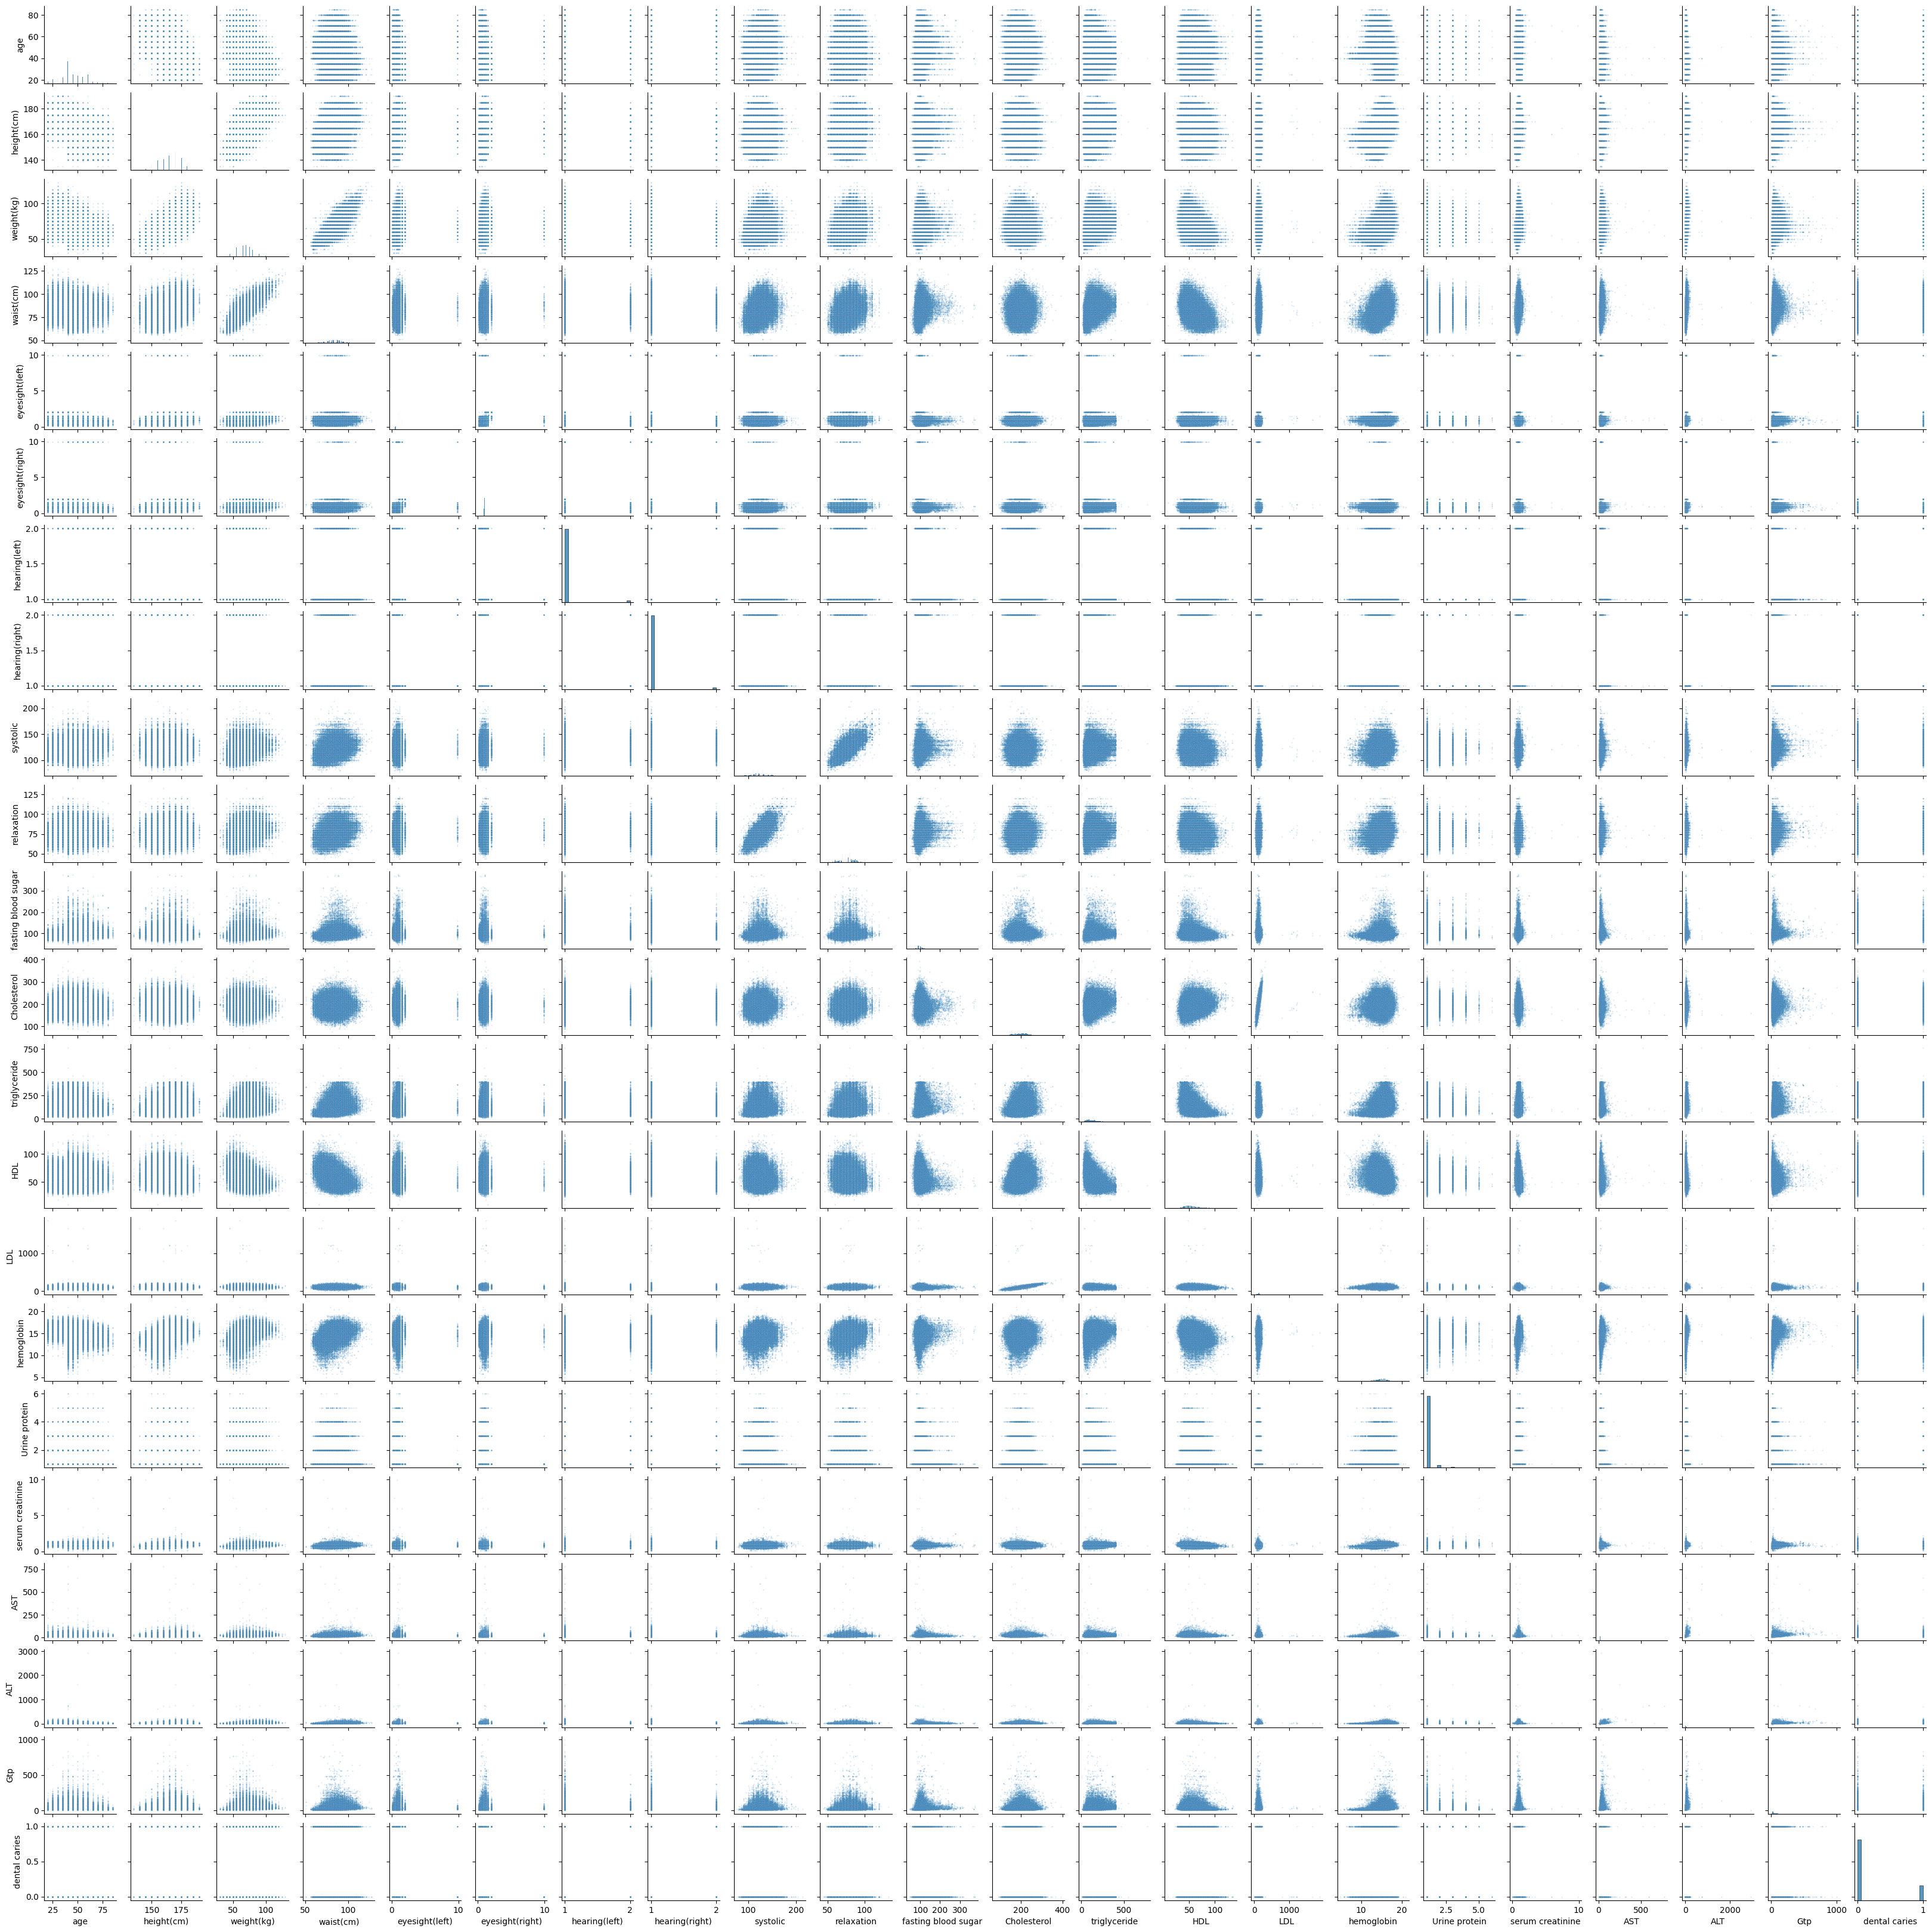

In [ ]:
sns.pairplot(train_df.drop('smoking', axis=1), height=1.5, plot_kws={'s':2, 'alpha': 0.2})

<Axes: >

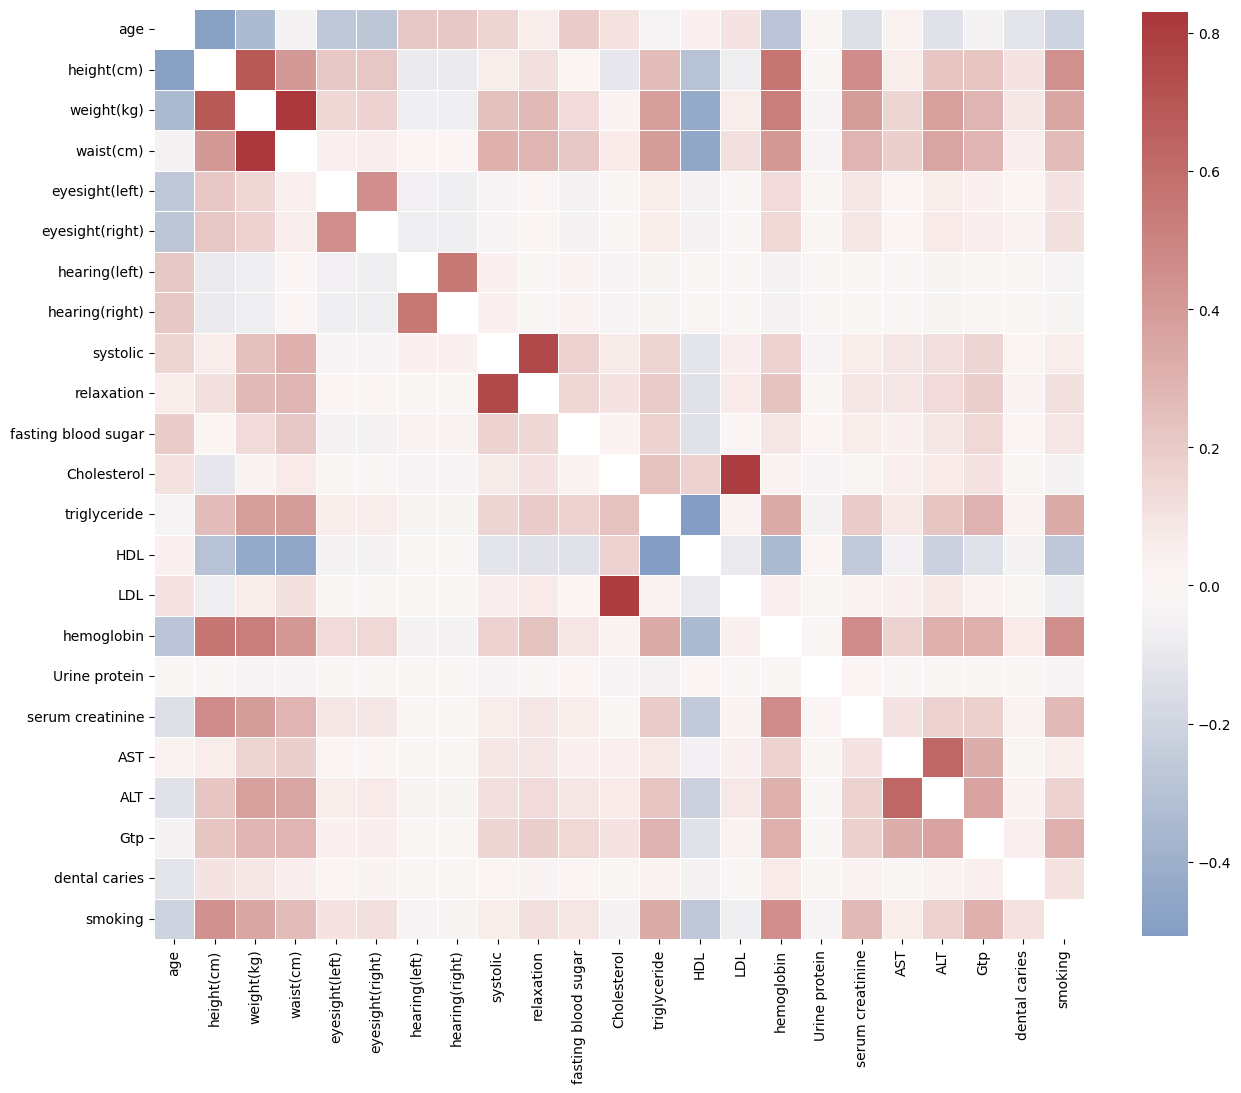

In [ ]:
df_corr = train_df.corr(method='pearson')


plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8})

In [ ]:
lower_triangle_mask = np.tril(np.ones(df_corr.shape), k=-1).astype("bool")

df_corr_stacked = df_corr.where(lower_triangle_mask).stack().sort_values()

df_corr_stacked

HDL         triglyceride   -0.507676
height(cm)  age            -0.489608
HDL         waist(cm)      -0.449219
            weight(kg)     -0.438224
weight(kg)  age            -0.336859
                              ...   
ALT         AST             0.623408
weight(kg)  height(cm)      0.686645
relaxation  systolic        0.753003
LDL         Cholesterol     0.808533
waist(cm)   weight(kg)      0.830208
Length: 253, dtype: float64

Based on the correlations between variables, we can observe that in any of the three ways of analyzing it, there are three variables strongly related to each other:

1. Height, weight, and waist
2. LDL and Cholesterol
3. Relaxation and Systolic

Next, we will analyze them individually:

#### 1. Height, weight & waist

The highest correlation is found between waist circumference and weight in each sample. This correlation is not surprising, considering that these are metrics that, along with height, represent body measurements. As mentioned in the individual section for each of these variables, for our model, we believe it is more important to understand the data related to obesity and its relationship with smoking rather than each of these values individually. Therefore, we will calculate the Pearson correlation coefficient for the ratios derived from them that we believe may be valid and interesting:

In [ ]:
train_df['BMI'] = train_df['weight(kg)'] / (train_df['height(cm)']/100) ** 2
train_df['weight_height_ratio'] = train_df['weight(kg)'] / train_df['height(cm)']
train_df['weight_waist_ratio'] = train_df['weight(kg)'] / train_df['waist(cm)']

correlation_matrix = train_df[['BMI', 'weight_height_ratio', 'weight_waist_ratio', 'smoking']].corr()
correlations_with_smoking = correlation_matrix['smoking'].drop('smoking')

print(correlations_with_smoking)

train_df.drop(['BMI', 'weight_height_ratio', 'weight_waist_ratio'], axis=1, inplace=True)

BMI                    0.141723
weight_height_ratio    0.276938
weight_waist_ratio     0.335633
Name: smoking, dtype: float64


Podemos ver en la tabla anterior que los dos ratios que mejor se relacionan con la target variable 'smoking' son el weight_height_ratio y el weight_waist_ratio. Esto resultado razonable porque el ratio entre peso y altura demuestra cuantos kg de peso tiene una persona por cada metro de altura, lo cual es razonable pensar que está relaionado con la obesidad. En cuanto al segundo ratio, se puede comprender que las personas que tienen más  grasa abdominal (normalmente más obesa) tienen una mayor proporción de grasa en la cintura que una persona que no está en esa condición.

#### 2. LDL & Cholesterol

As explained in the section on these variables, the Cholesterol variable is directly calculated from the others, making it a clear case that could create collinearity and not provide additional information. Therefore, we will remove this variable when applying the transformation.

#### 3. Relaxation & Systolic

Given the high correlation and the close relationship between these two variables, let's visualize graphically how this correlation looks:

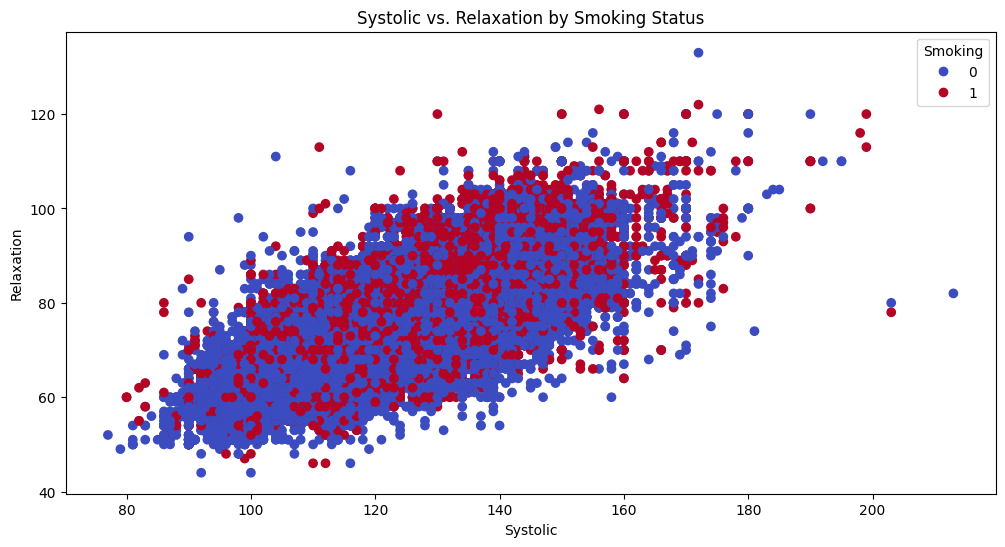

In [ ]:
plt.figure(figsize=(12, 6))
scatter = plt.scatter(train_df['systolic'], train_df['relaxation'], c=train_df['smoking'], cmap='coolwarm', label=train_df['smoking'])
plt.title('Systolic vs. Relaxation by Smoking Status')
plt.xlabel('Systolic')
plt.ylabel('Relaxation')
plt.legend(*scatter.legend_elements(), title='Smoking')
plt.show()

We can see that despite some differences, the trend is clear. Therefore, when transforming the population, we will calculate the average between the two variables to reduce collinearity.

## 4. Conclusions of the Exploratory Data Analysis

Here's the translation of the points discovered in the exploratory data analysis that need to be considered in the following steps of feature engineering and data preprocessing:

- There are several variables with high correlation between them, which could be included in the model as ratios.
- The dataset is not evenly distributed across different age groups, as a large portion of the samples correspond to individuals between 38 and 43 years old.
- Some variables do not follow the same pattern between smokers and non-smokers when they should have the same distribution (e.g., height) or have the opposite distribution than expected (e.g., hearing).
- Certain variables contain values that hide erroneous values (e.g., eyesight for left and right eyes).
- Some features have values that, although possible, are extreme and may confuse the model.
- There are columns that capture two metrics representing the same feature (e.g., hearing and eyesight).
- There are columns obtained by summing other features (e.g., cholesterol).

# FEATURE ENGINEERING

Based on the insights obtained from the Exploratory Data Analysis, we will now define the functions that apply this changes to the original data set so that it is more suitable for model development. **We remind to use this only** in the case of not experimenting anymore with the original dataset.

In [10]:
def balance_age_by_undersampling(df, target_age=40, random_state=123):
    # Separate the majority and minority classes
    df_majority = df[df['age'] != target_age]
    df_minority = df[df['age'] == target_age]

    # Compute the target sample size based on a desired balance or the size of the next largest group
    target_sample_size = min(len(df_minority), df['age'].value_counts().drop(target_age).max())

    # Perform undersampling on the majority class
    df_majority_undersampled = resample(df_minority,
                                        replace=False,    # sample without replacement
                                        n_samples=target_sample_size,     # to match minority class
                                        random_state=random_state)  # reproducible results

    # Combine minority class with downsampled majority class
    df_balanced = pd.concat([df_majority, df_majority_undersampled])

    return df_balanced


In [11]:
df_balanced=balance_age_by_undersampling(df=train_df)

In [12]:
def transform(df):

    # 1. We want to solve the correlation issue between the two metrics of the blood pressure by calculating a ratio

    df['blood_pressure_ratio'] = (df['systolic'] + df['relaxation']) / (len(df['systolic']) + len(df['relaxation']))
    df.drop(['systolic', 'relaxation'], axis=1, inplace=True)

    # 2. Create new features based on the high correlation between the height, weight and waist features and remove the original features

    df['weight_height_ratio'] = df['weight(kg)'] / df['height(cm)']
    df['weight_waist_ratio'] = df['weight(kg)'] / df['waist(cm)']
    df.drop(['height(cm)', 'weight(kg)', 'waist(cm)'], axis=1, inplace=True)

    # 3. Drop columns for which the data in the sample is giving contrary information due to low cases with hearing problems.
    # And also drop the Cholesterol column as it is calculated from other metrics.

    df.drop(['hearing(left)', 'hearing(right)'], axis=1, inplace=True)
    df.drop(['Cholesterol'], axis=1, inplace=True)

    # 4. Create a new column for the eyesight that registers the worst metric between the left and the right

    df['eyesight_max'] = df[['eyesight(left)', 'eyesight(right)']].max(axis=1)
    df.drop(['eyesight(left)', 'eyesight(right)'], axis=1, inplace=True)

    # 5. Modification of null values covered as 9.9 on the eyesight feature

    # We calculate the averages without the 9.9 values
    average_eyesight_smoking = df.loc[(df['eyesight_max'] != 9.9), 'eyesight_max'].mean()

    # And we replace the values

    df.loc[(df['eyesight_max'] == 9.9), 'eyesight_max'] = average_eyesight_smoking

    # 6. Limit the values of certain variables as some of them, even if possible, could be considered as extreme cases

    df['blood_pressure_ratio'] = np.clip(df['blood_pressure_ratio'], 0, 150)
    df['fasting blood sugar'] = np.clip(df['fasting blood sugar'], 0, 200)
    df['HDL'] = np.clip(df['HDL'], 0, 110)
    df['LDL'] = np.clip(df['LDL'], 0, 200)
    df['serum creatinine'] = np.clip(df['serum creatinine'], 0, 4)
    df['Urine protein'] = np.clip(df['Urine protein'], 0, 4)
    df['AST'] = np.clip(df['AST'], 0, 100)
    df['ALT'] = np.clip(df['ALT'], 0, 100)
    df['Gtp'] = np.clip(df['Gtp'], 0, 300)

    return df

In [13]:
train_df_transformed = transform(train_df)

In [14]:
test_df_transformed = transform(test_df)

# **Model Deployment**

## Data Scaling and Sampling


Some algorithms, like gradient descent use the Euclidean distance between two data points in their computations. If one feature has a broad range of values, the distance will be dominated by this feature. Therefore, the range of all features should be normalized so that each feature contributes approximately proportionately to the final distance.

In [3]:
def scaling(df,test_df):
    #We remove the id from all datasets
    
    df.drop(columns=['id'],inplace=True)
    test_df.drop(columns=['id'],inplace=True)
    
    #First we split between feature variables and target variable.
    
    X_train = df.drop('smoking', axis=1)
    y_train = df['smoking']

    # scale the data using MinMaxScaler.
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    test_df_scaled = scaler.transform(test_df)

    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns).reset_index(drop=True)
    train_df_scaled = pd.concat([X_train_scaled_df, y_train.reset_index(drop=True)], axis=1)

    return train_df_scaled, test_df_scaled

In [4]:
train_df_scaled, test_df_scaled = scaling(train_df,test_df) #Always remeber to use the correspondedt dataframe

We separate again features and target variable after corresponding changes

In [5]:
X_raw_total = train_df_scaled.drop('smoking', axis=1)
y_raw_total = train_df_scaled['smoking']

#### Sampling

We realized that I would be more time efficient to train the model with sample records from the Dataframe. 
This is what we thought in the beginning, but turned out to be a catastrophere.

In [68]:
def sampling(frac,df):
    sampled_train_df = df.sample(frac=frac, random_state=42)
    X = sampled_train_df.drop('smoking', axis=1)
    y = sampled_train_df['smoking']
    return X,y

In [69]:
X_sampled,y_sampled = sampling(frac=0.3,df=train_df)

## Behaviour of the models

Explain that this was our first approach because we didnt take into account hyper-parameter tuning.

In [70]:
def cross_validation(model):
        # Perform cross-validation
        kfold = KFold(n_splits=5, random_state=42, shuffle=True)
        scores = cross_val_score(model, X_sampled, y_sampled, cv=kfold, scoring='roc_auc')
        print(scores)
        mean_score = scores.mean()
        print(f'The mean value for 5 folds: {mean_score}')

        # Fit the model on the same sampled dataset
        model.fit(X_sampled, y_sampled)

        # Predict probabilities on the training set
        y_pred_proba_train = model.predict_proba(X_sampled)[:, 1]

        # Compute the false positive rate, true positive rate, and thresholds
        fpr, tpr, thresholds = roc_curve(y_sampled, y_pred_proba_train)

        # Compute the area under the ROC curve
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Predictive ROC Curve')
        plt.legend(loc="lower right")

[0.83217444 0.8325867  0.83004843 0.83727489 0.83723971]
The mean value for 5 folds: 0.8338648314244781
CPU times: total: 33.3 s
Wall time: 38.7 s


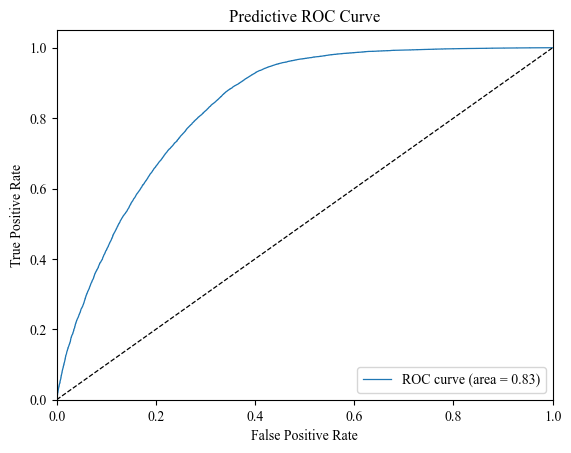

In [71]:
%%time
cross_validation(LogisticRegression(max_iter=1000,solver='liblinear'))

[0.68301492 0.67940821 0.67500948 0.68578633 0.6869063 ]
The mean value for 5 folds: 0.6820250468504111
CPU times: total: 6.17 s
Wall time: 6.83 s


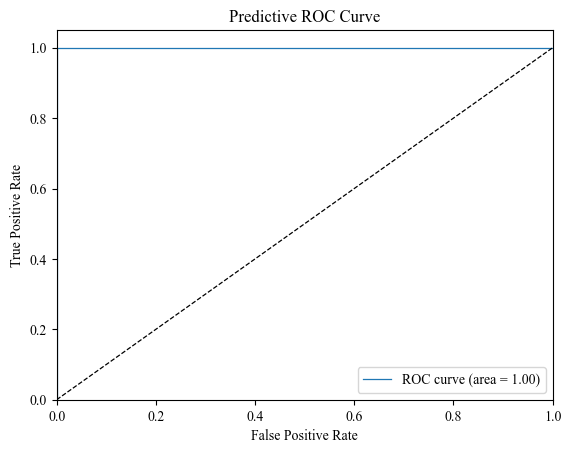

In [72]:
%%time
cross_validation(DecisionTreeClassifier())

[0.85794301 0.84707989 0.85242342 0.84710338 0.85134413]
The mean value for 5 folds: 0.8511787647598714
CPU times: total: 2min 3s
Wall time: 2min 20s


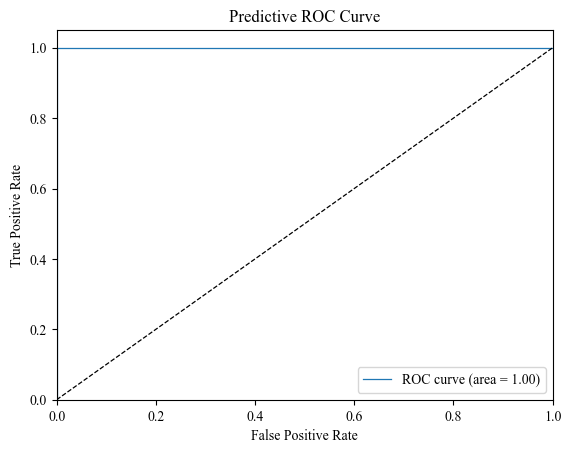

In [20]:
%%time
cross_validation(RandomForestClassifier())

[0.8514915  0.85343451 0.84981146 0.85523324 0.85825166]
The mean value for 5 folds: 0.85364447451485
CPU times: total: 13.8 s
Wall time: 5.05 s


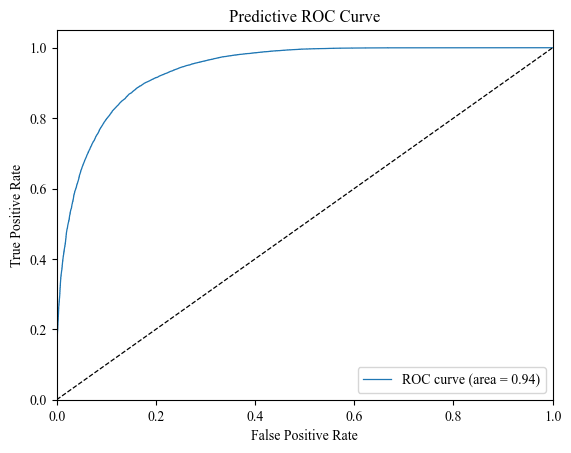

In [73]:
%%time
cross_validation(XGBClassifier(objective="binary:logistic", verbosity=0))

In [ ]:
%%time
cross_validation(SVC()) #Endless to run

SVM, seems to be a highly innefective method do to its processing time. In other instances it would be interseting to try it but in the current sitution we believe not to continue with it.

## Hyper-parameter tuning

In [6]:
class ModelTrainer:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.pipeline = Pipeline([('model', None)])
        self.random_state = 42

    def train_evaluate_model(self, parameters):
        kfold = KFold(n_splits=5, random_state=self.random_state, shuffle=True)
        random_search = RandomizedSearchCV(self.pipeline, parameters, cv=kfold, scoring='roc_auc', refit=True, n_jobs=-1,n_iter=100,
                                   return_train_score=True).fit(self.X, self.y)

        best_model = random_search.best_estimator_

        # Predict probabilities on the training set
        y_pred_proba_train = best_model.predict_proba(self.X)[:, 1]

        # Compute the false positive rate, true positive rate, and thresholds
        fpr, tpr, thresholds = roc_curve(self.y, y_pred_proba_train)

        # Compute the area under the ROC curve
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Predictive ROC AUC')
        plt.legend(loc="lower right")

        return random_search, best_model[0]

#------------#------------#------------#------------#------------#------------#------------#------------#
#------------#------------#------------#------------#------------#------------#------------#------------#

#
    def params_clf(self):
        parameters = [
            {
                'model': [LogisticRegression(max_iter=1000,solver='liblinear', random_state=self.random_state)],
                'model__C':np.logspace(-3, 2, 6),
                'model__penalty': ['l1','l2']
            }]
        return self.train_evaluate_model(parameters)

    def params_decision_tree(self):
        parameters = [{
            'model': [DecisionTreeClassifier(random_state=self.random_state)],
            'model__criterion': ['gini','entropy'],
            'model__min_samples_split': randint(2, 11),  # Discrete distribution from 2 to 10
            'model__min_samples_leaf': randint(1, 5),    # Discrete distribution from 1 to 4
            'model__max_depth': [5,10,25,None]
        }]
        return self.train_evaluate_model(parameters)

    def params_random_forest(self):
        parameters = [{
            'model': [RandomForestClassifier(random_state=self.random_state)],
            'model__min_samples_split': randint(2, 11),    # Discrete distribution from 2 to 10
            'model__min_samples_leaf': randint(2, 17),     # Discrete distribution from 2 to 16
            'model__n_estimators': randint(50, 201),       # Discrete distribution from 50 to 200
            'model__max_depth': [None, 5, 10,15,20]
        }]
        return self.train_evaluate_model(parameters)

    def params_xgboost(self):
        parameters = [{
            'model': [XGBClassifier(objective="binary:logistic", verbosity=0, random_state=self.random_state)],
            'model__colsample_bytree': uniform(0.3, 0.4),   # Continuous distribution from 0.3 to 0.7
            'model__learning_rate': uniform(0.01, 0.29),   # Continuous distribution from 0.01 to 0.3
            'model__gamma': uniform(0, 0.5),               # Continuous distribution from 0 to 0.5
            'model__max_depth': [3, 5, 7],
            'model__n_estimators': randint(50, 201),       # Discrete distribution from 50 to 200
            'model__subsample': uniform(0.7, 0.2)          # Continuous distribution from 0.7 to 0.9
        }]
        return self.train_evaluate_model(parameters)

    def params_svm(self):
        parameters = [
            {
                'model': [SVC(random_state=self.random_state)],
                'model__C': np.logspace(-3, 2, 6),           # Continuous distribution from 0.01 to 100
                'model__kernel': ['linear', 'rbf']
            }]
        return self.train_evaluate_model(parameters)

## **Logistic Regression**

CPU times: total: 59.8 s
Wall time: 13min 4s


LogisticRegression(C=100.0, max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')

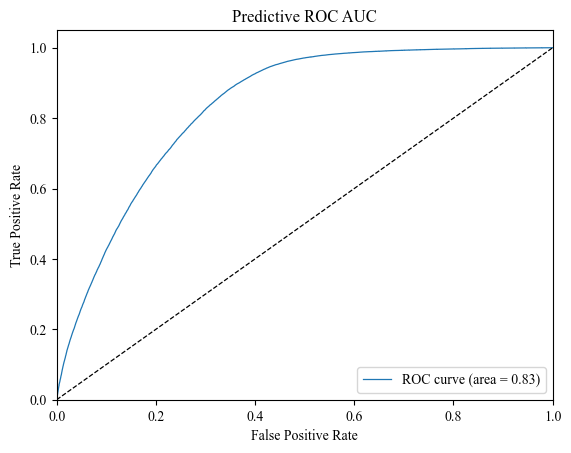

In [83]:
%%time
model_trainer = ModelTrainer(X_raw_total, y_raw_total)
rs_clf, model_clf = model_trainer.params_clf()
model_clf

## **Decision Trees**

CPU times: total: 4.27 s
Wall time: 8min 19s


DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=4,
                       min_samples_split=6, random_state=42)

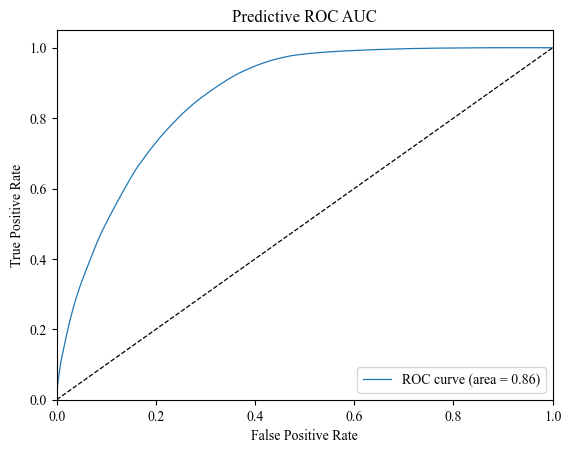

In [79]:
%%time
model_trainer = ModelTrainer(X_raw_total, y_raw_total)
rs_dt, model_decision_tree= model_trainer.params_decision_tree()
model_decision_tree

We can also visualize how does a tree based algorithm looks like

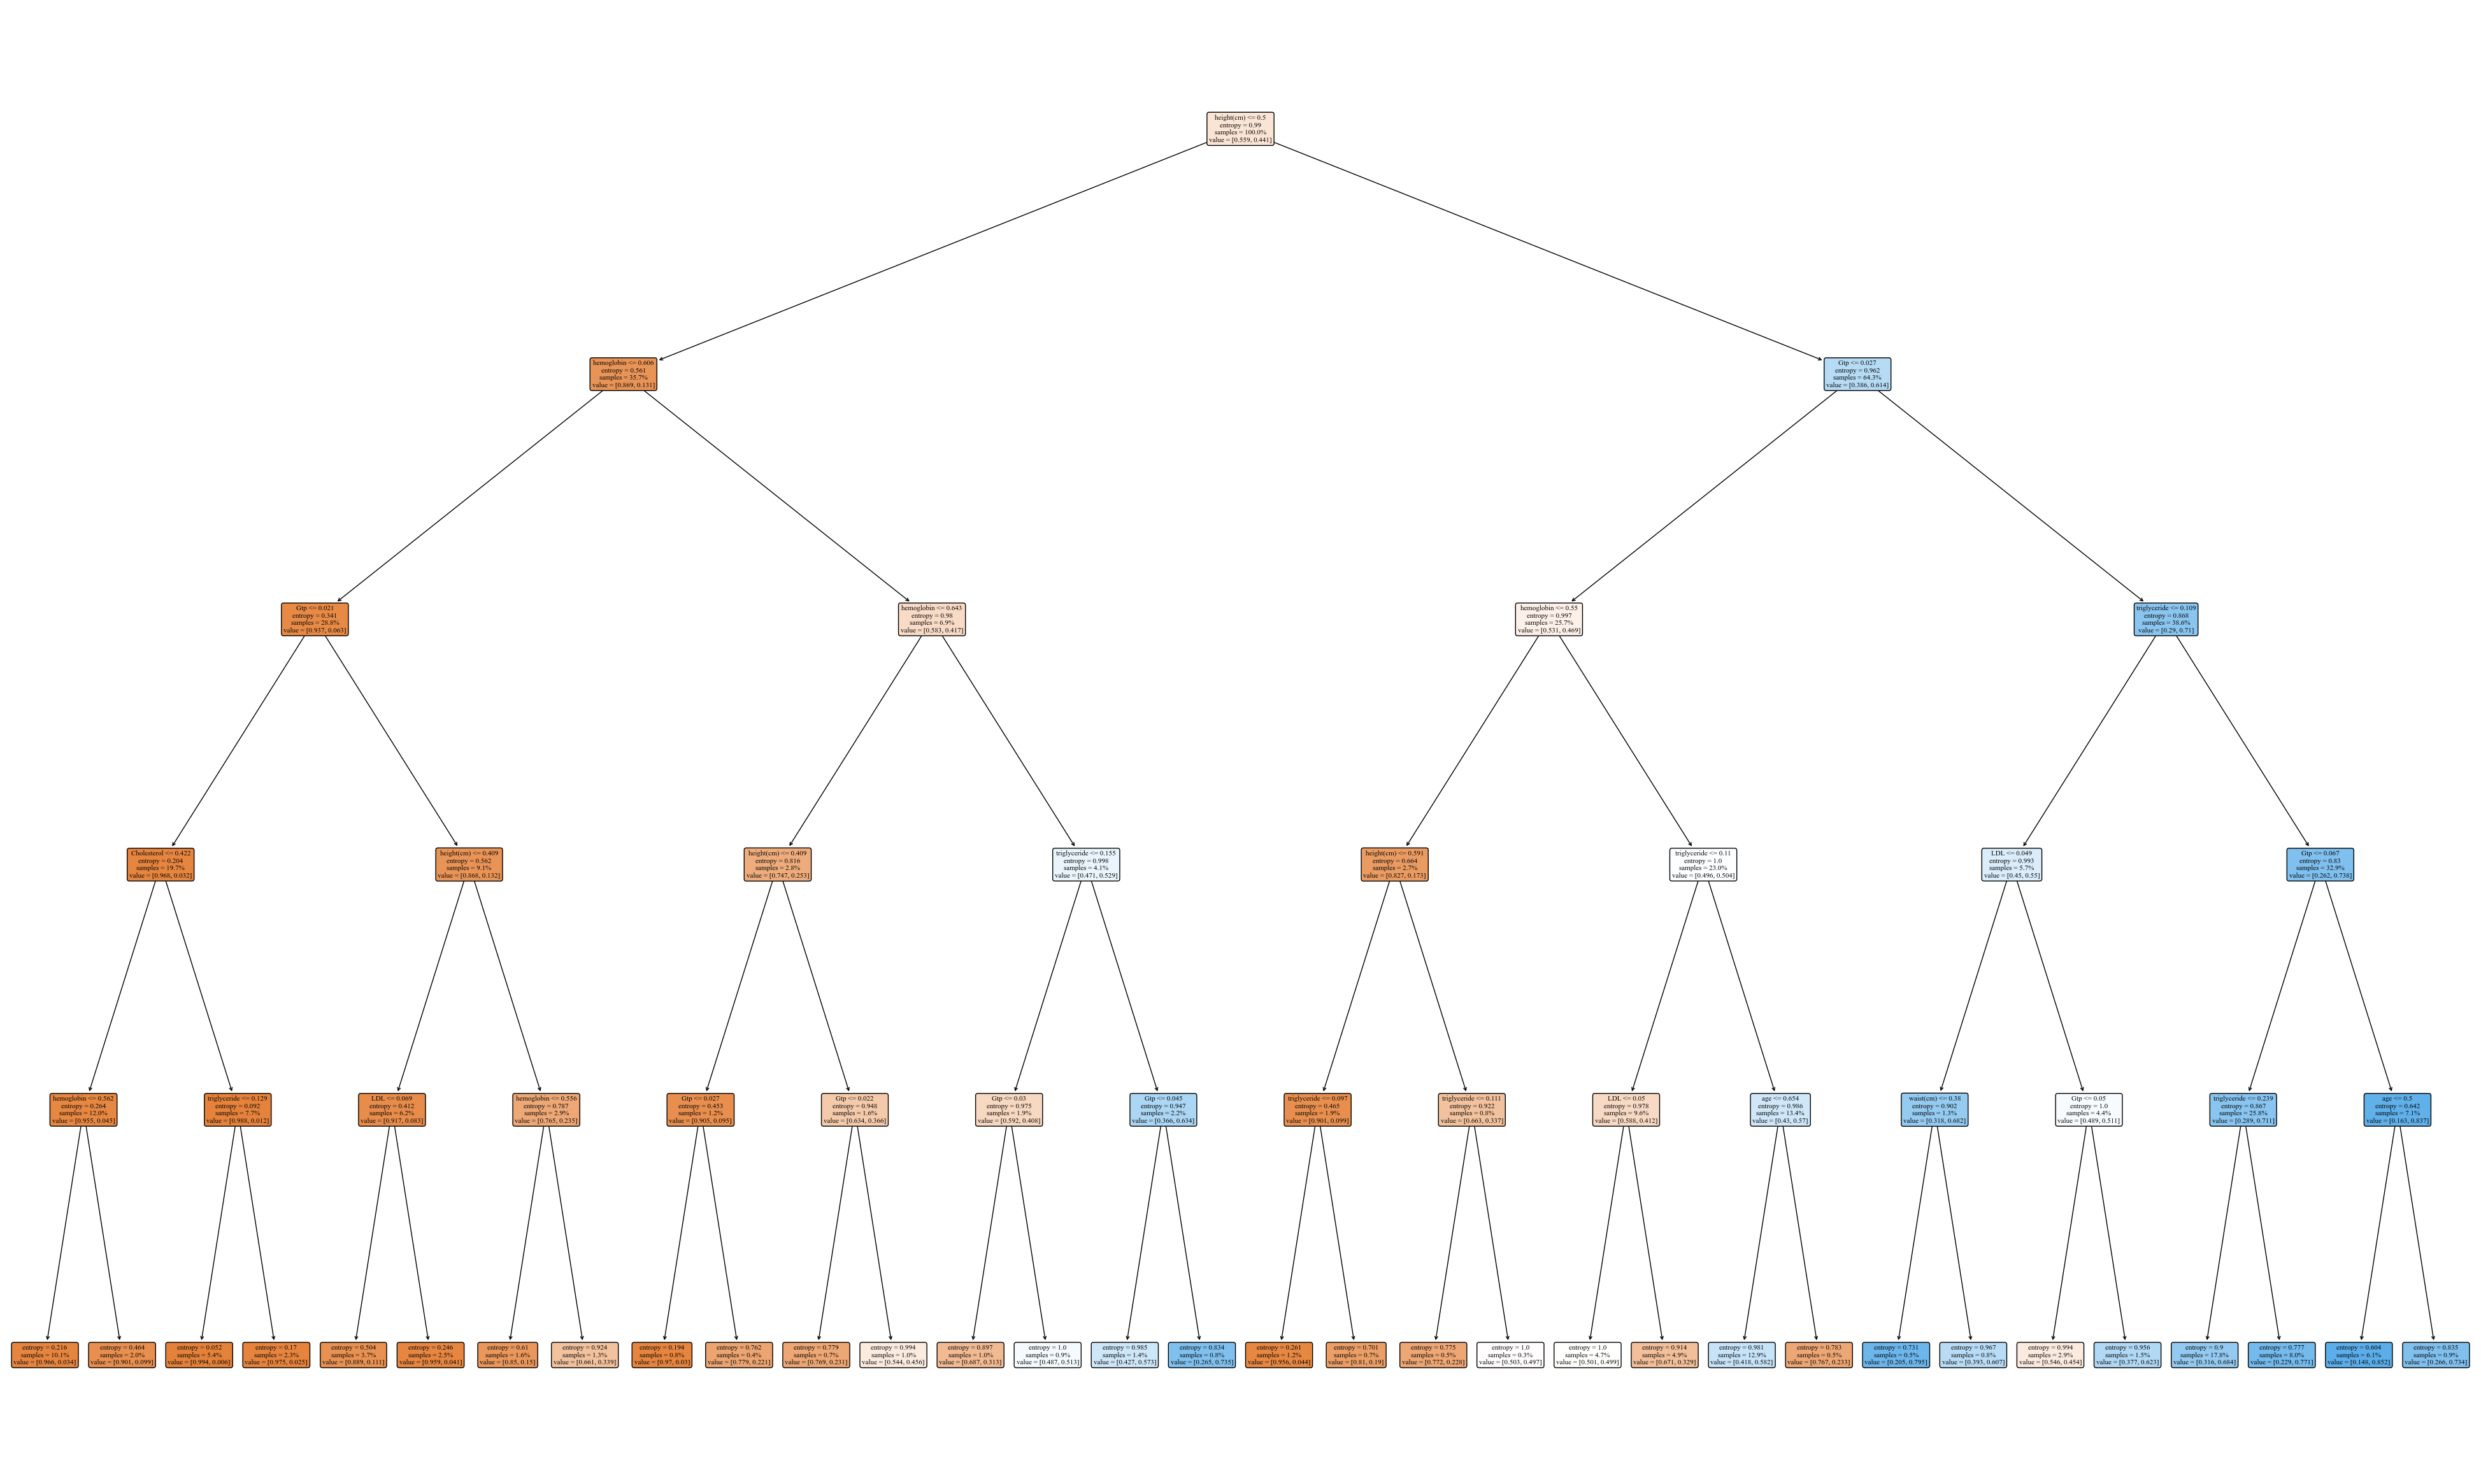

In [14]:
_,ax = plt.subplots(figsize=(50,30))
ax.set_title("Decision Tree")
plot_tree(model_decision_tree, ax=ax, feature_names=X_raw_total.columns.tolist(), proportion=True, filled=True, rounded=True, fontsize=8)
pass

## **Random Forest**

In [9]:
%%time
model_trainer = ModelTrainer(X_raw_total, y_raw_total)
rs_rf, model_rf = model_trainer.params_random_forest()
model_rf

RandomForestClassifier(max_depth=20, min_samples_leaf=7, min_samples_split=3,
                       n_estimators=200, random_state=42)

## **XGBoost**

CPU times: total: 18.8 s
Wall time: 17min 54s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3814176234306306, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.27988573280066886,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09841076258185175,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=195, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

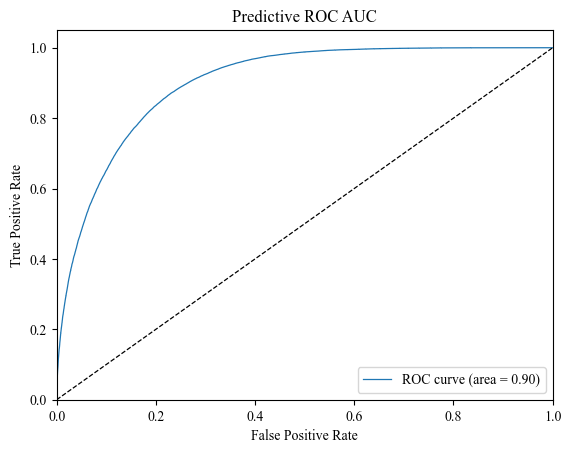

In [35]:
%%time
model_trainer = ModelTrainer(X_raw_total, y_raw_total)
rs_xgb, model_xg = model_trainer.params_xgboost()
model_xg

# **Model Evaluation**

This code down here helps us visualize out of all iterations in RandomizedSearch, how did the different folds outcomed to the model.

In [36]:
#Check for inconsistency in the best XGBoost model with the original dataset
results = pd.DataFrame(rs_xgb.cv_results_)
results=results.sort_values("mean_test_score", ascending=False)
results.head().T

91  \
mean_fit_time                                                          10.235658   
std_fit_time                                                            0.230821   
mean_score_time                                                         0.391358   
std_score_time                                                          0.022753   
param_model                    XGBClassifier(base_score=None, booster=None, c...   
param_model__colsample_bytree                                           0.381418   
param_model__gamma                                                      0.279886   
param_model__learning_rate                                              0.098411   
param_model__max_depth                                                         7   
param_model__n_estimators                                                    195   
param_model__subsample                                                  0.782781   
params                         {'model': XGBClassifier(base_score=None, boost...   
split0_test_score                                                        0.86516   
split1_test_score                                                       0.869541   
split2_test_score                                                       0.867327   
split3_test_score                                                       0.869615   
split4_test_score                                                        0.87003   
mean_test_score                                                         0.868335   
std_test_score                                                          0.001847   
rank_test_score                                                                1   
split0_train_score                                                      0.906342   
split1_train_score                                                      0.905626   
split2_train_score                                                      0.907512   
split3_train_score                                                      0.905291   
split4_train_score                                                      0.905807   
mean_train_score                                                        0.906115   
std_train_score                                                         0.000777   

                                                                              90  \
mean_fit_time                                                            9.71982   
std_fit_time                                                            0.104855   
mean_score_time                                                         0.373896   
std_score_time                                                          0.009697   
param_model                    XGBClassifier(base_score=None, booster=None, c...   
param_model__colsample_bytree                                           0.697418   
param_model__gamma                                                      0.463512   
param_model__learning_rate                                              0.122323   
param_model__max_depth                                                         7   
param_model__n_estimators                                                    192   
param_model__subsample                                                  0.884619   
params                         {'model': XGBClassifier(base_score=None, boost...   
split0_test_score                                                       0.864905   
split1_test_score                                                       0.869591   
split2_test_score                                                       0.865809   
split3_test_score                                                       0.867822   
split4_test_score                                                       0.869386   
mean_test_score                                                         0.867503   
std_test_score                                                          0.001878   
rank_test_score                              

Let's define a function that searches for the optimal threshold. Again, this function applies for Log. Regression and XGBoost. Decision Tree and Random Forest goes directly to is_tree function. (The terminology 'tree' is used for simplicity, eventhough XGBoost builds an ensemble of weak learners, typically decision trees, but in binary classification the final output is transformed into a probability through a logistic function.)

In [37]:
def threshold(model):
    # Obtain predicted probabilities for positive class
    y_pred_proba = model.predict_proba(X_raw_total)[:, 1]

    # Compute accuracy, precision, and recall for different thresholds
    thresholds = np.linspace(0, 1, 1000)
    metrics = {'accuracy': [], 'precision': [], 'recall': []}

    for threshold in thresholds:
        y_pred_threshold = (y_pred_proba >= threshold).astype(int)
        accuracy = accuracy_score(y_raw_total, y_pred_threshold)
        precision = precision_score(y_raw_total, y_pred_threshold)
        recall = recall_score(y_raw_total, y_pred_threshold)
        metrics['accuracy'].append(accuracy)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)

    # Find the optimal threshold that maximizes accuracy
    optimal_threshold_index = np.argmax(metrics['accuracy'])
    optimal_threshold = thresholds[optimal_threshold_index]
    optimal_accuracy = metrics['accuracy'][optimal_threshold_index]

    print(f'Optimal Threshold: {optimal_threshold:.4f}')
    print(f'Optimal Accuracy: {optimal_accuracy:.4f}')

    # Make predictions using the optimal threshold
    y_pred = (y_pred_proba >= optimal_threshold).astype(int)

    # Generate the classification report
    print(classification_report(y_raw_total, y_pred))

    # Plot the evolution of accuracy with different thresholds
    fig, ax = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

    ax[0].plot(thresholds, metrics['accuracy'])
    ax[0].axvline(x=optimal_threshold, color='r', linestyle='--', label='Optimal Threshold')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Accuracy vs. Threshold')
    ax[0].legend()
    ax[0].grid(True)

    # Plot the precision-recall tradeoff
    ax[1].plot(thresholds, metrics['precision'], label='Precision')
    ax[1].plot(thresholds, metrics['recall'], label='Recall')
    ax[1].set_xlabel('Threshold')
    ax[1].set_ylabel('Score')
    ax[1].set_title('Precision-Recall Trade-off')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout(pad=3.0)
    plt.show()
    return y_pred, optimal_threshold

In [35]:
def is_tree(model,X,y):
    y_pred = model.predict(X)
    print(classification_report(y, y_pred))

Calling any necessary model

In [20]:
model = joblib.load('xg_originial_df.pkl')
model

#### Only Run this subsection if model is Log Reg or XGBoost

Optimal Threshold: 0.5185
Optimal Accuracy: 0.8161
              precision    recall  f1-score   support

           0       0.86      0.80      0.83     89603
           1       0.77      0.83      0.80     69653

    accuracy                           0.82    159256
   macro avg       0.81      0.82      0.81    159256
weighted avg       0.82      0.82      0.82    159256



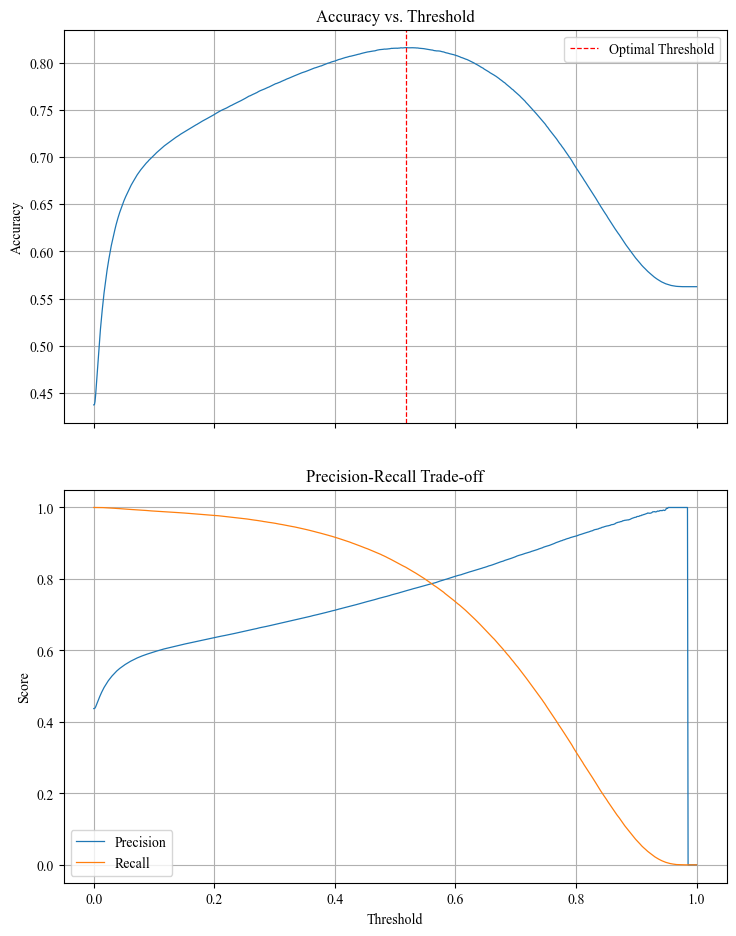

CPU times: total: 2min 30s
Wall time: 3min 4s


In [51]:
%%time
optimal_threshold = threshold(model_xg)

#### Only run this if dealing with tree model

In [39]:
is_tree(model,X_raw_total,y_raw_total)

              precision    recall  f1-score   support

           0       0.87      0.77      0.82     89603
           1       0.74      0.85      0.79     69653

    accuracy                           0.81    159256
   macro avg       0.81      0.81      0.81    159256
weighted avg       0.81      0.81      0.81    159256



#### Feature importance with final model

Let' have a look at how the variables matter to the model

In [44]:
model_xg.fit(X_raw_total, y_raw_total)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3814176234306306, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.27988573280066886,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09841076258185175,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=195, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

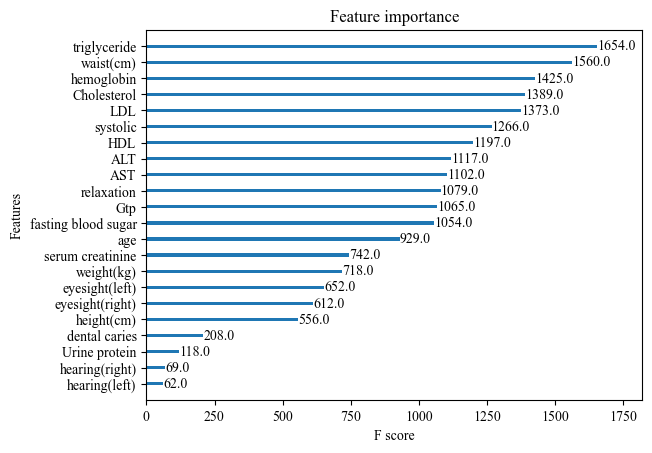

In [47]:
plot_importance(model_xg, grid=False)
pass

In the context of the plot_importance() function, the label "F-score" on the x-axis doesn't refer to the F1-score used for evaluating classification models. Instead, in this context, "F-score" it's a measure of how important a feature is in the XGBoost model. The more often a feature is used, the higher its F-score, and the more important it is considered by the model.

# **Making Predictions**

In [48]:
sample=read_csv('sample_submission.csv') #We get the id's out of here

This code underneath is responsible for making the predictions. It differentiates wether its a probabilisic model or not

In [53]:
def make_prediction(model, threshold, test_df, tree):

  if tree == True:
    y_pred = model.predict(test_df)
    
  else:
    y_score = model.predict_proba(test_df)[:,1]
    # Apply the optimal threshold to get the final predictions
    y_pred = (y_score >= threshold).astype(int)

  # Create a dataframe to store the results
  submission_df = pd.DataFrame({'id': sample['id'], 'smoking': y_pred})

  # Save the results to a CSV file
  submission_final = submission_df.to_csv('submissions/submission_xg_original_df.csv', index=False)

  return submission_df, submission_final

In [54]:
submission_df, submission_final = make_prediction(model_xg,0.5185,test_df=test_df_scaled,tree=False)
# We have to clarify that for XGBoost, the threshold has to be manually indicated to a Numpy version error.
submission_final

We are interested in seen the comparisson between the distribution of smoker's status in both the training set and predicted test set

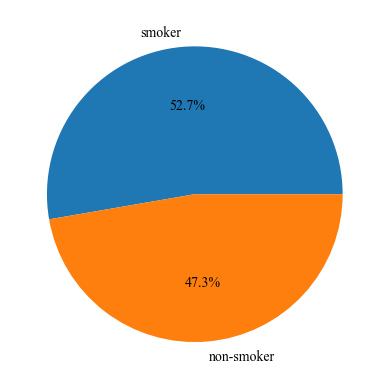

In [57]:
label_map = {0: 'non-smoker', 1: 'smoker'}
submission_df['smoking'].value_counts().plot.pie(labels=[label_map[label] for label in submission_df['smoking'].unique()], autopct='%1.1f%%')
pylab.ylabel('')
pass